# Hello World AML pipeline with components

The purpose of this tutorial is to show how to incrementally build a pipeline from simple and debuggable "Hello World" components. In order to run this at home, you may find it useful to create a free Azure ML subscription as described in the how-to guide I have [here](../../additional/data_science/aml/free_subscription.html)

## Starting development with a notebook 

In this section, we will write our code in a notebook and make sure it works well. Then, we will convert it to a script and run it from the terminal. Finally, we will add some logs with MLFlow. 

Although not required, as a very first step we can create a environment and kernel following the tutorial in https://learn.microsoft.com/en-gb/azure/machine-learning/tutorial-cloud-workstation?view=azureml-api-2

Following the previous tutorial, create a notebook and type the following hello world code:

In [ ]:
def hello_world (name):
    """Greets the indicated person and the world in general."""
    
    print (f"Hello {name} and world")

hello_world ("Jaume")

Hello Jaume and world


Fantastic, the code works ;-). Now, let's convert it to a script that can be run from terminal. The tutorial above explains how to convert the notebook to a python file. In our case, we will first add an argument parser and then write it to file using the magic cell `%%writefile`

In [ ]:
%%writefile hello_world_core.py
import argparse

def hello_world (name):
    """Greets the indicated person and the world in general."""
    
    print (f"Hello {name} and world")

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--name", type=str, help="person to greet")
    args = parser.parse_args()
    
    return args

def main():
    """Main function of the script."""
    
    args = parse_args ()
    hello_world (args.name)

if __name__ == "__main__":
    main()

Overwriting hello_world_core.py


Now, we can open up a terminal, as illustrated in the tutorial above, cd to the folder where the script is and run it:

```bash
cd  Users/<my_user>/hello_world
python hello_world_core.py --name Jaume
```

### Adding logs with MLflow

In [ ]:
%%writefile hello_world_with_logs.py
import mlflow
from hello_world_core import hello_world, parse_args

def start_logging (args):
    # set name for logging
    mlflow.set_experiment("Hello World with logging")
    mlflow.start_run()
    mlflow.log_param ("name to log", args.name)
    
def finish_logging ():
    mlflow.end_run ()

def main():
    """Main function of the script."""
    args = parse_args ()
    start_logging (args)
    hello_world (args.name)
    finish_logging ()

if __name__ == "__main__":
    main()

Overwriting hello_world_with_logs.py


Let's run it and see:

```bash
python hello_world_with_logs.py --name Peter
```

Here is the newly created job:

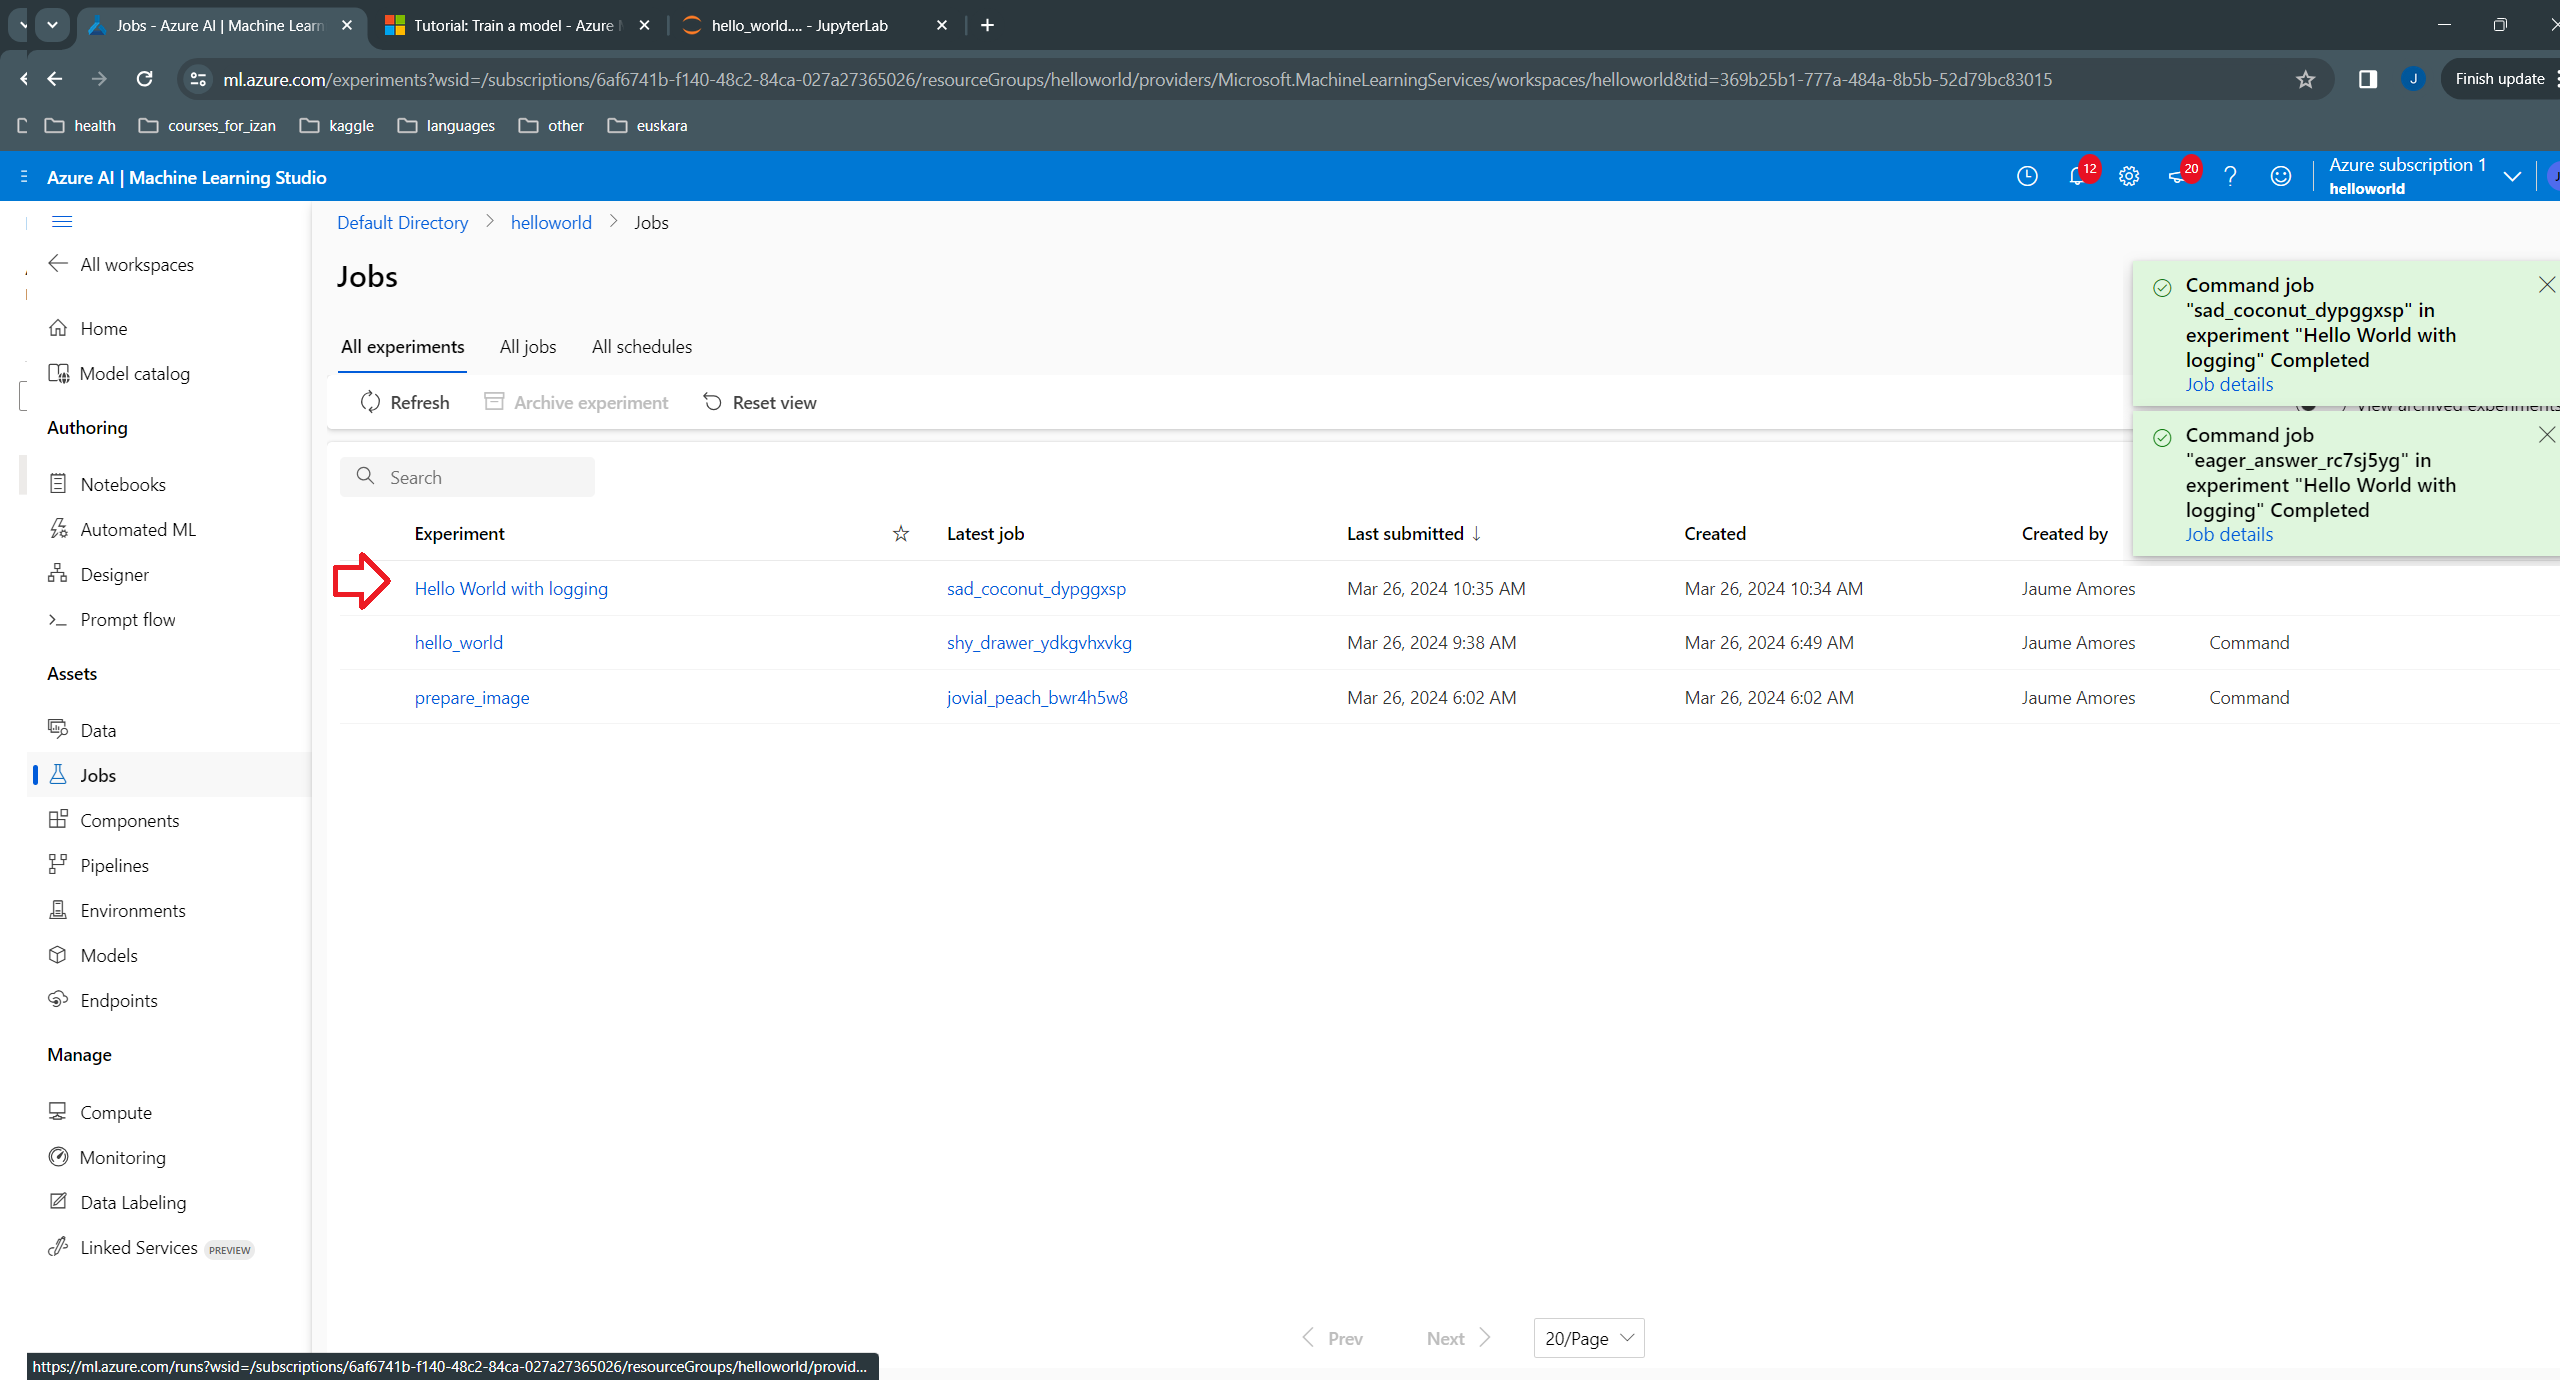

And the name passed as argument:

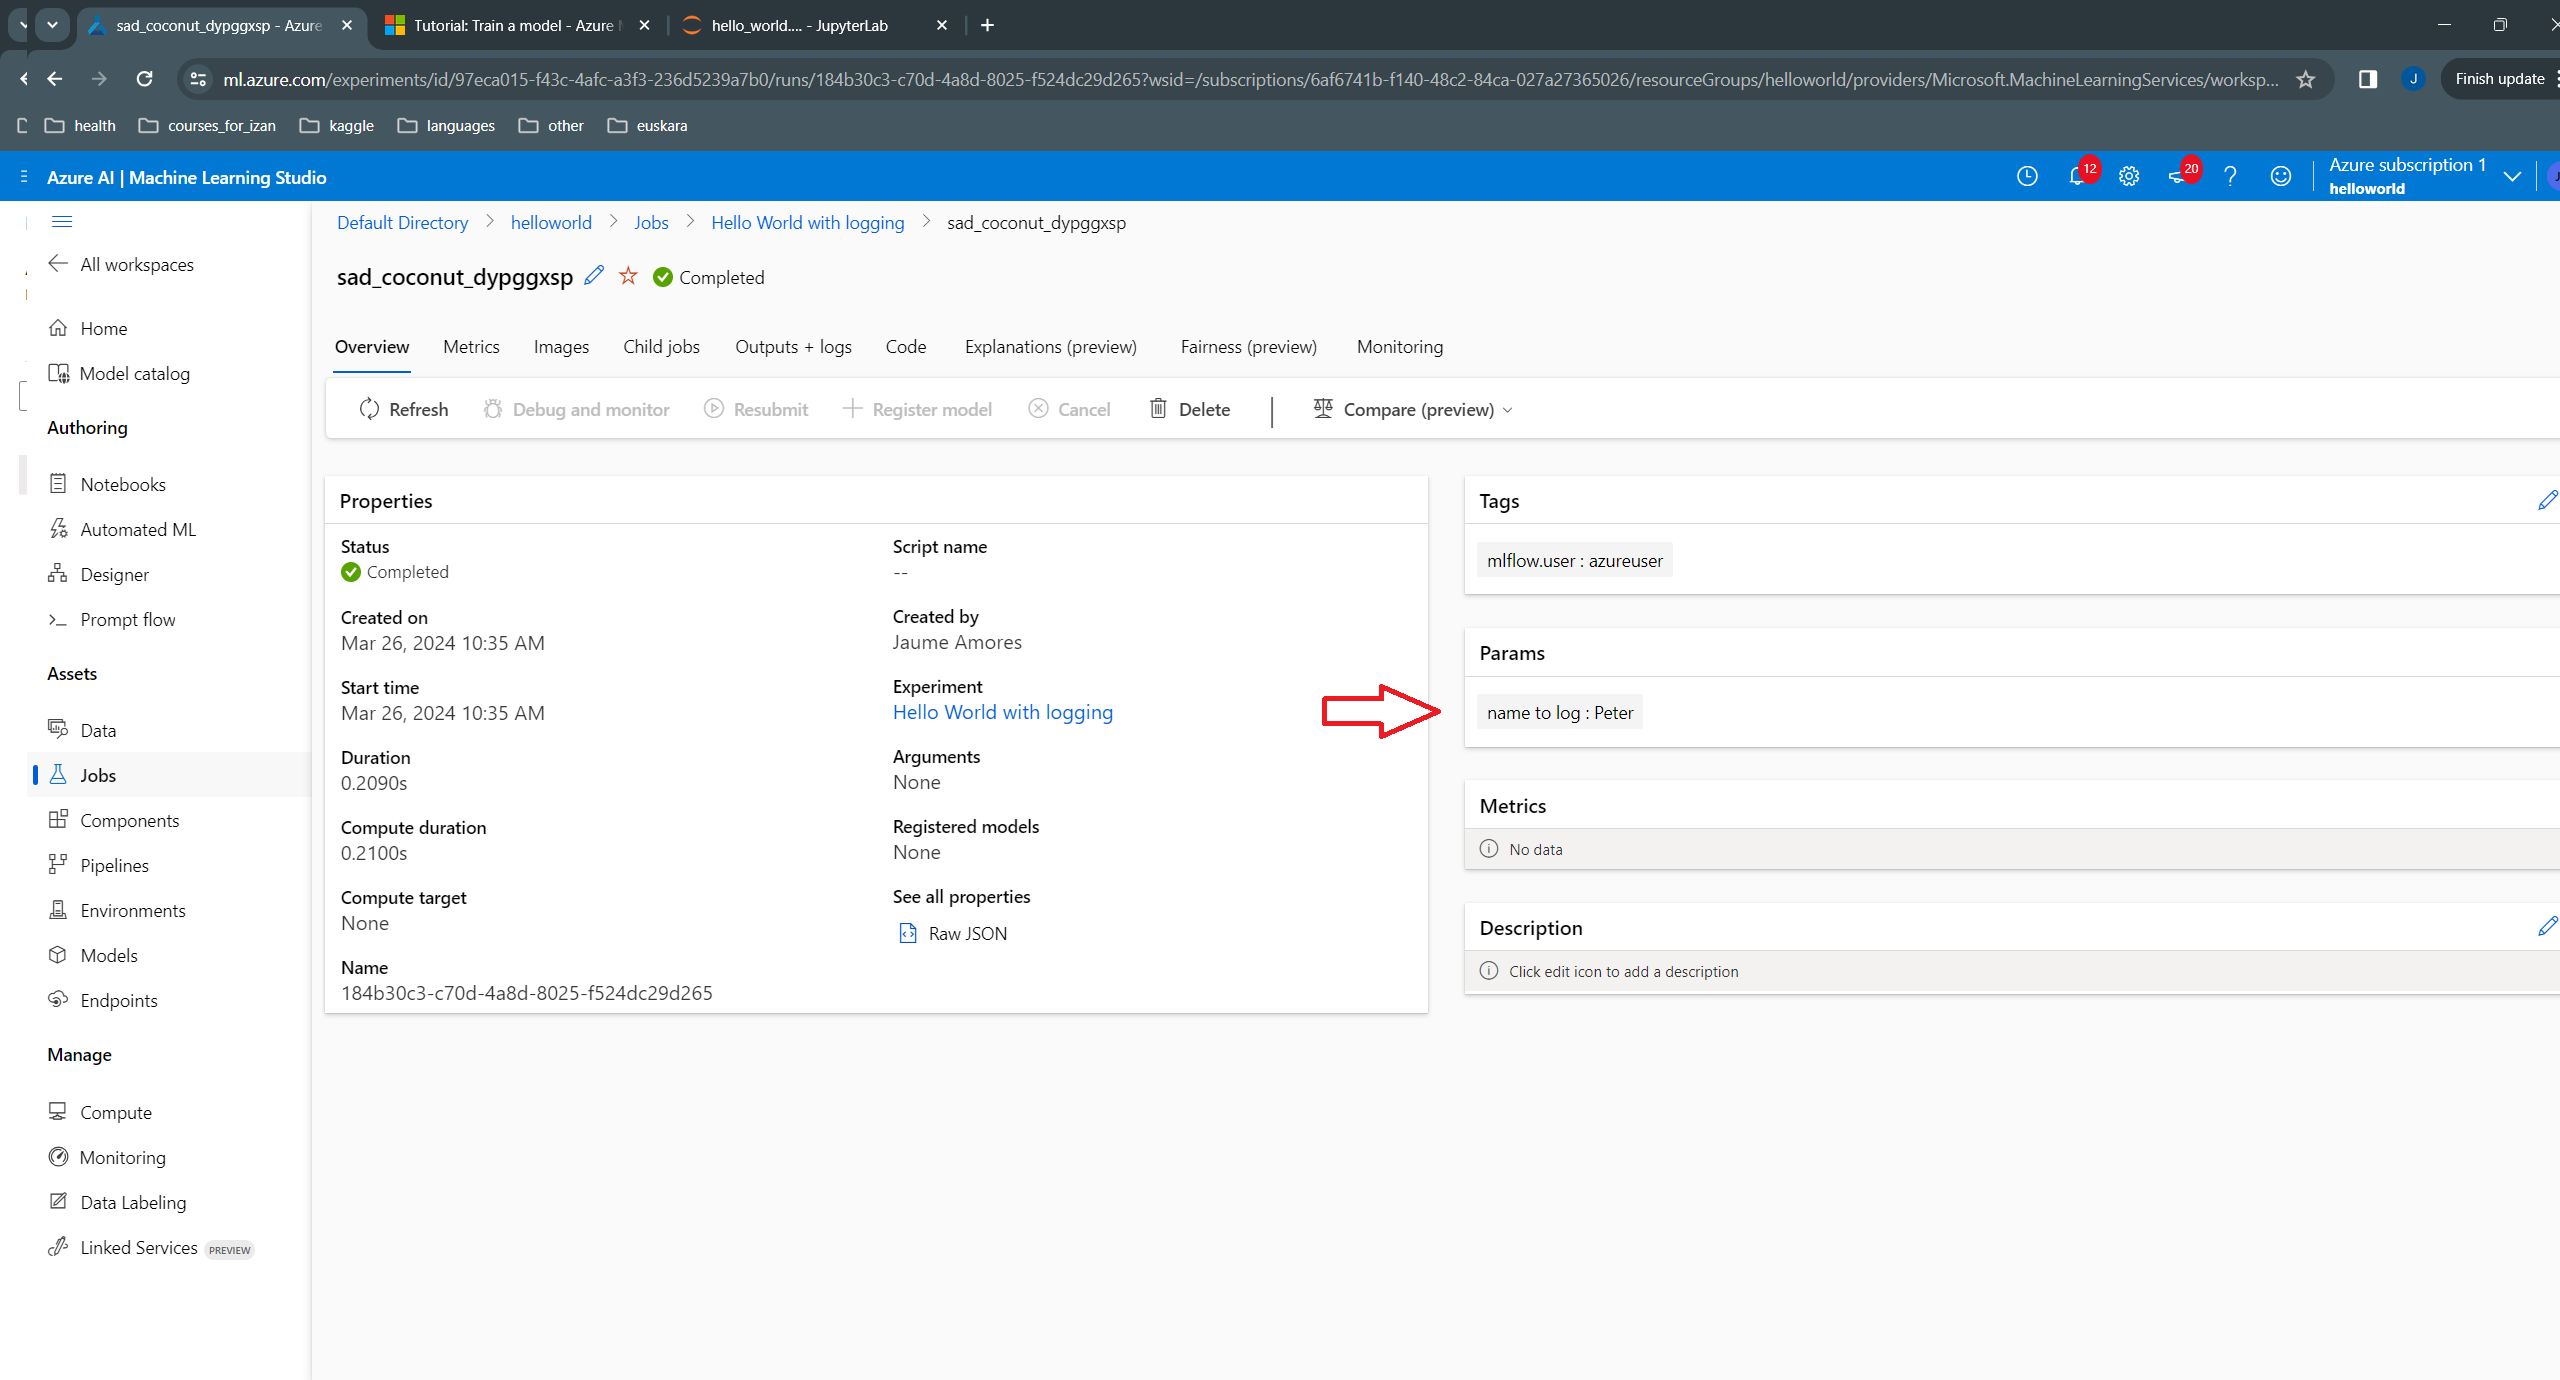

We start by getting a connection to our Azure ML (AML for short) workspace. We use here a simple connection mechanism that doesn't require writting your subscription, resource group and workspace details:

In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config (
    credential=credential
)

Found the config file in: /config.json


## Running script as a job

We now convert the previous script into a job that can be run from the UI. 

### Importing required modules

In [57]:
# Standard imports
import os

# Third-party imports
import pandas as pd

# AML imports
from azure.ai.ml import (
    command,
    dsl,
    Input,
    Output,
    MLClient
)
from azure.identity import DefaultAzureCredential

### Setting connection

For the remaining part of this tutorial, we will be needing an `ml_client` handle. This will allow us to create and use resources from our workspace. The simplest way to get such handle is with the following code:

In [58]:
# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config (
    credential=credential
)

Found the config file in: /config.json


### Specifying and submitting job

We specify a job using the `command` decorator:

In [ ]:
job = command(
    inputs=dict(
        name="Jaume", # default value of our parameter
    ),
    code=f"./",  # location of source code: in this case, the root folder
    command="python hello_world_core.py --name ${{inputs.name}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Simplest Hello World",
)

> Note: we indicate as environment "AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest", which actually contains more libraries than we need, such as sklearn. Simpler environments to use can be found in the "Environments" section of the workspace.

... and submit it using `create_or_update` from `ml_client`:

In [ ]:
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading hello_world (8.59 MBs): 100%

Command({'parameters': {}, 'init': False, 'name': 'clever_spade_sq4jwcg67r', 'type': 'command', 'status': 'Starting', 'log_files': None, 'description': None, 'tags': {}, 'properties': {'_azureml.ComputeTargetType': 'amlctrain', '_azureml.ClusterName': None, 'ContentSnapshotId': '59fd973d-6cab-4386-a4a8-f1ea1676287f'}, 'print_as_yaml': True, 'id': '/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourceGroups/helloworld/providers/Microsoft.MachineLearningServices/workspaces/helloworld/jobs/clever_spade_sq4jwcg67r', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/jaumecpu/code/Users/jau.m/hello_world', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object>, 'serialize': <msrest.serialization.Serializer object>, 'allowed_keys': {}, 'key_restriction': False, 'logger': <Logger attr_dict (WARNING)>, 'display_name': 'Simplest Hello World', 'experiment_name': 'hello_world', 'compute': None, 'services': {'Tracking': {'endpoint': 'azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourceGroups/helloworld/providers/Microsoft.MachineLearningServices/workspaces/helloworld?', 'type': 'Tracking'}, 'Studio': {'endpoint': 'https://ml.azure.com/runs/clever_spade_sq4jwcg67r?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld&tid=369b25b1-777a-484a-8b5b-52d79bc83015', 'type': 'Studio'}}, 'comment': None, 'job_inputs': {'name': 'Jaume'}, 'job_outputs': {'default': {'type': 'uri_folder', 'path': 'azureml://datastores/workspaceartifactstore/ExperimentRun/dcid.clever_spade_sq4jwcg67r', 'mode': 'rw_mount'}}, 'inputs': {'name': <azure.ai.ml.entities._job.pipeline._io.base.NodeInput object>}, 'outputs': {'default': <azure.ai.ml.entities._job.pipeline._io.base.NodeOutput object>}, 'component': CommandComponent({'intellectual_property': None, 'auto_increment_version': True, 'source': 'REMOTE.WORKSPACE.JOB', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'clever_spade_sq4jwcg67r', 'description': None, 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': None, 'Resource__source_path': None, 'base_path': PosixPath('.'), 'creation_context': <azure.ai.ml.entities._system_data.SystemData object>, 'serialize': <msrest.serialization.Serializer object>, 'command': 'python hello_world_core.py --name ${{inputs.name}}', 'code': '/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourceGroups/helloworld/providers/Microsoft.MachineLearningServices/workspaces/helloworld/codes/6ac1a0d9-2ea6-48d4-be76-c738397c29f9/versions/1', 'environment_variables': {}, 'environment': 'azureml:AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest', 'distribution': None, 'resources': None, 'queue_settings': None, 'version': None, 'latest_version': None, 'schema': None, 'type': 'command', 'display_name': 'Simplest Hello World', 'is_deterministic': True, 'inputs': {'name': {'type': 'string', 'default': 'Jaume'}}, 'outputs': {'default': {'type': 'uri_folder', 'path': 'azureml://datastores/workspaceartifactstore/ExperimentRun/dcid.clever_spade_sq4jwcg67r', 'mode': 'rw_mount'}}, 'yaml_str': None, 'other_parameter': {'status': 'Starting', 'parameters': {}}, 'additional_includes': [], 'CommandComponent__additional_includes_obj': None}), 'referenced_control_flow_node_instance_id': None, 'kwargs': {'services': {'Tracking': {'endpoint': 'azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourceGroups/helloworld/providers/Microsoft.MachineLearningServices/workspaces/helloworld?', 'type': 'Tracking'}, 'Studio': {'endpoint': 'https://ml.azure.com/runs/clever_spade_sq4jwcg67r?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld&tid=369b25b1-777a-484a-8b5b-52d79bc83015', 'type': 'Studio'}}, 'status': 'Starting', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object>}, 'instance_id': 'fdfea982-8943-4733-82

In the link that appears, we can see the status of the job, which initially is "Queued". We need to wait until it is completed (and refresh the page to see this). Once it is completed, we can look at the logs:

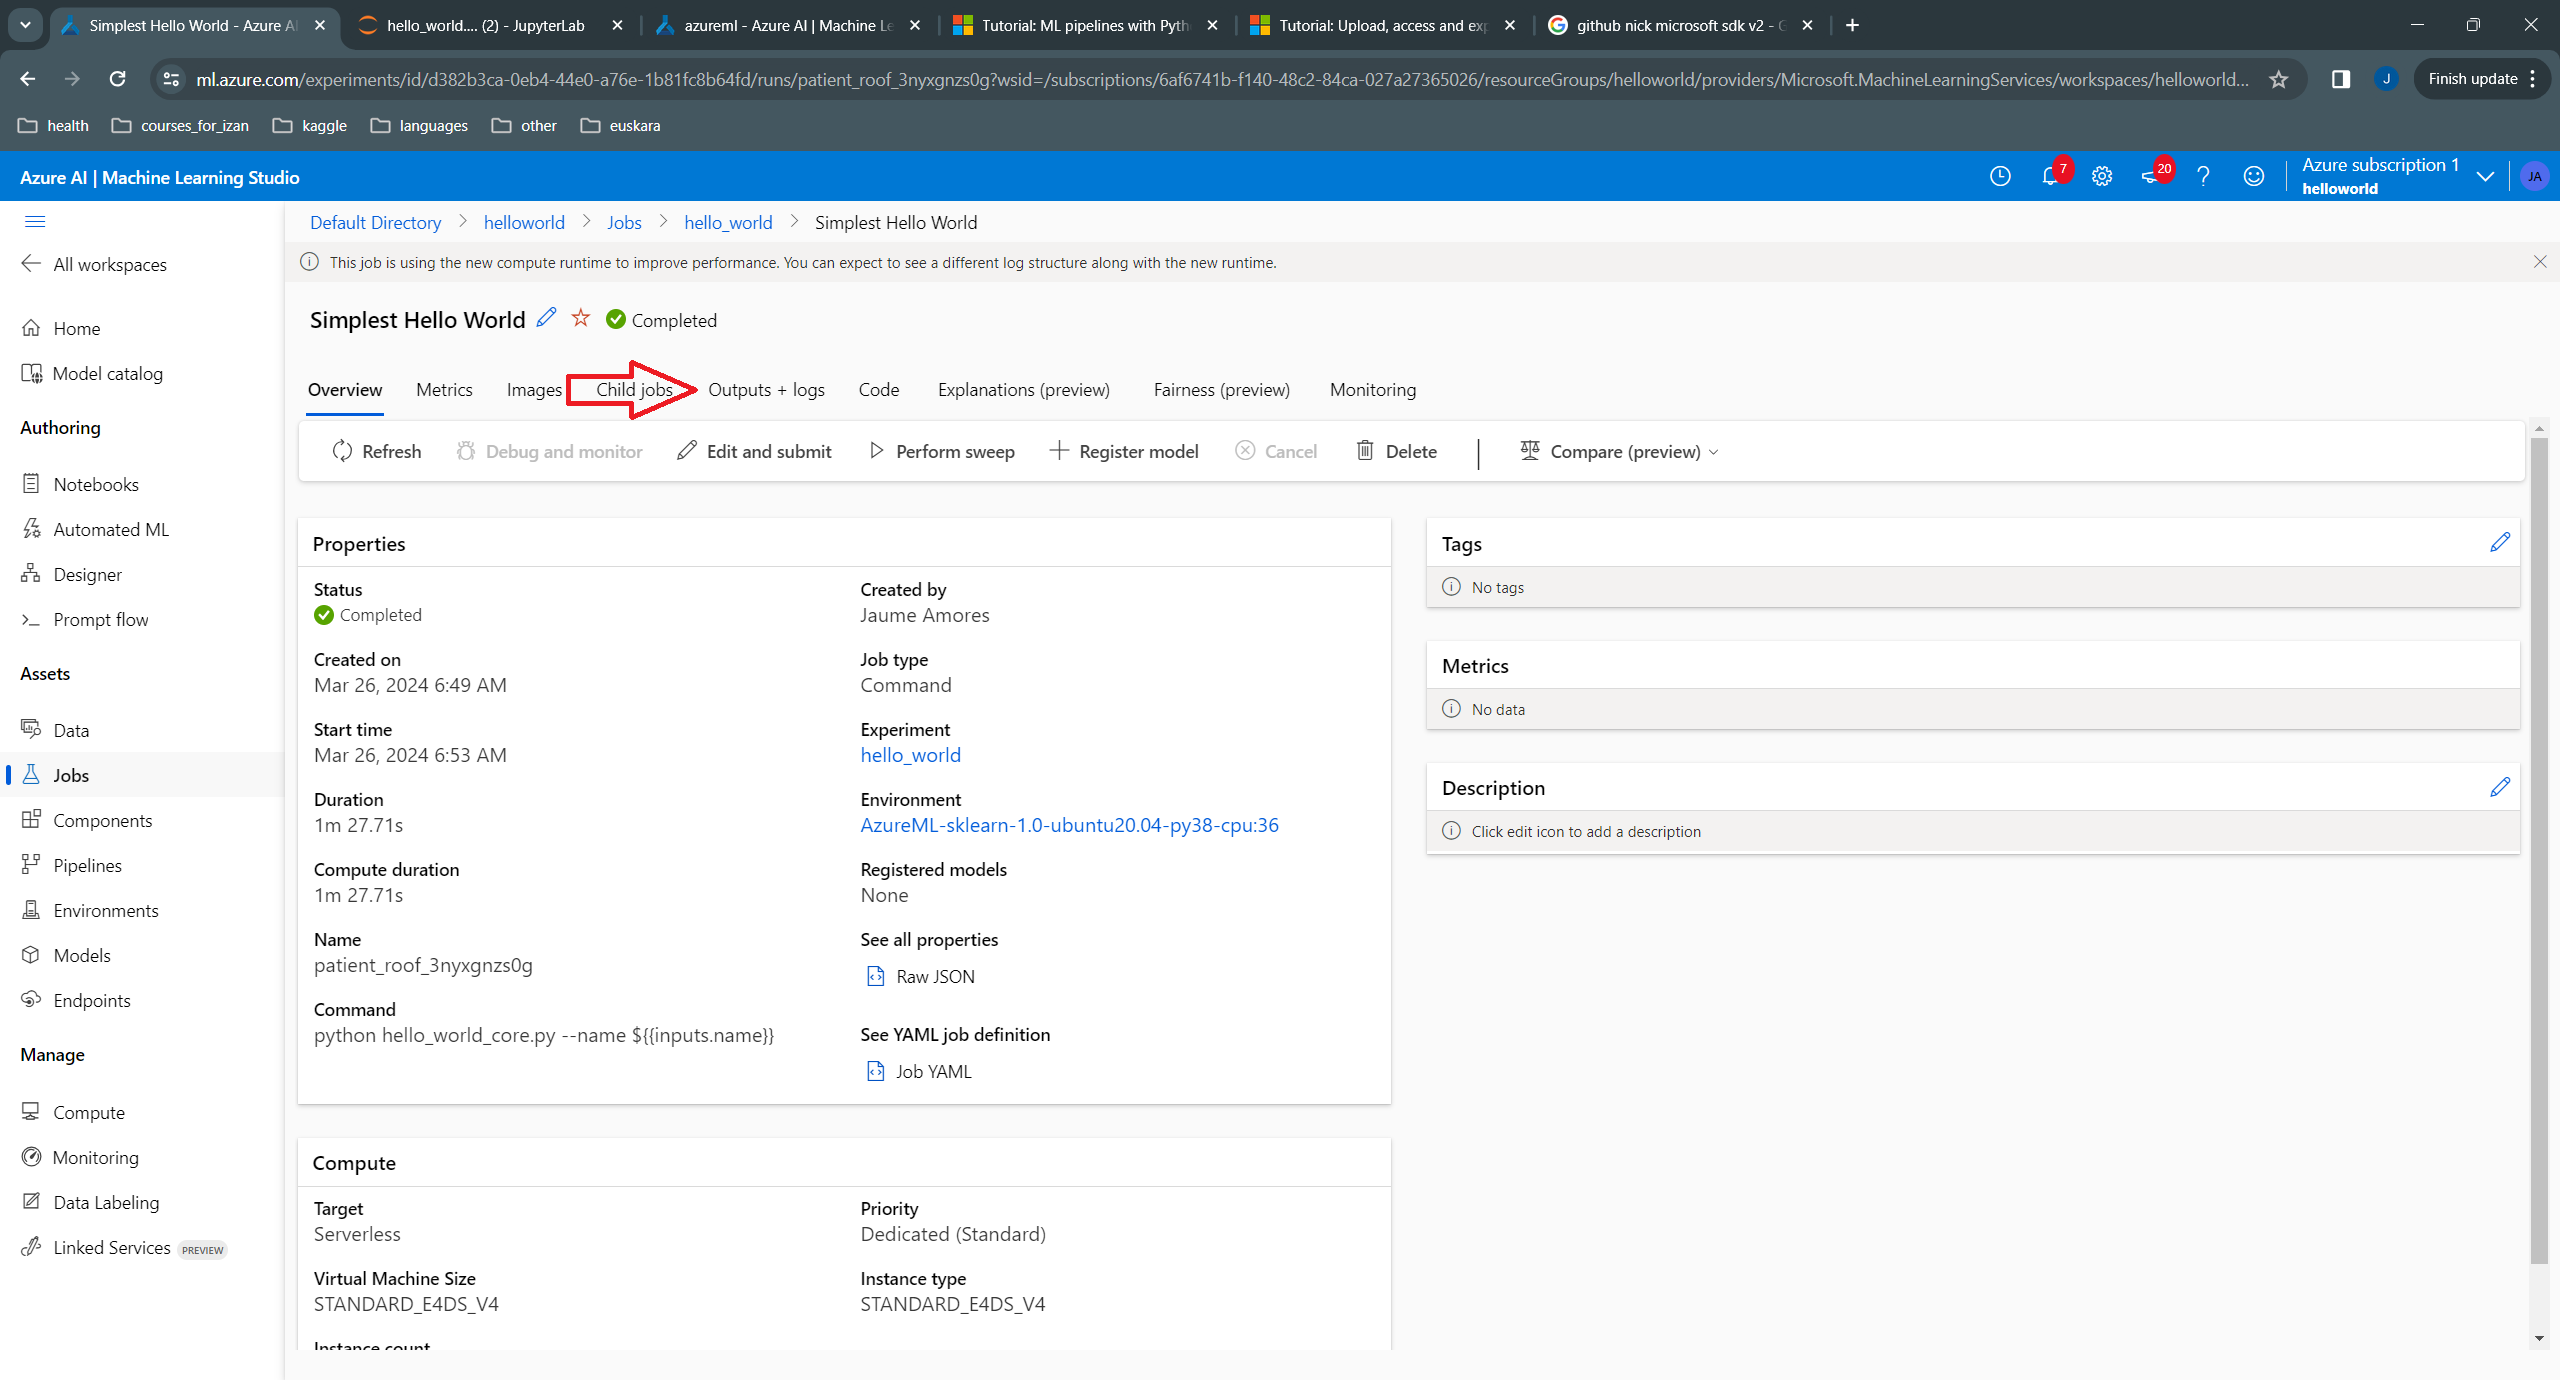

In the logs, we can see the messages printed in console:

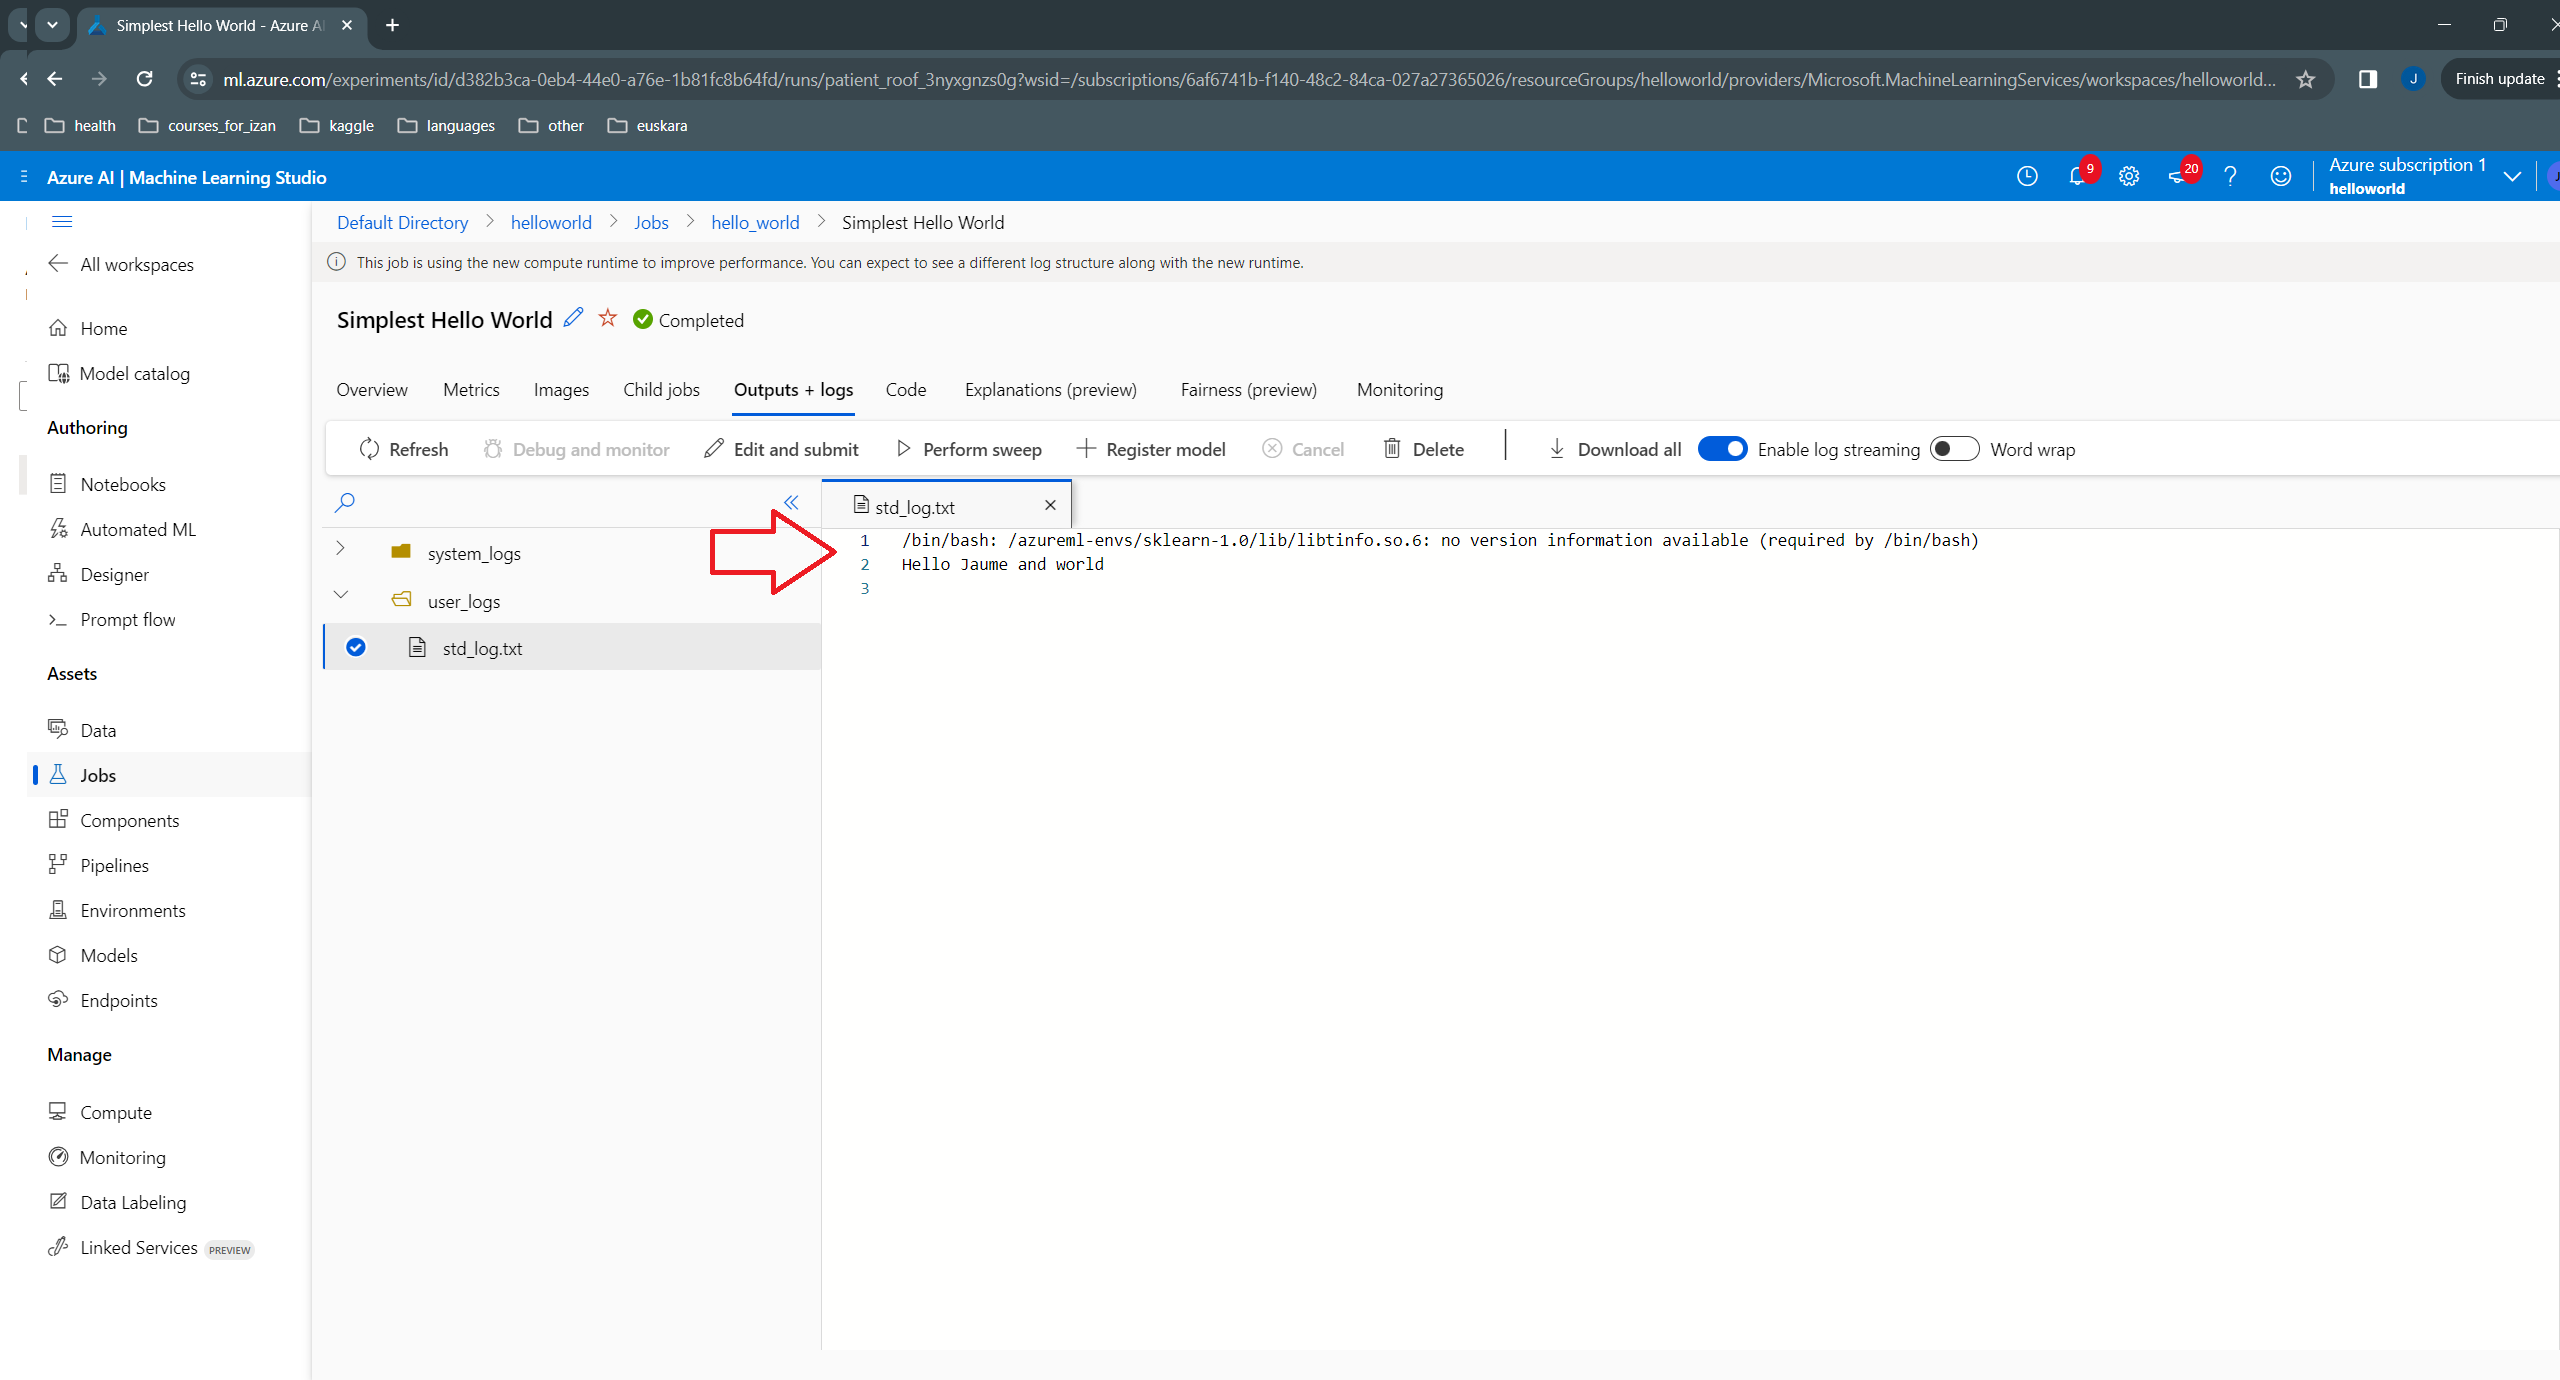

### Changing the input 

Above, we indicated a default value for the input argument `name`. It would be good to be able to submit jobs with different values for that argument. One way to do that is:

- In the job's *Overview* tab, click on "Edit and submit"

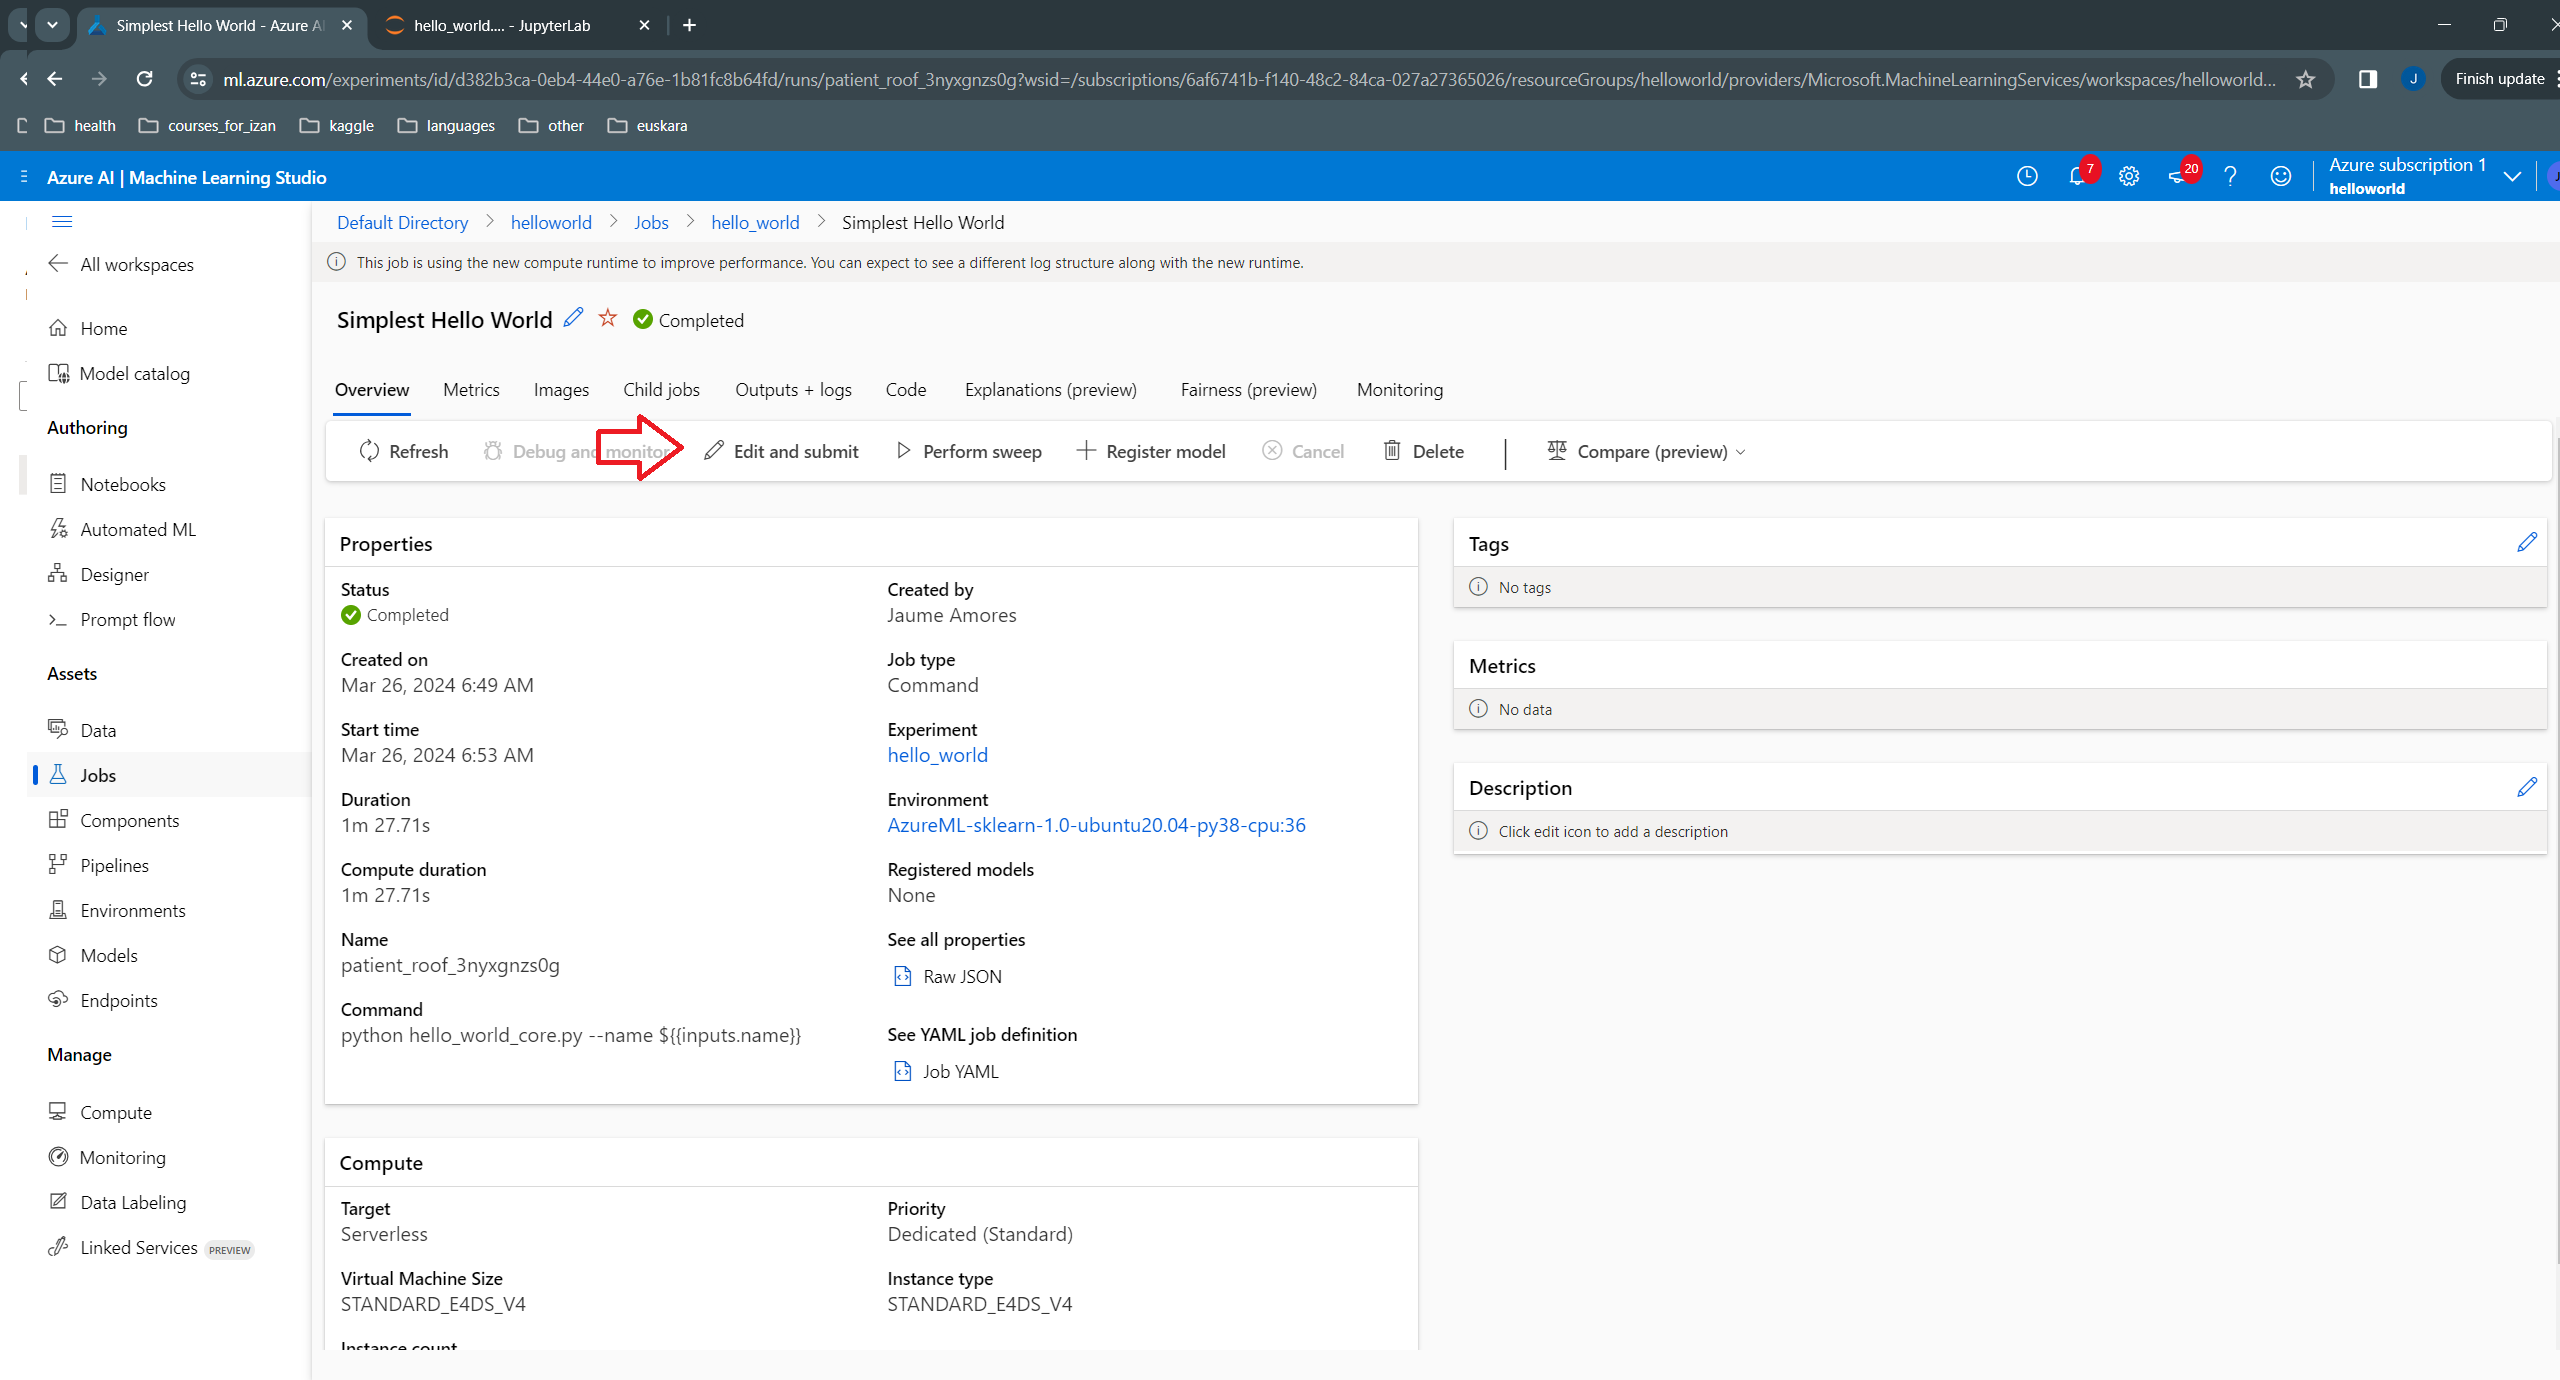

- In the "Training script" section, edit the "Inputs" by clicking on the pencil next to it:

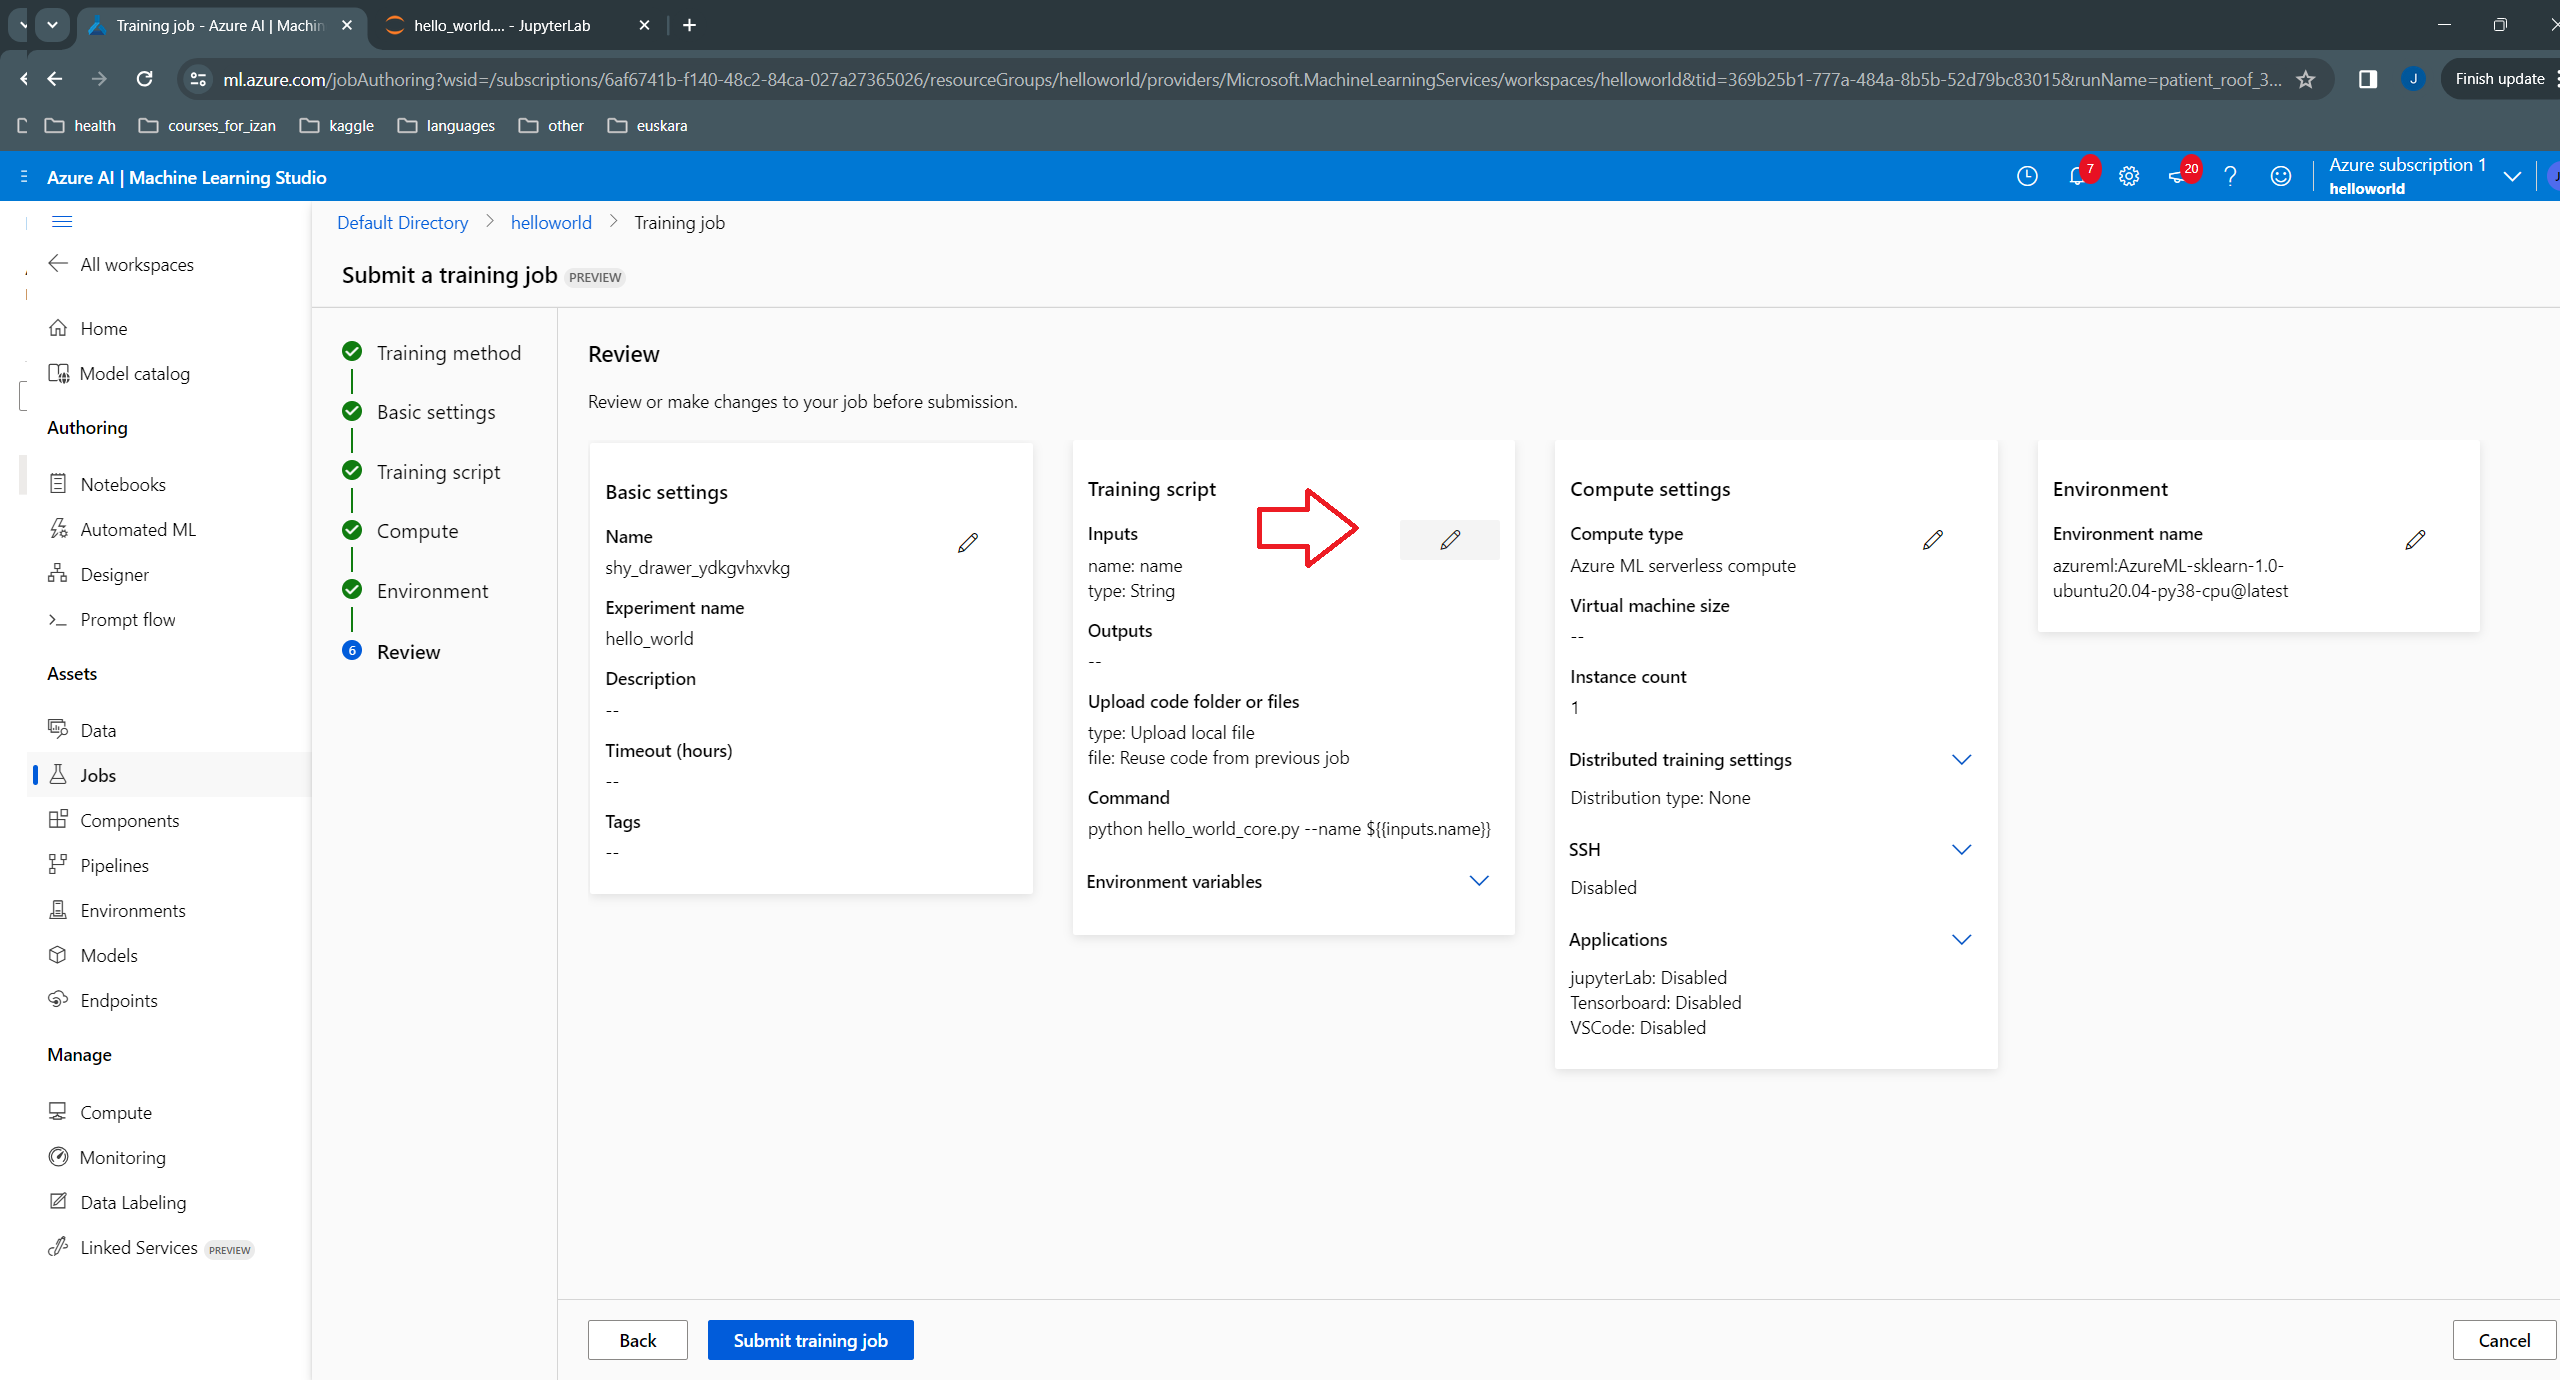

- In the "Input value" field, type the new value you want for the argument:

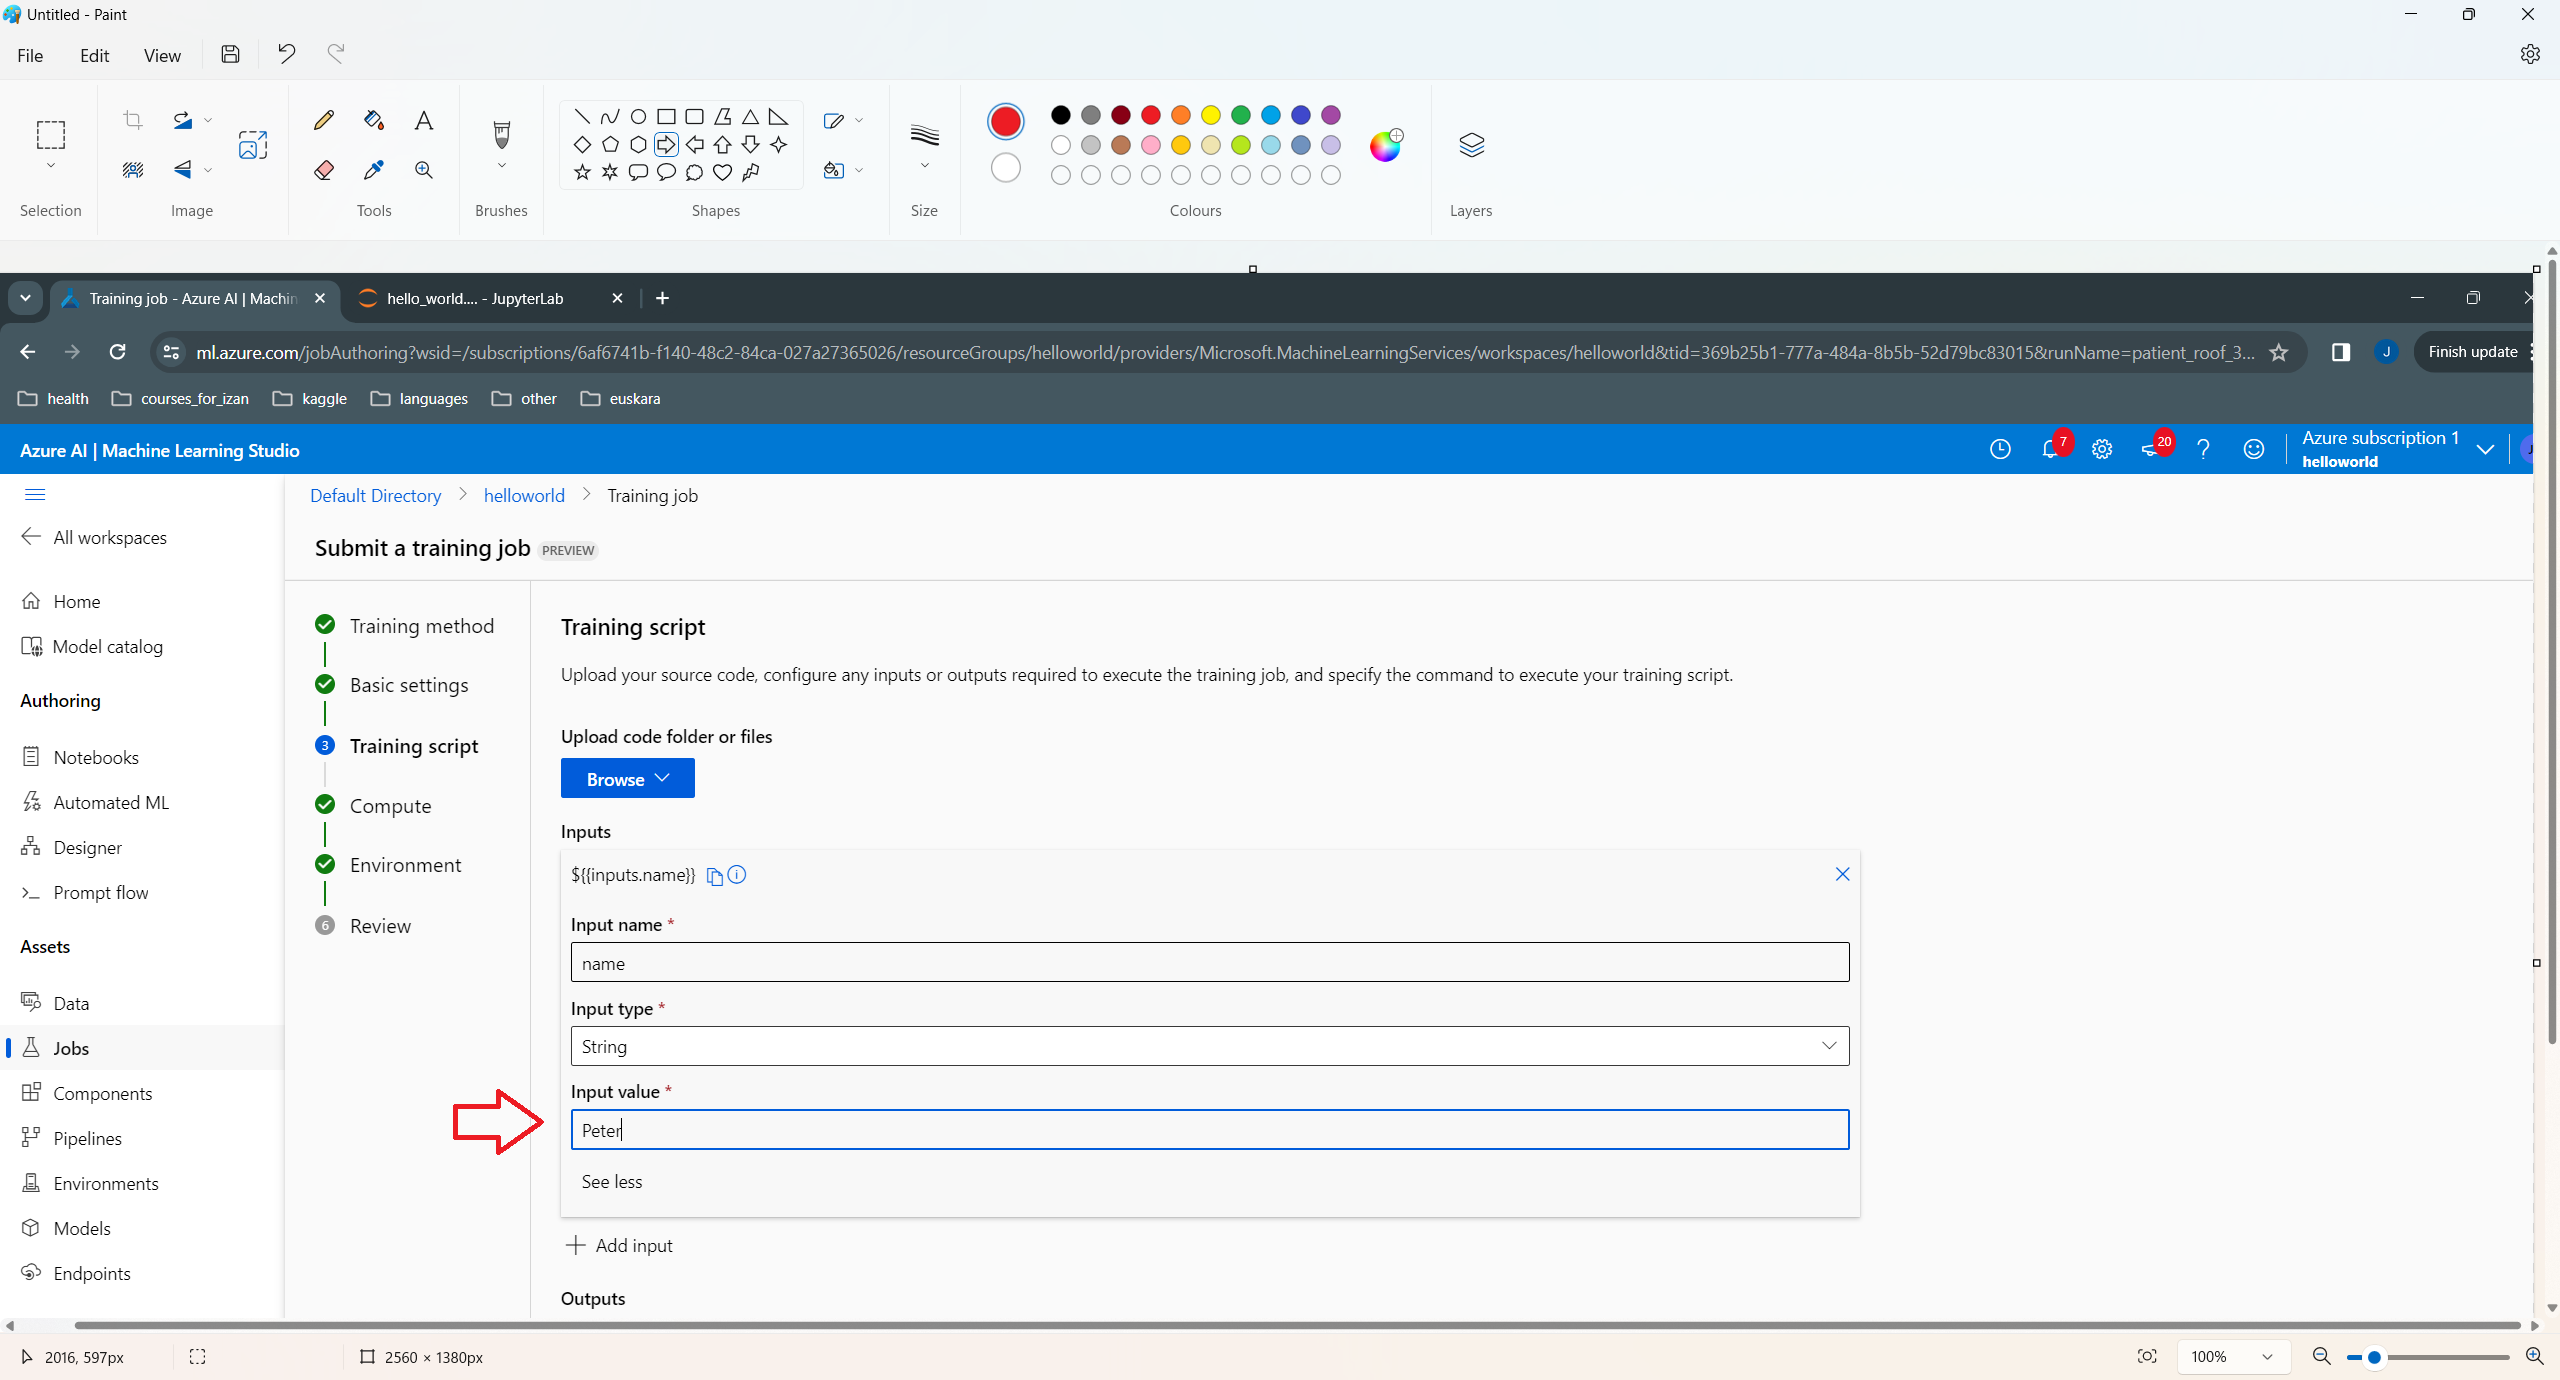

- Hit Next several times and then Submit.

- If we go to the jobs section of the workspace, and enter again our job ("helloworld"), we can see that a new job has been submitted:

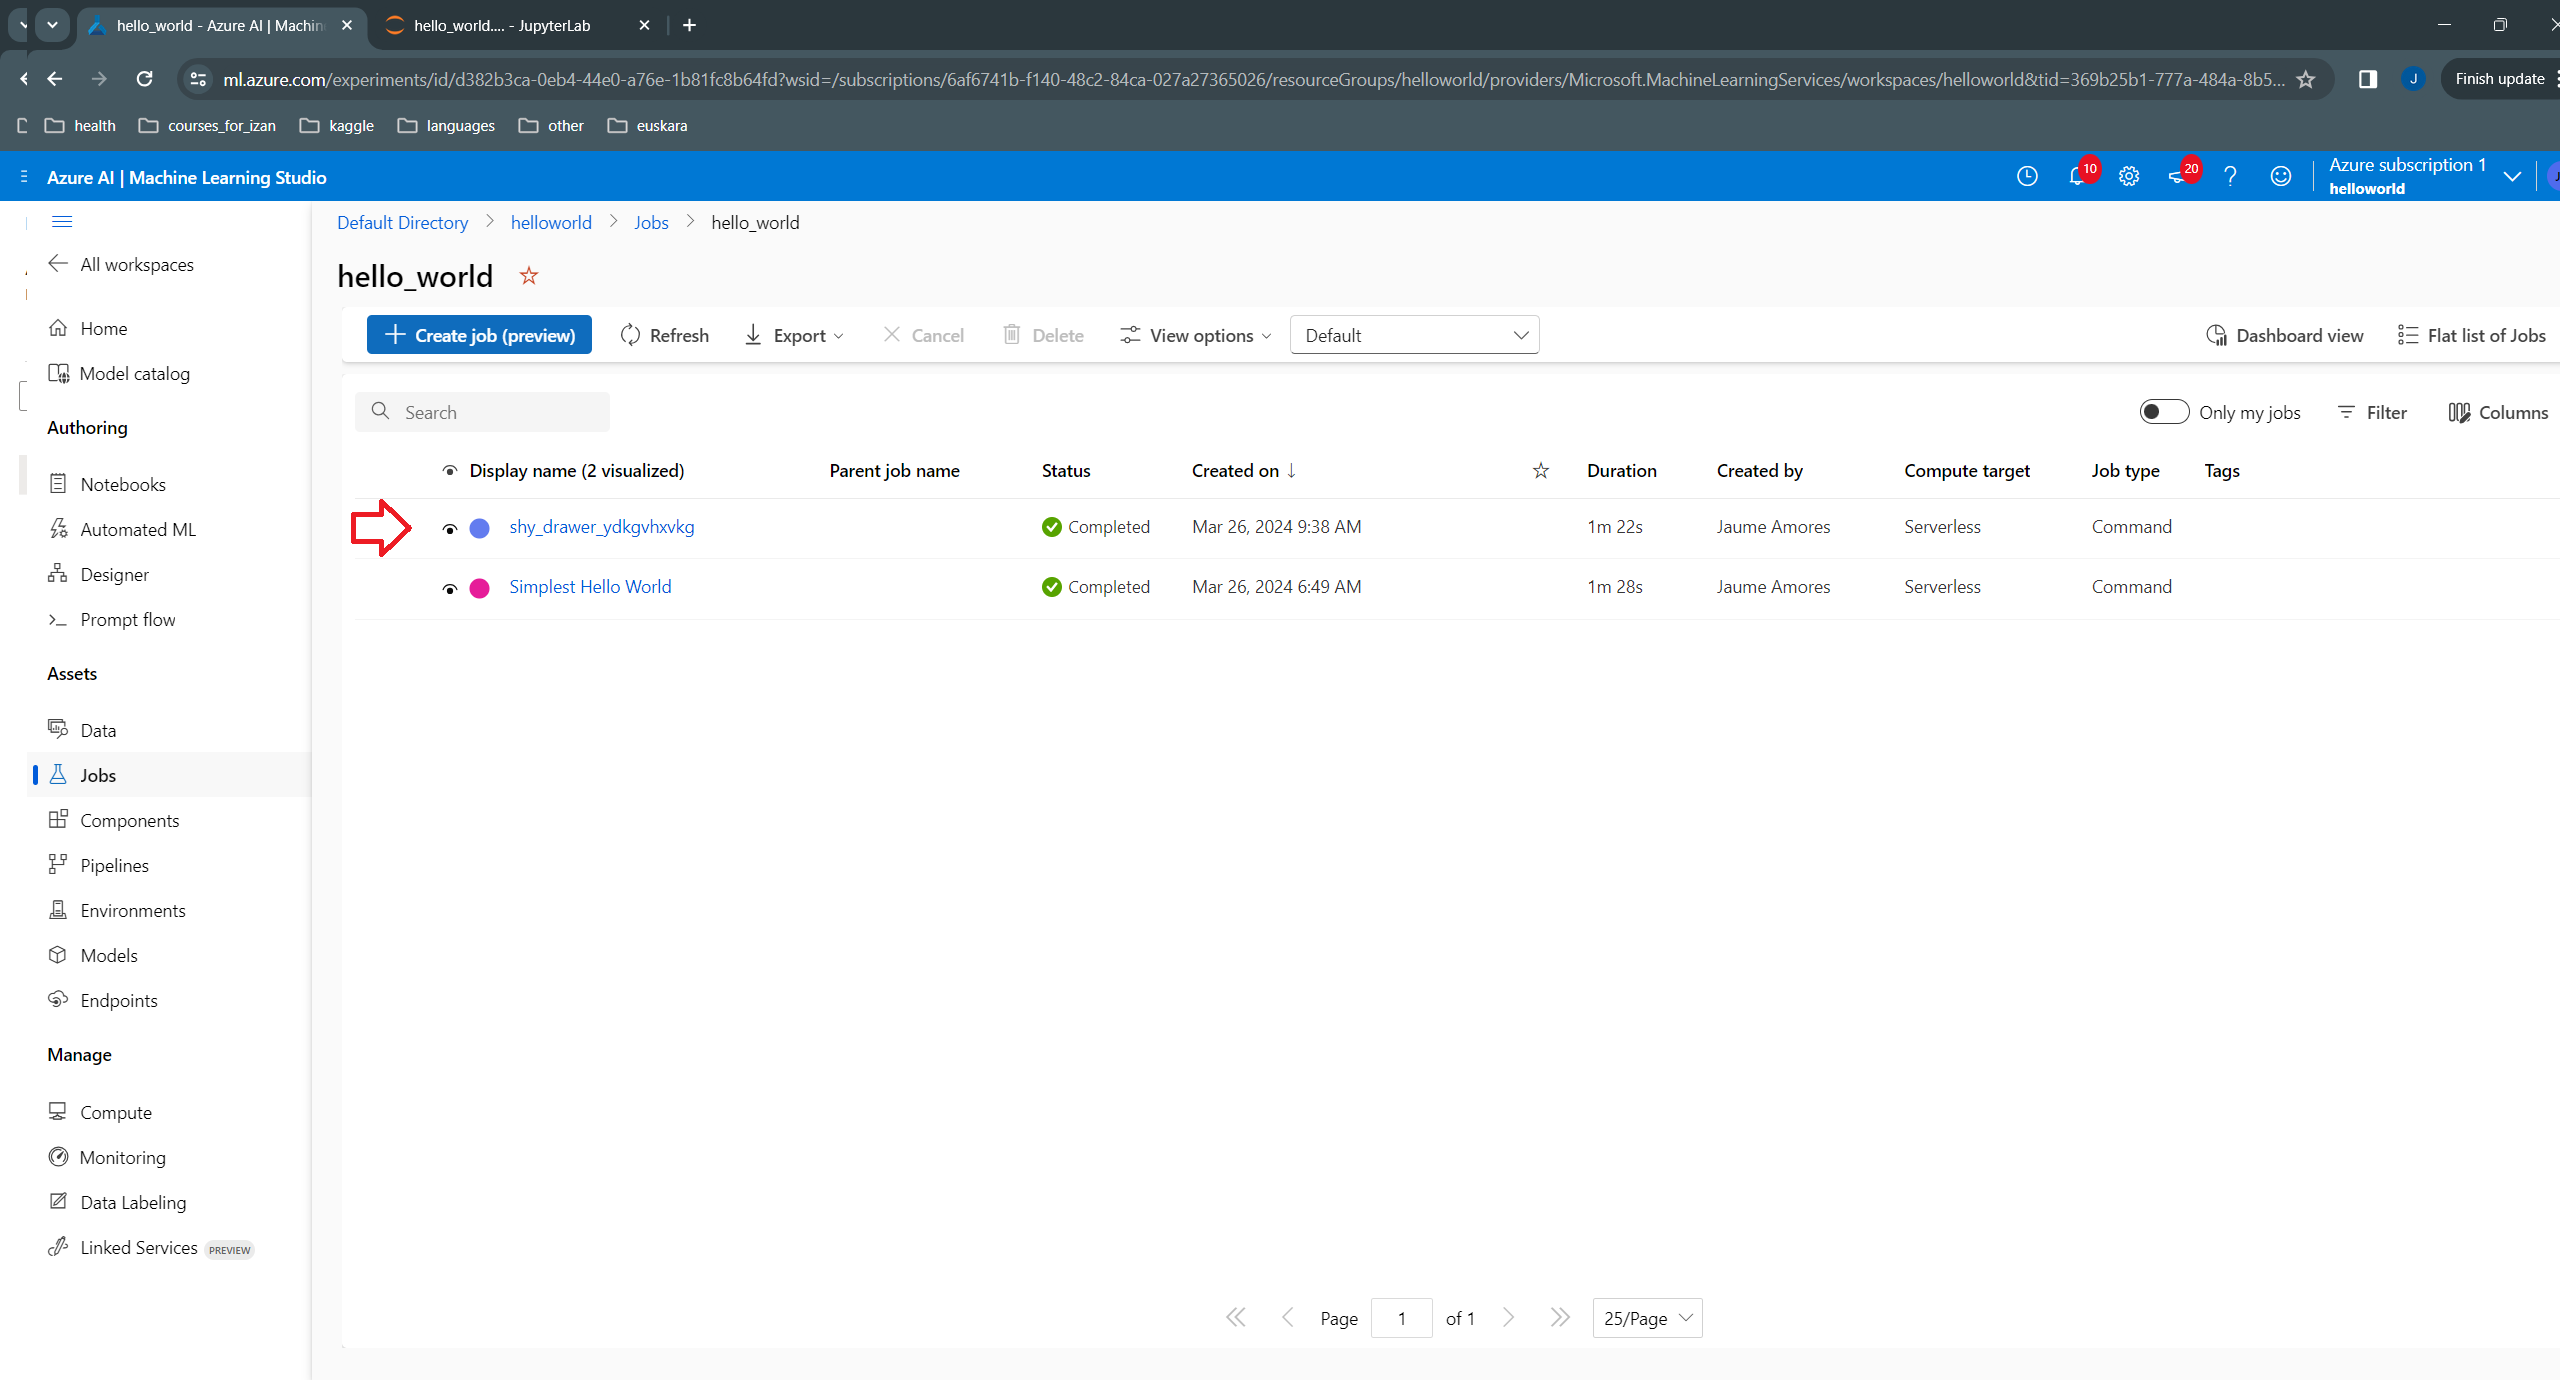

In its Overview tab, under "See all properties", we can inspect the json file:

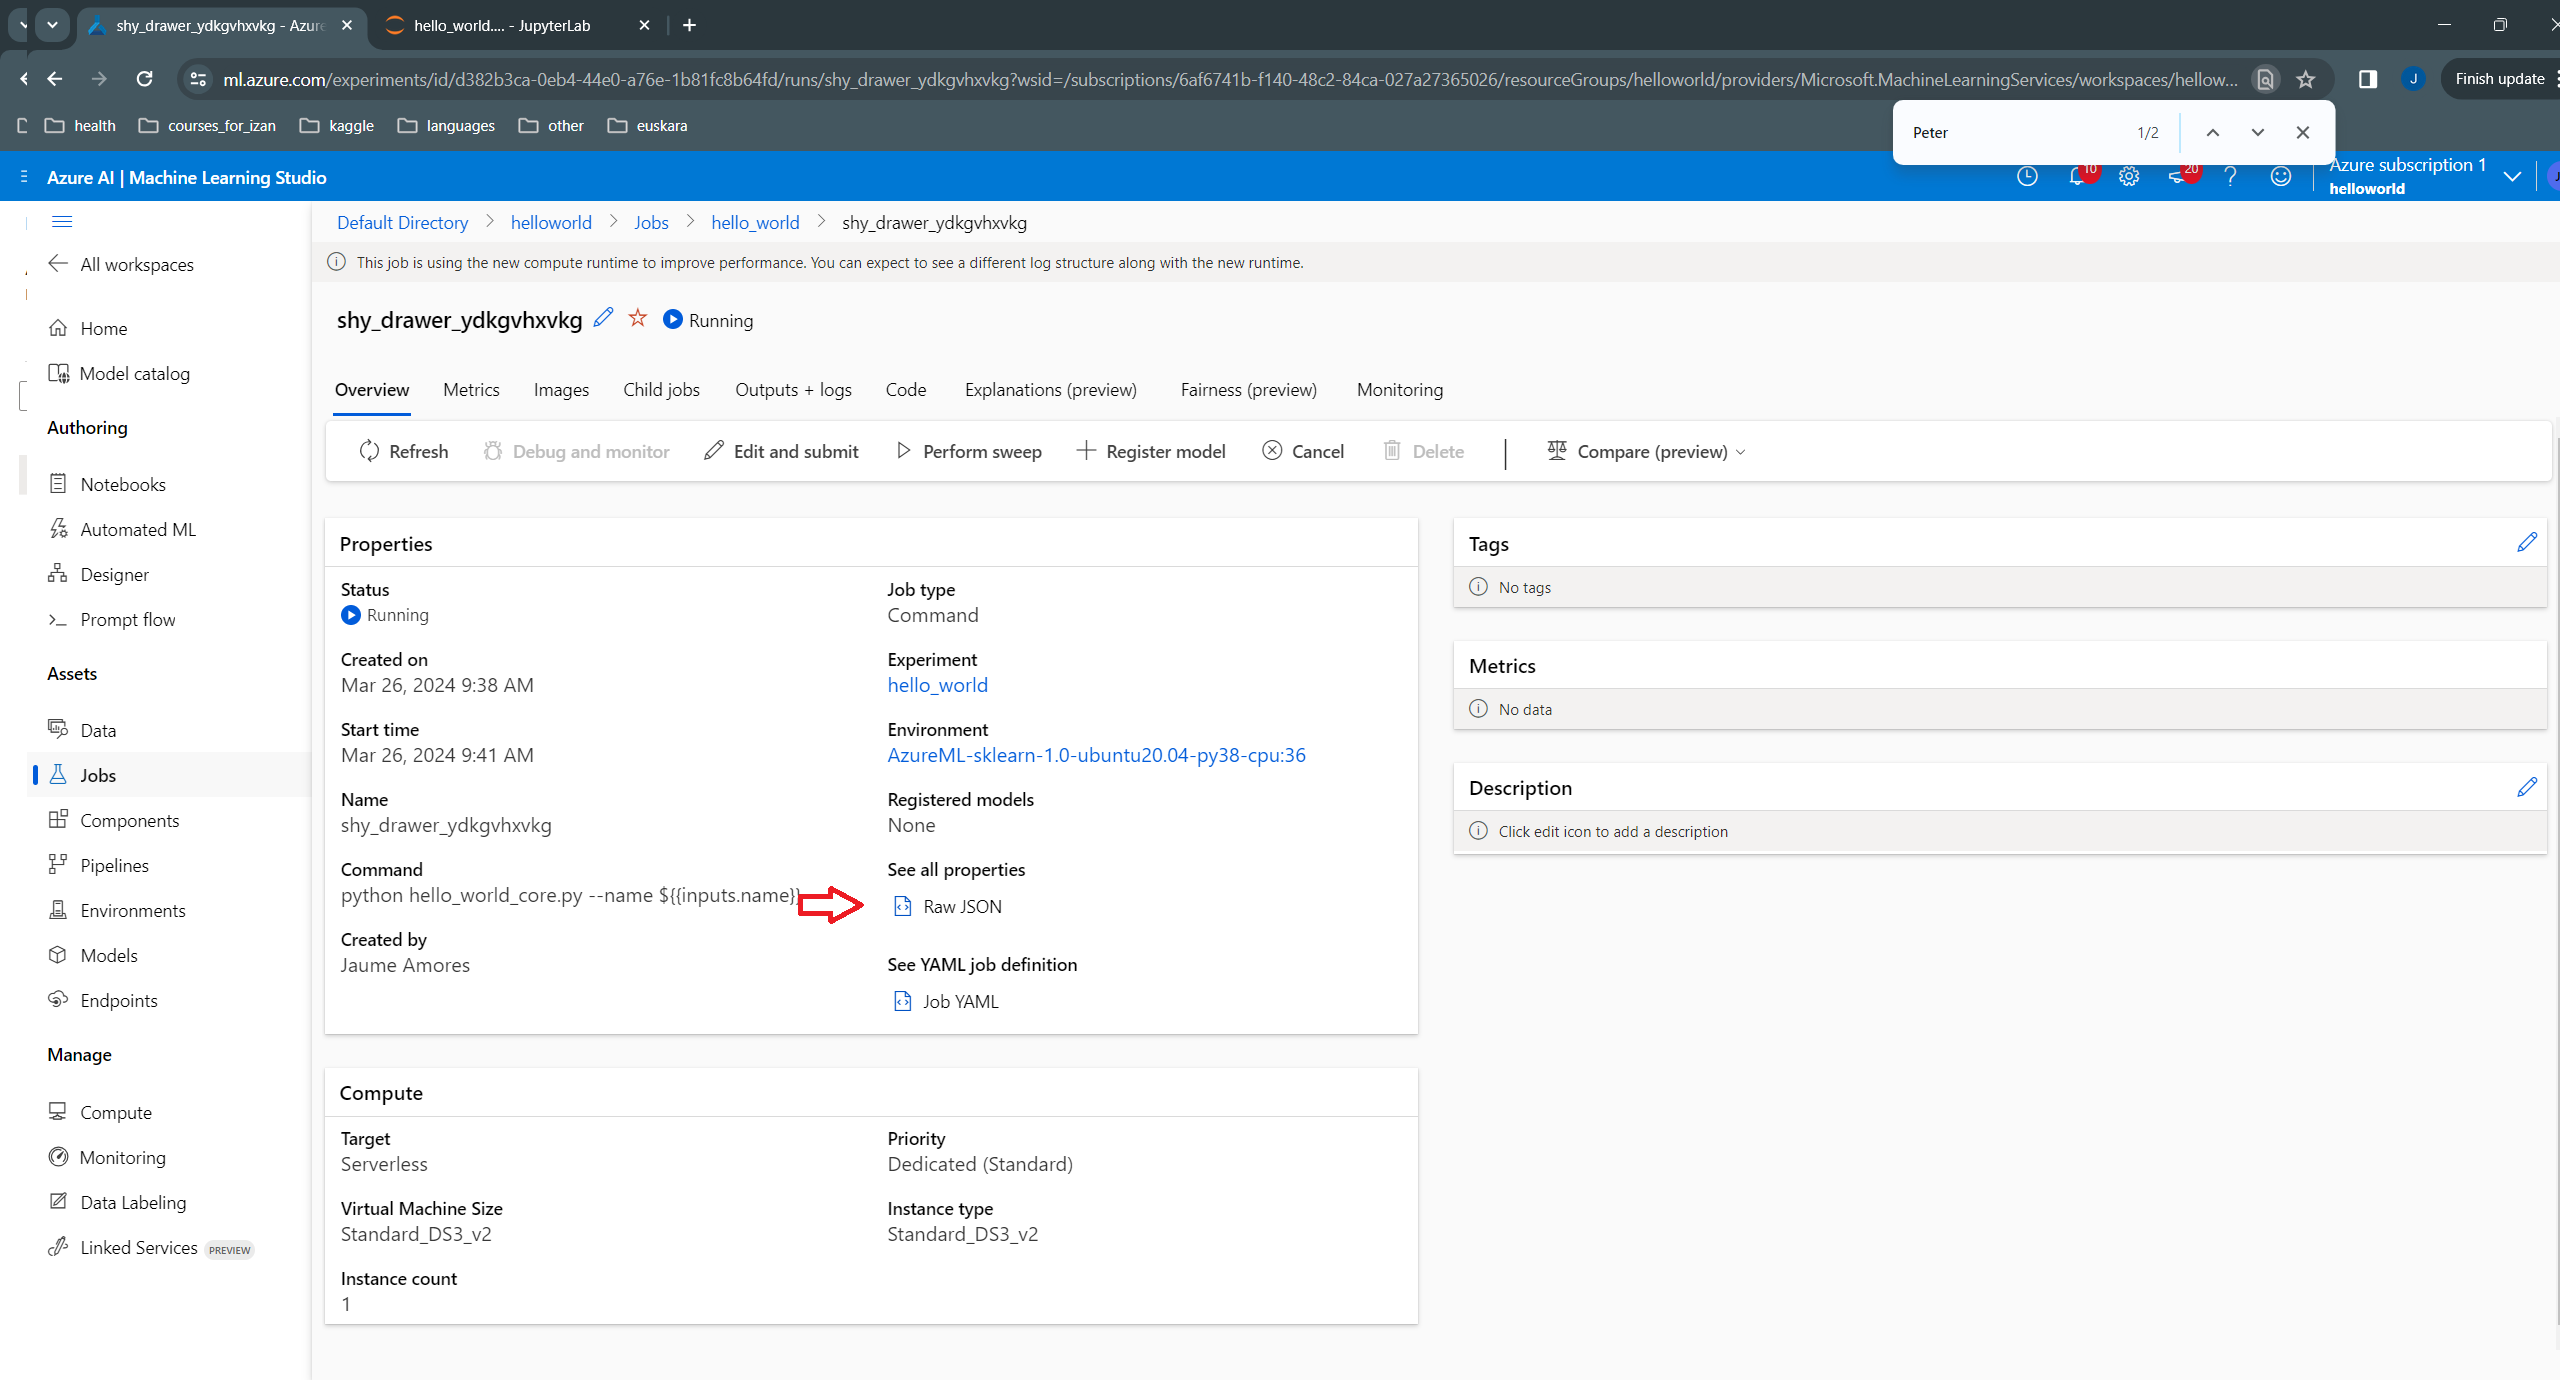

 ... and see that the new value (Peter) is used in its "parameters" dictionary:

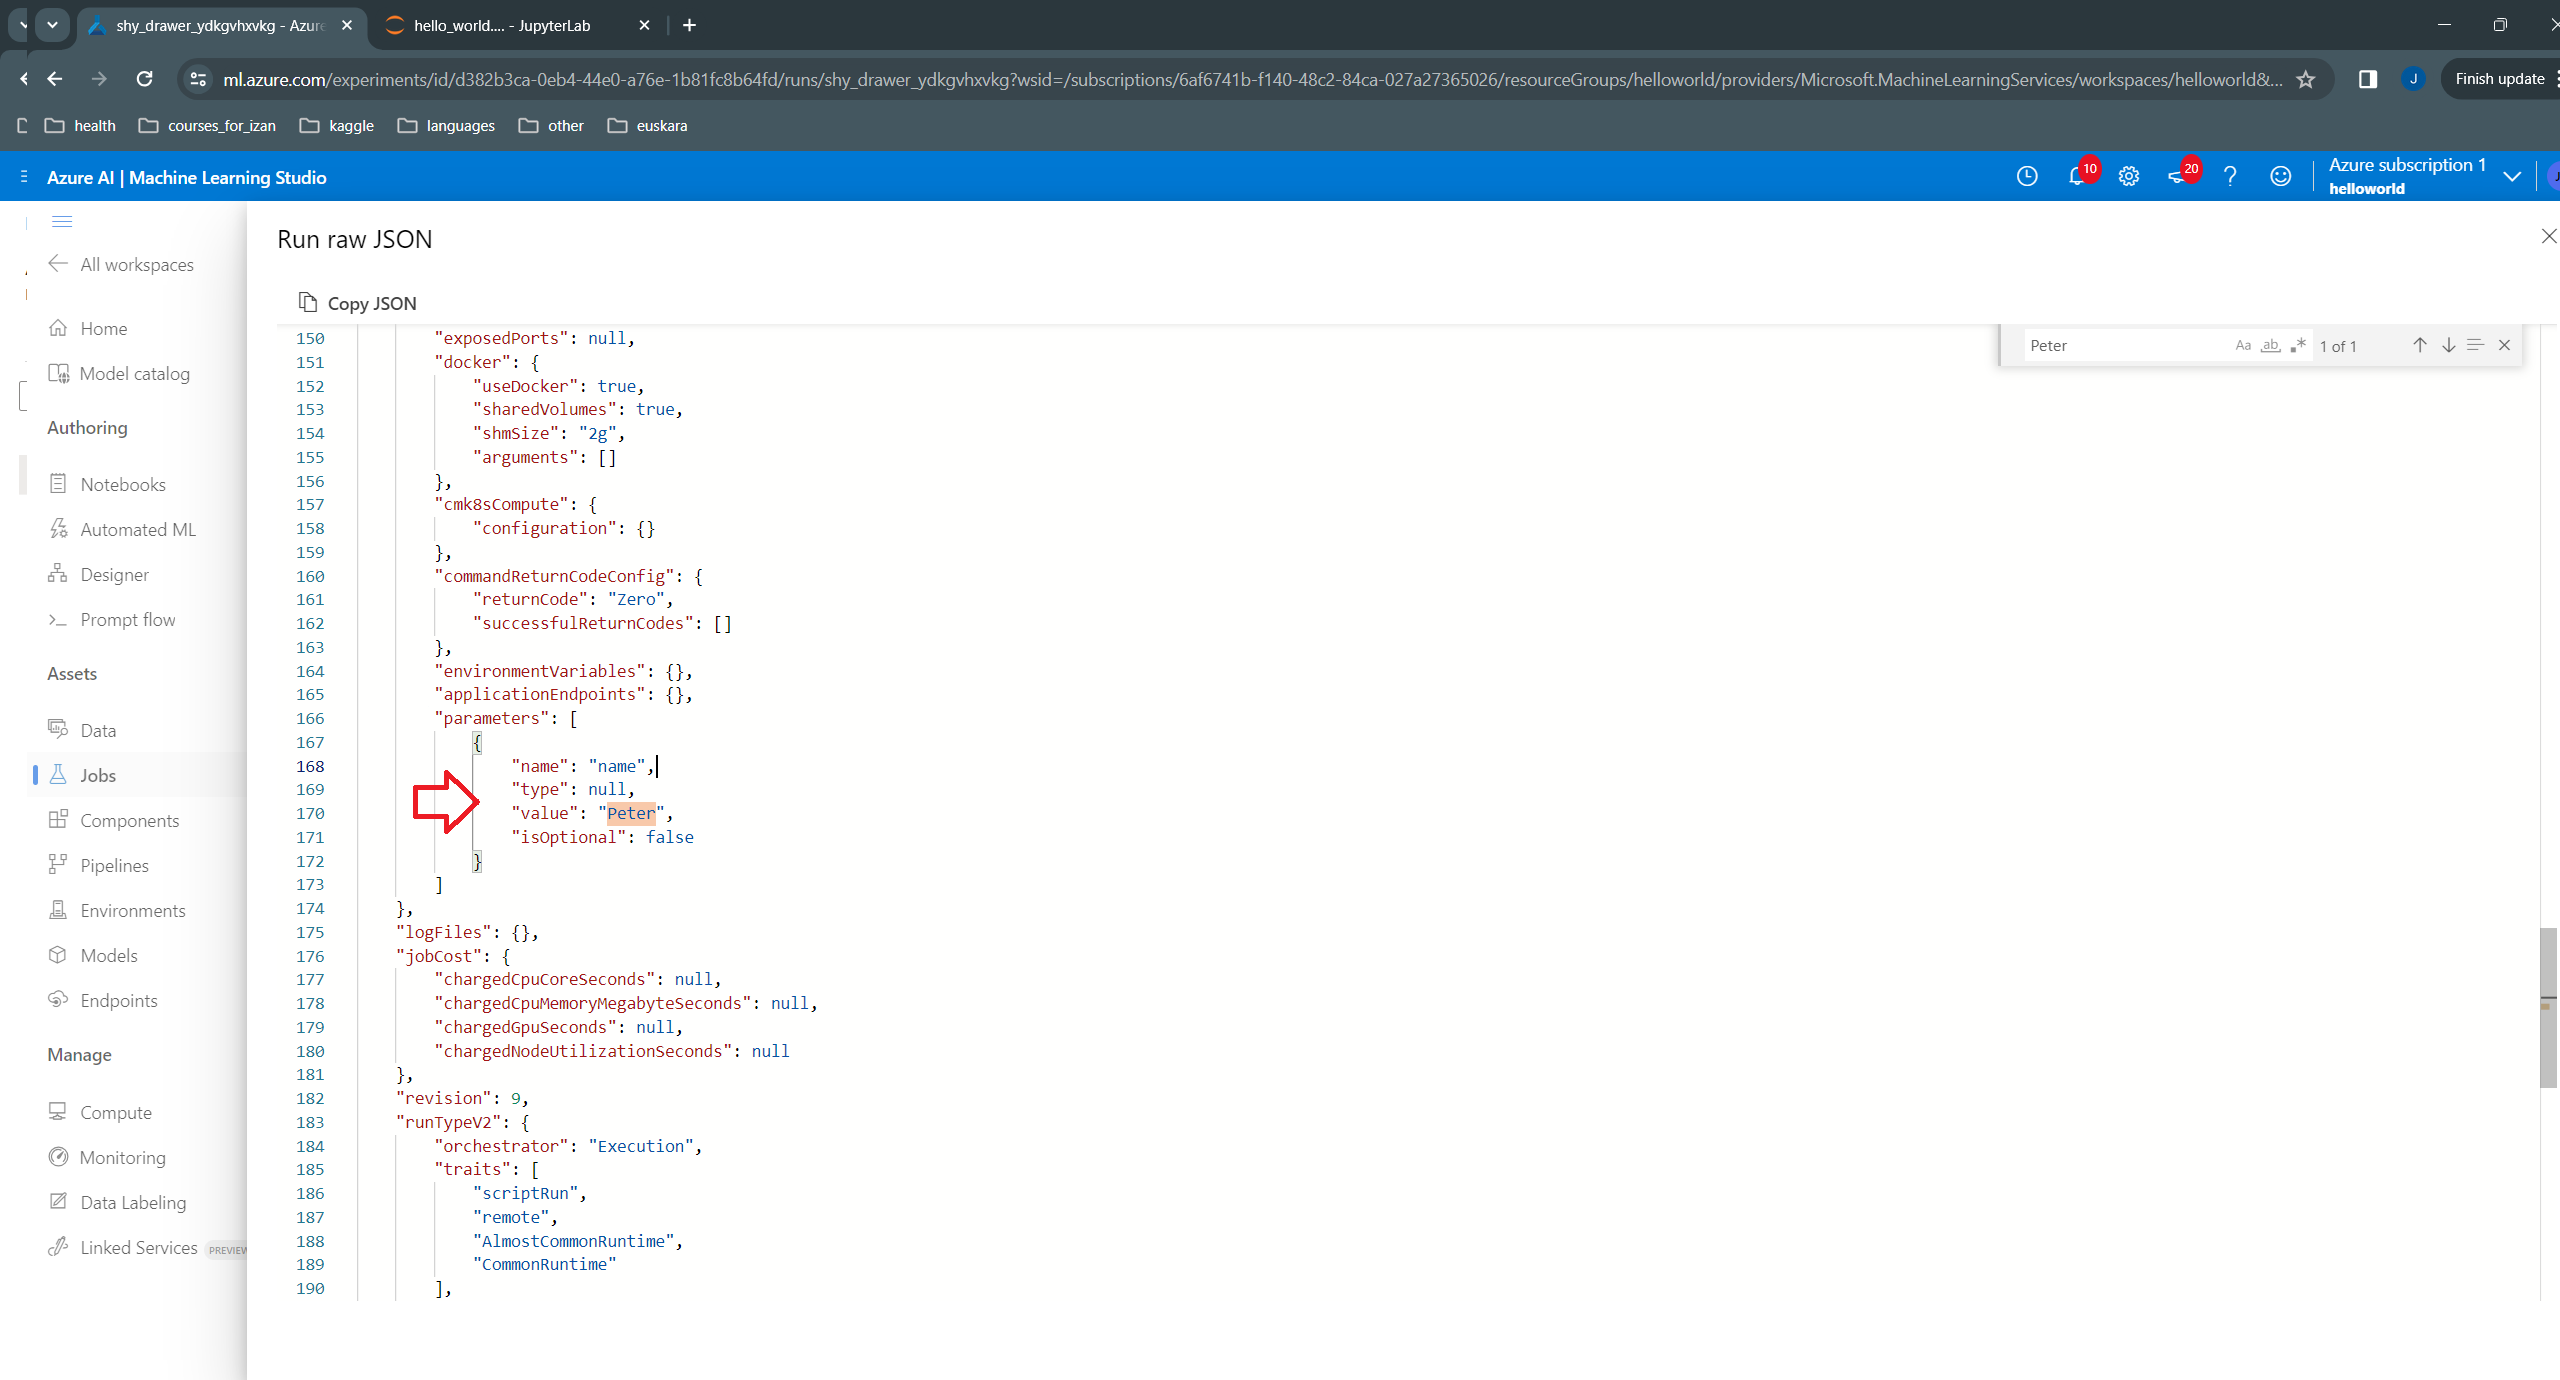

The std_log.txt for this job shows the new message with Peter:

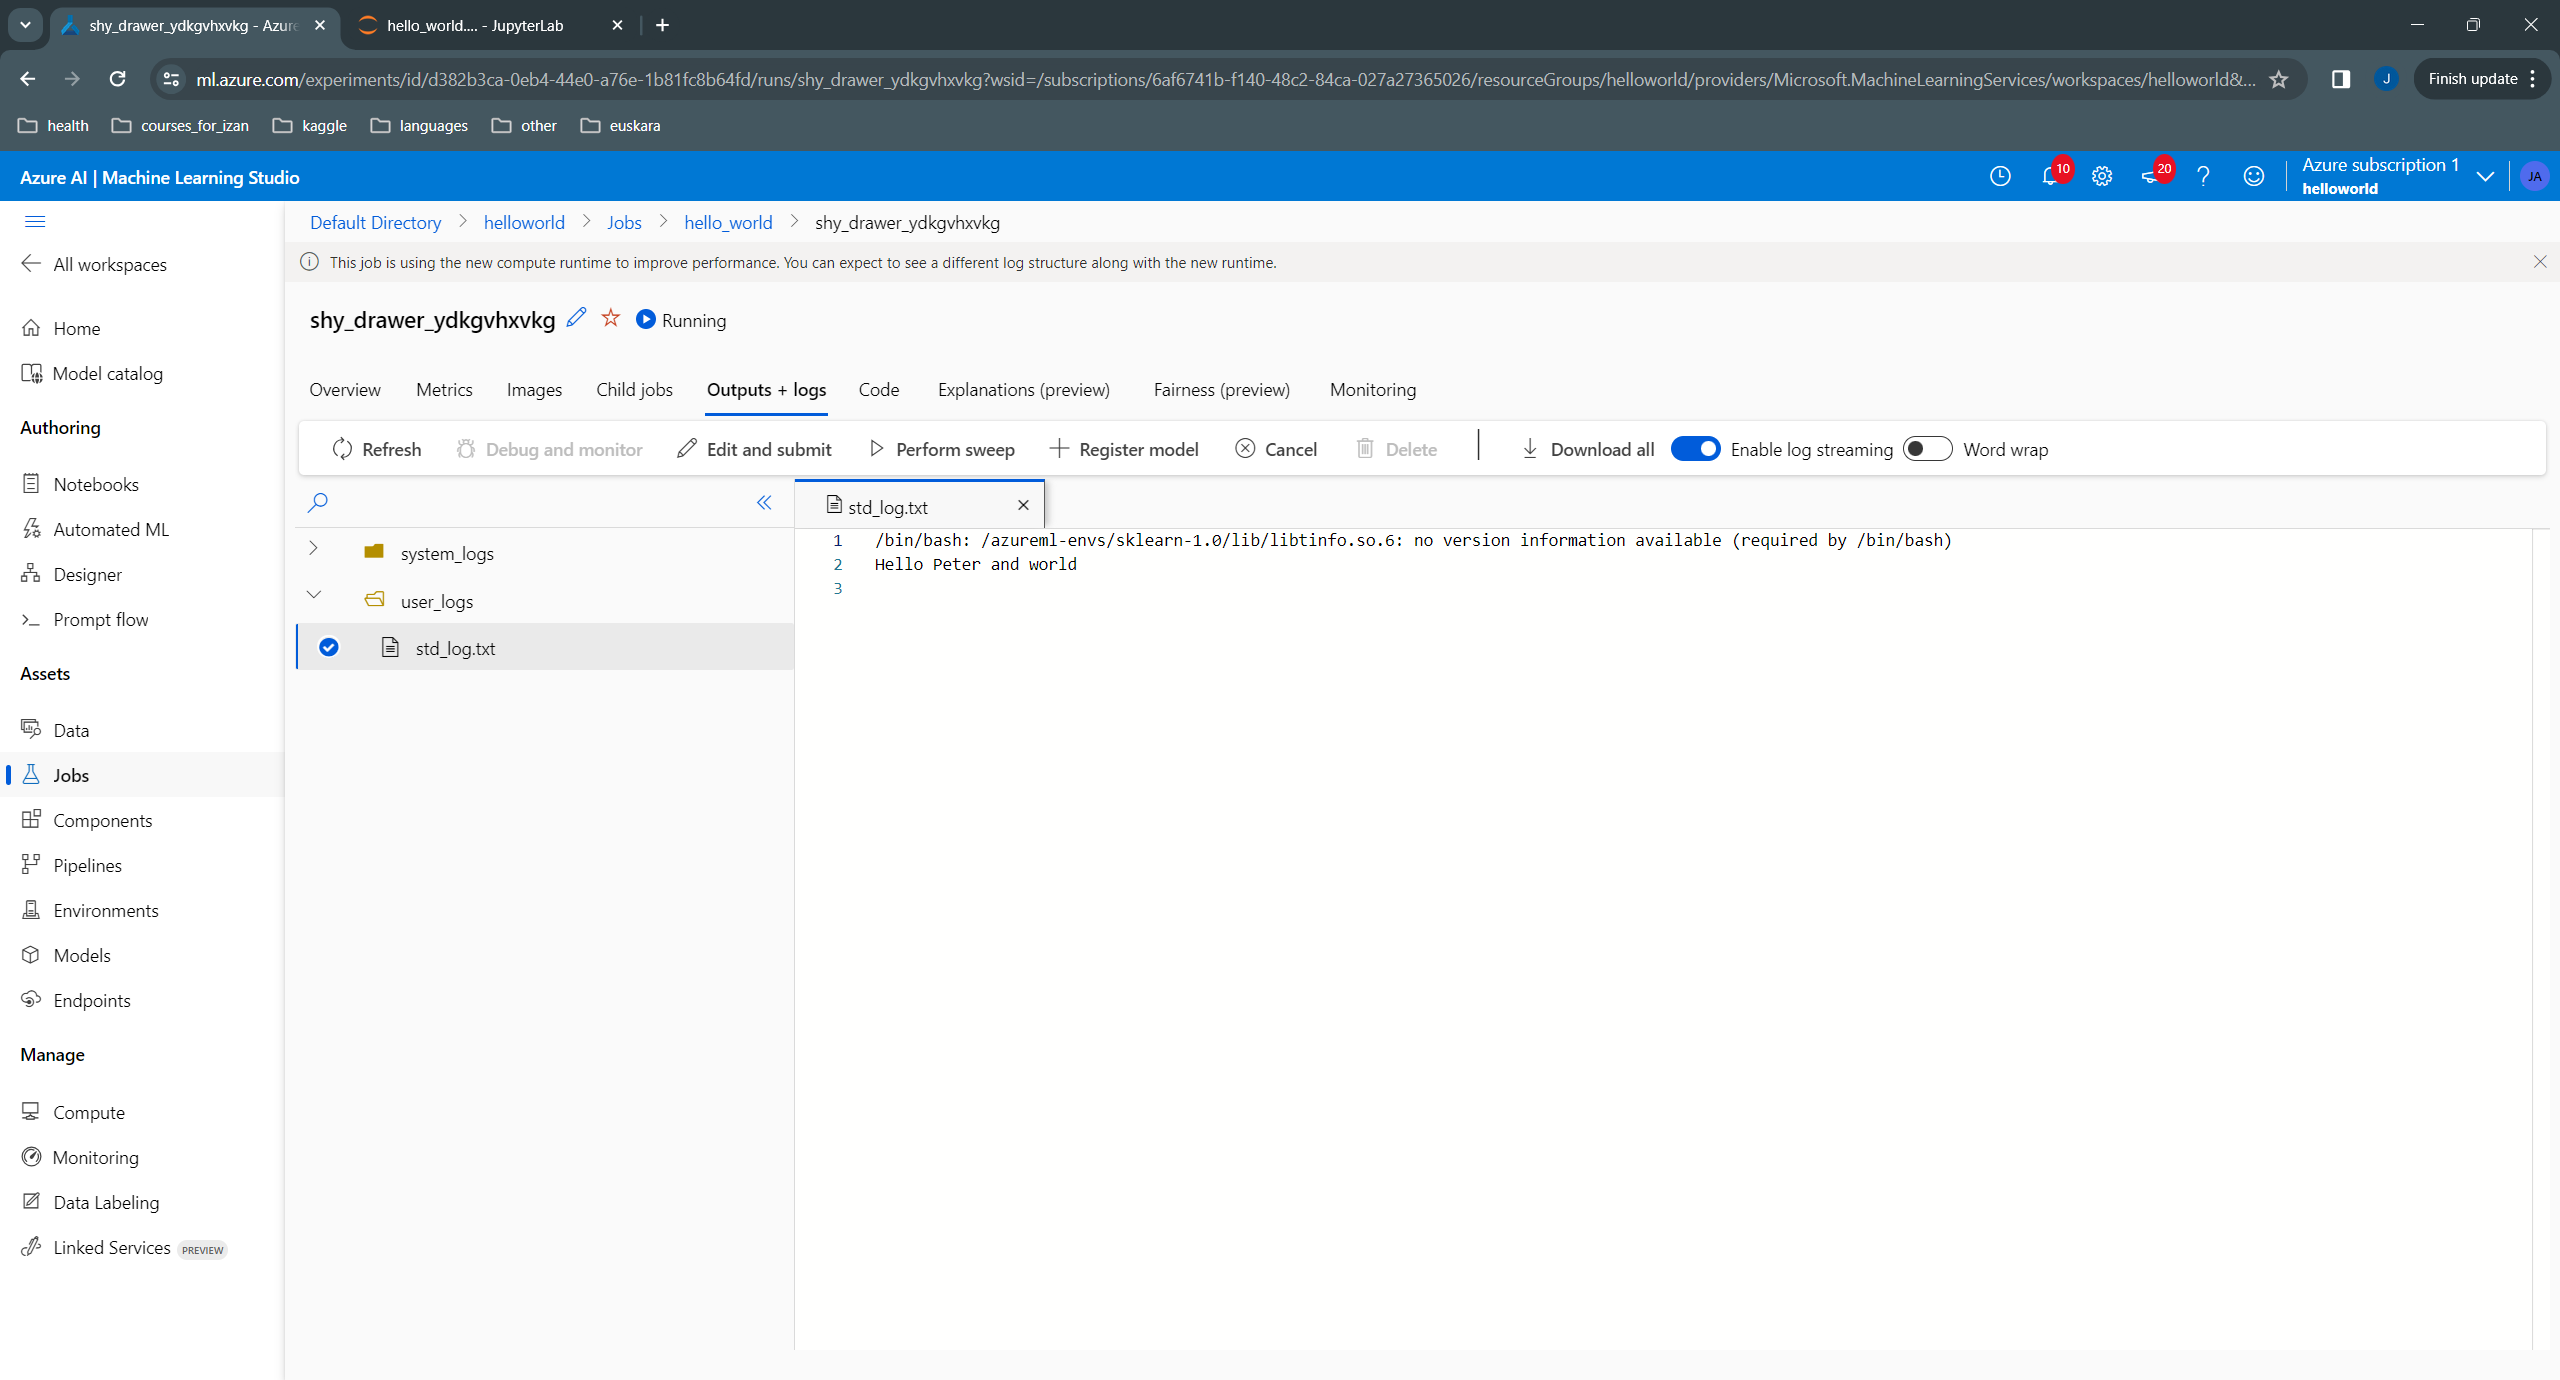

## Creating single component pipeline

In [ ]:
hello_world_component = ml_client.create_or_update(job.component)

Uploading hello_world (8.58 MBs): 100%|██████████| 8578531/8578531 [00:00<00:00, 21700197.27it/s]




In [ ]:
# the dsl decorator tells the sdk that we are defining an Azure Machine Learning pipeline
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline",
)
def hello_world_pipeline(
    pipeline_job_input: str,
):
    """
    Hello World pipeline
    
    Parameters
    ----------
    pipeline_job_input: str
        Input to pipeline, here name of person to greed.
    """
    # using data_prep_function like a python call with its own inputs
    hello_world_job = hello_world_component(
        name=pipeline_job_input,
    )

In [ ]:
# Let's instantiate the pipeline with the parameters of our choice
pipeline = hello_world_pipeline(
    pipeline_job_input="David",
)

In [ ]:
pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name="e2e_registered_components",
)
ml_client.jobs.stream(pipeline_job.name)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


RunId: shy_cabbage_xb9vv4fswl
Web View: https://ml.azure.com/runs/shy_cabbage_xb9vv4fswl?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-26 14:08:19Z] Submitting 1 runs, first five are: 605cf9a7:d9904e2d-3ecb-4ddc-a04d-e2fed4facfe6
[2024-03-26 14:12:40Z] Completing processing run id d9904e2d-3ecb-4ddc-a04d-e2fed4facfe6.

Execution Summary
RunId: shy_cabbage_xb9vv4fswl
Web View: https://ml.azure.com/runs/shy_cabbage_xb9vv4fswl?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld



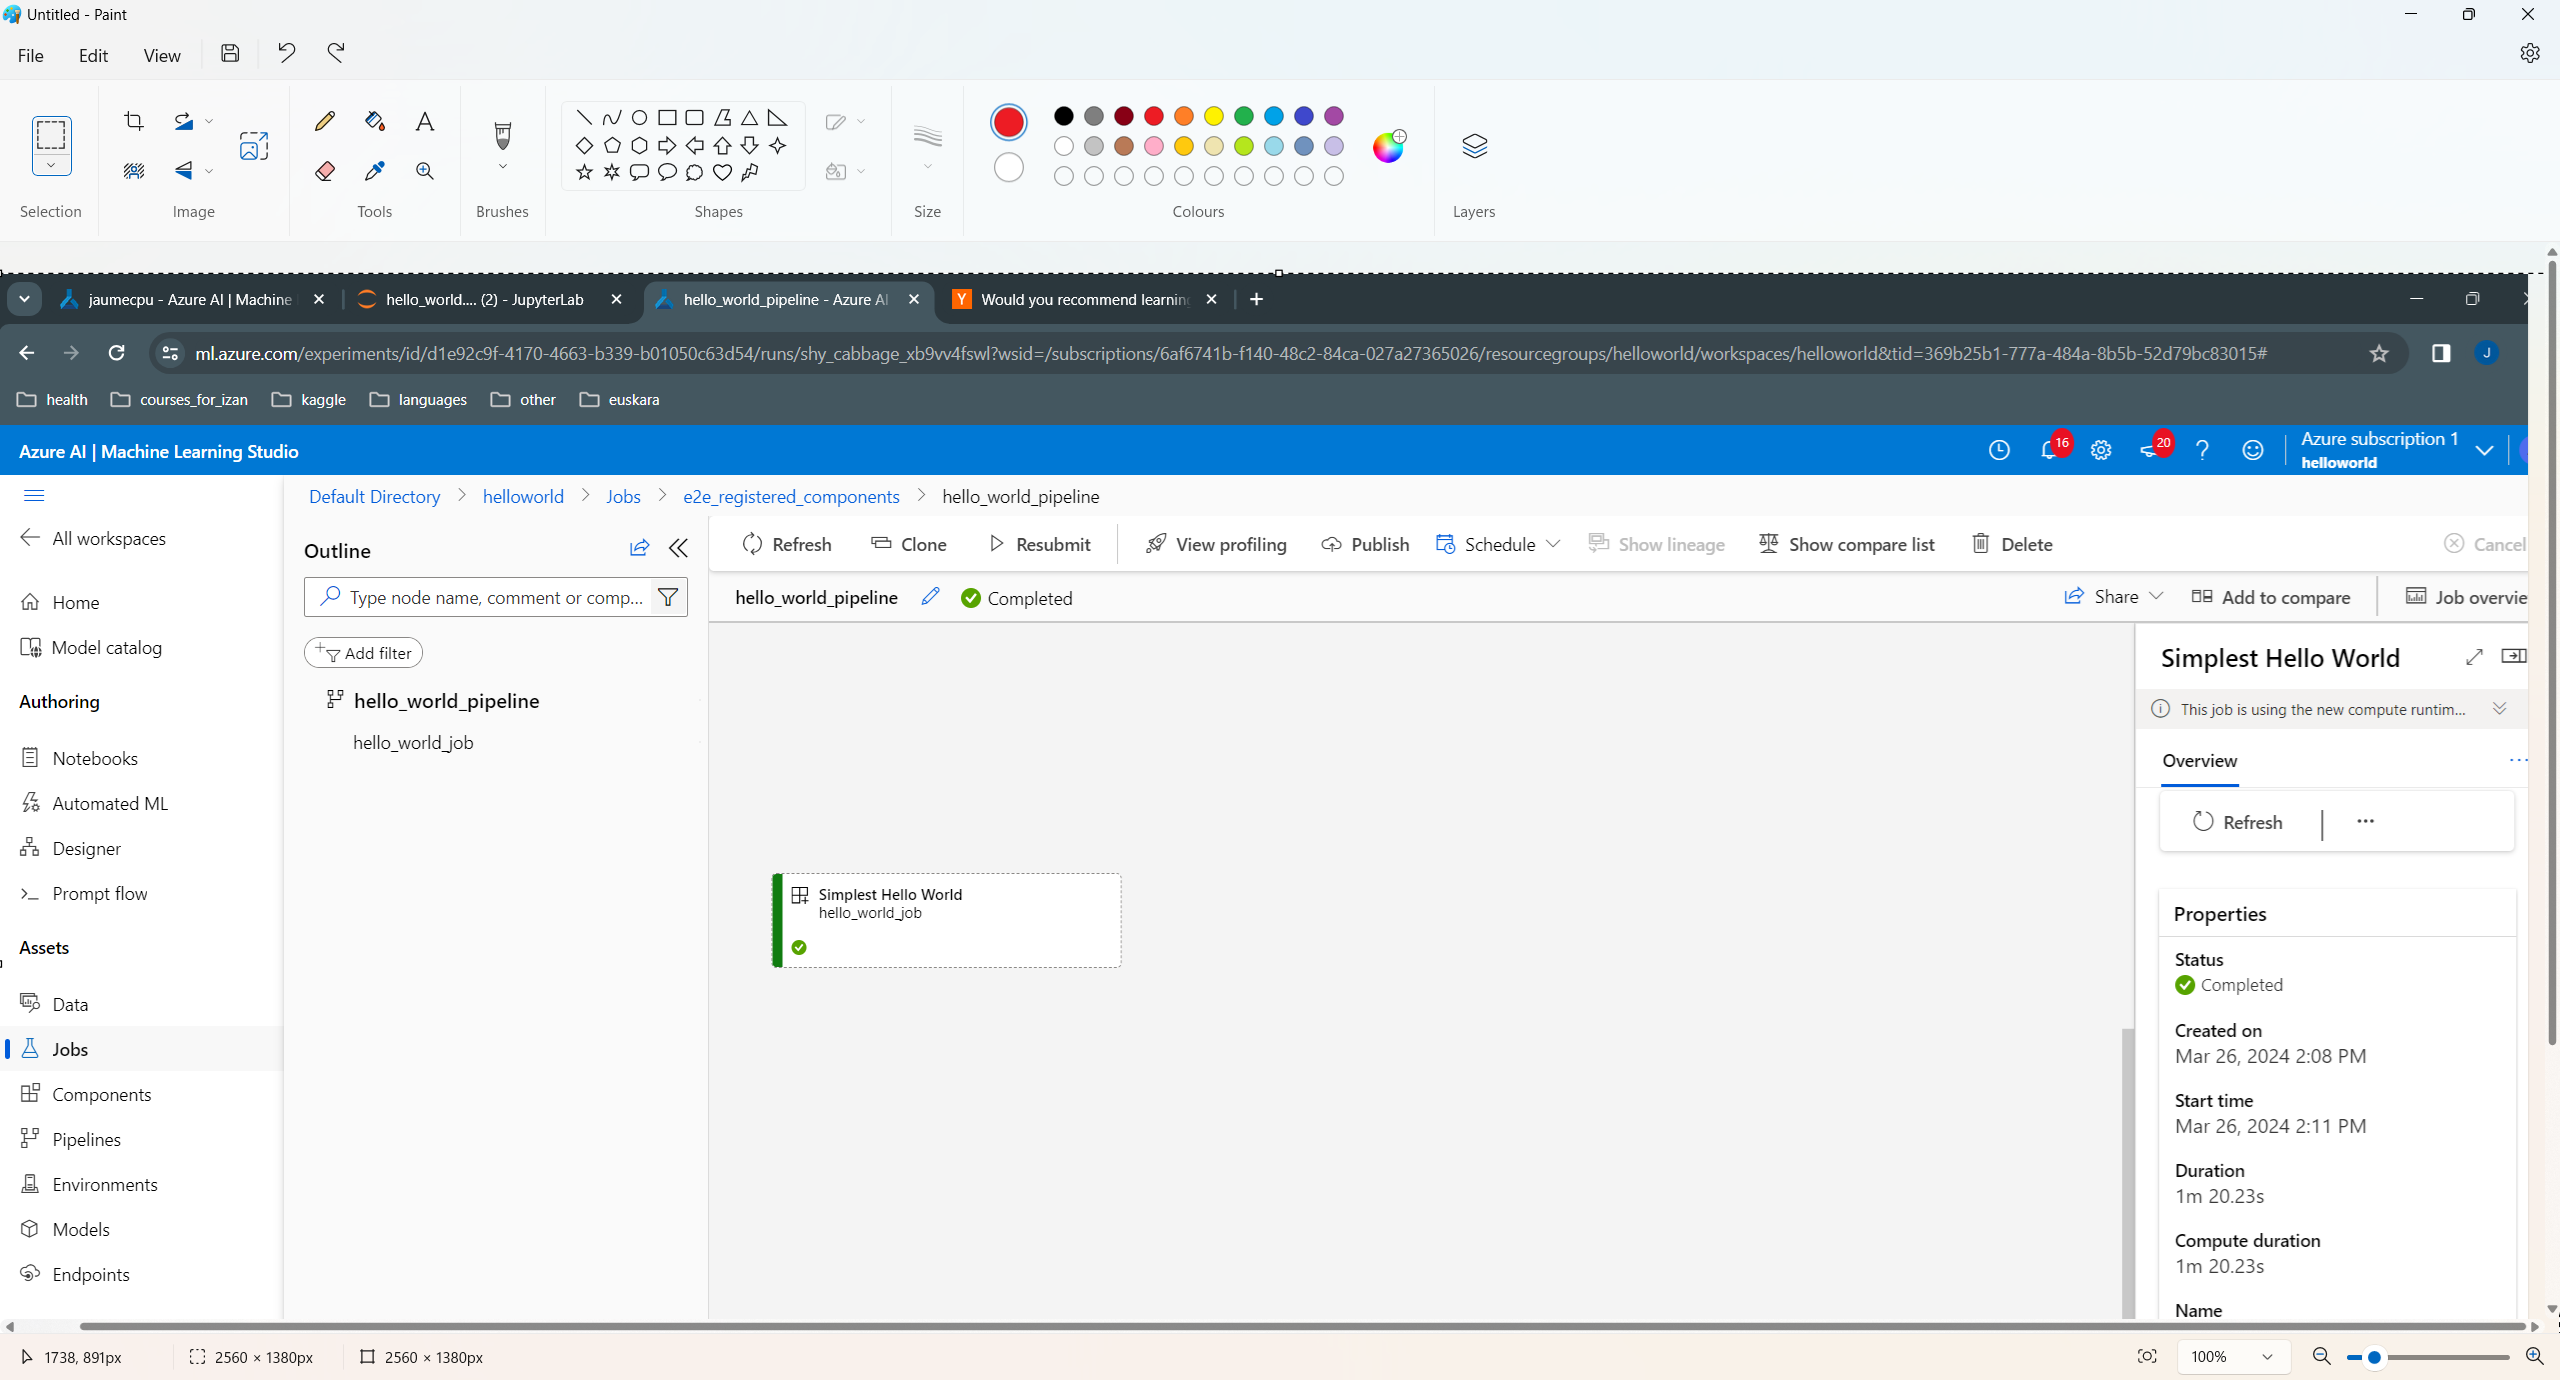

### Adding an input

In [ ]:
job = command(
    inputs=dict(
        name=Input (type="string"),
    ),
    code=f"./",  # location of source code: in this case, the root folder
    command="python hello_world_core.py --name ${{inputs.name}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Hello World witn Input",
)

hello_world_component = ml_client.create_or_update(job.component)

Uploading hello_world (8.59 MBs): 100%|██████████| 8589758/8589758 [00:00<00:00, 24178345.78it/s]




In [ ]:
# the dsl decorator tells the sdk that we are defining an Azure Machine Learning pipeline
from azure.ai.ml import dsl

@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def hello_world_pipeline(
    pipeline_job_input: str,
):
    """
    Hello World pipeline
    
    Parameters
    ----------
    pipeline_job_input: str
        Input to pipeline, here name of person to greed.
    """
    # using data_prep_function like a python call with its own inputs
    hello_world_job = hello_world_component(
        name=pipeline_job_input,
    )

In [ ]:
pipeline = hello_world_pipeline(
    pipeline_job_input="Joseph",
)

pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name="e2e_hello_world_with_input",
)
ml_client.jobs.stream(pipeline_job.name)

RunId: olive_plastic_gvnjy01b5s
Web View: https://ml.azure.com/runs/olive_plastic_gvnjy01b5s?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-26 14:38:43Z] Submitting 1 runs, first five are: cd1599c4:ce24c41e-946d-48cd-99b2-70ebde3befb2
[2024-03-26 14:44:58Z] Completing processing run id ce24c41e-946d-48cd-99b2-70ebde3befb2.

Execution Summary
RunId: olive_plastic_gvnjy01b5s
Web View: https://ml.azure.com/runs/olive_plastic_gvnjy01b5s?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld



Notes about Input:
    
- When using Input(type="uri_folder") or Input(type="uri_file"), the value passed cannot be a string, it must be an Input type, for example:
   
```python
job = command(
    inputs=dict(
        file_name=Input (type="uri_file"),
    ),
    ...
)

pipeline = hello_world_pipeline(
    pipeline_job_input=Input(path="/path/to/file"),
)
```

- However, when using Input(type="string") or Input(type="number"), the input must be a string or number, not Input
```python
job = command(
    inputs=dict(
        name=Input (type="string"),
    ),
    ...
)

pipeline = hello_world_pipeline(
    pipeline_job_input="Mary",
)
```

- In the latter case, the input does not appear in the graph of the pipeline, in the UI.

### Using uri_file as input

In [ ]:
# Component definition and registration
job = command(
    inputs=dict(
        name=Input (type="uri_file"),
    ),
    code=f"./",  # location of source code: in this case, the root folder
    command="python hello_world_core.py --name ${{inputs.name}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Hello World with uri_file",
)
hello_world_component = ml_client.create_or_update(job.component)

# Pipeline definition and registration
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def hello_world_pipeline(
    pipeline_job_input: str,
):
    """
    Hello World pipeline
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Input to pipeline, here path to file.
    """
    # using data_prep_function like a python call with its own inputs
    hello_world_job = hello_world_component(
        name=pipeline_job_input,
    )

pipeline = hello_world_pipeline(
    pipeline_job_input=Input(type="uri_file", path="./hello_world_core.py"),
)

pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name="e2e_hello_world_with_uri_file",
)

# Pipeline running
ml_client.jobs.stream(pipeline_job.name)

Uploading hello_world (8.59 MBs): 100%|██████████| 8588206/8588206 [00:00<00:00, 24482901.98it/s]


Uploading hello_world_core.py (< 1 MB): 0.00B [00:00, ?B/s] (< 1 MB): 100%|██████████| 514/514 [00:00<00:00, 12.0kB/s]




RunId: great_tail_pw48pry0lj
Web View: https://ml.azure.com/runs/great_tail_pw48pry0lj?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-26 15:06:11Z] Submitting 1 runs, first five are: a08118c5:2099b6ad-fb3a-4cac-9557-c8cf355b8b1b
[2024-03-26 15:11:50Z] Completing processing run id 2099b6ad-fb3a-4cac-9557-c8cf355b8b1b.

Execution Summary
RunId: great_tail_pw48pry0lj
Web View: https://ml.azure.com/runs/great_tail_pw48pry0lj?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld



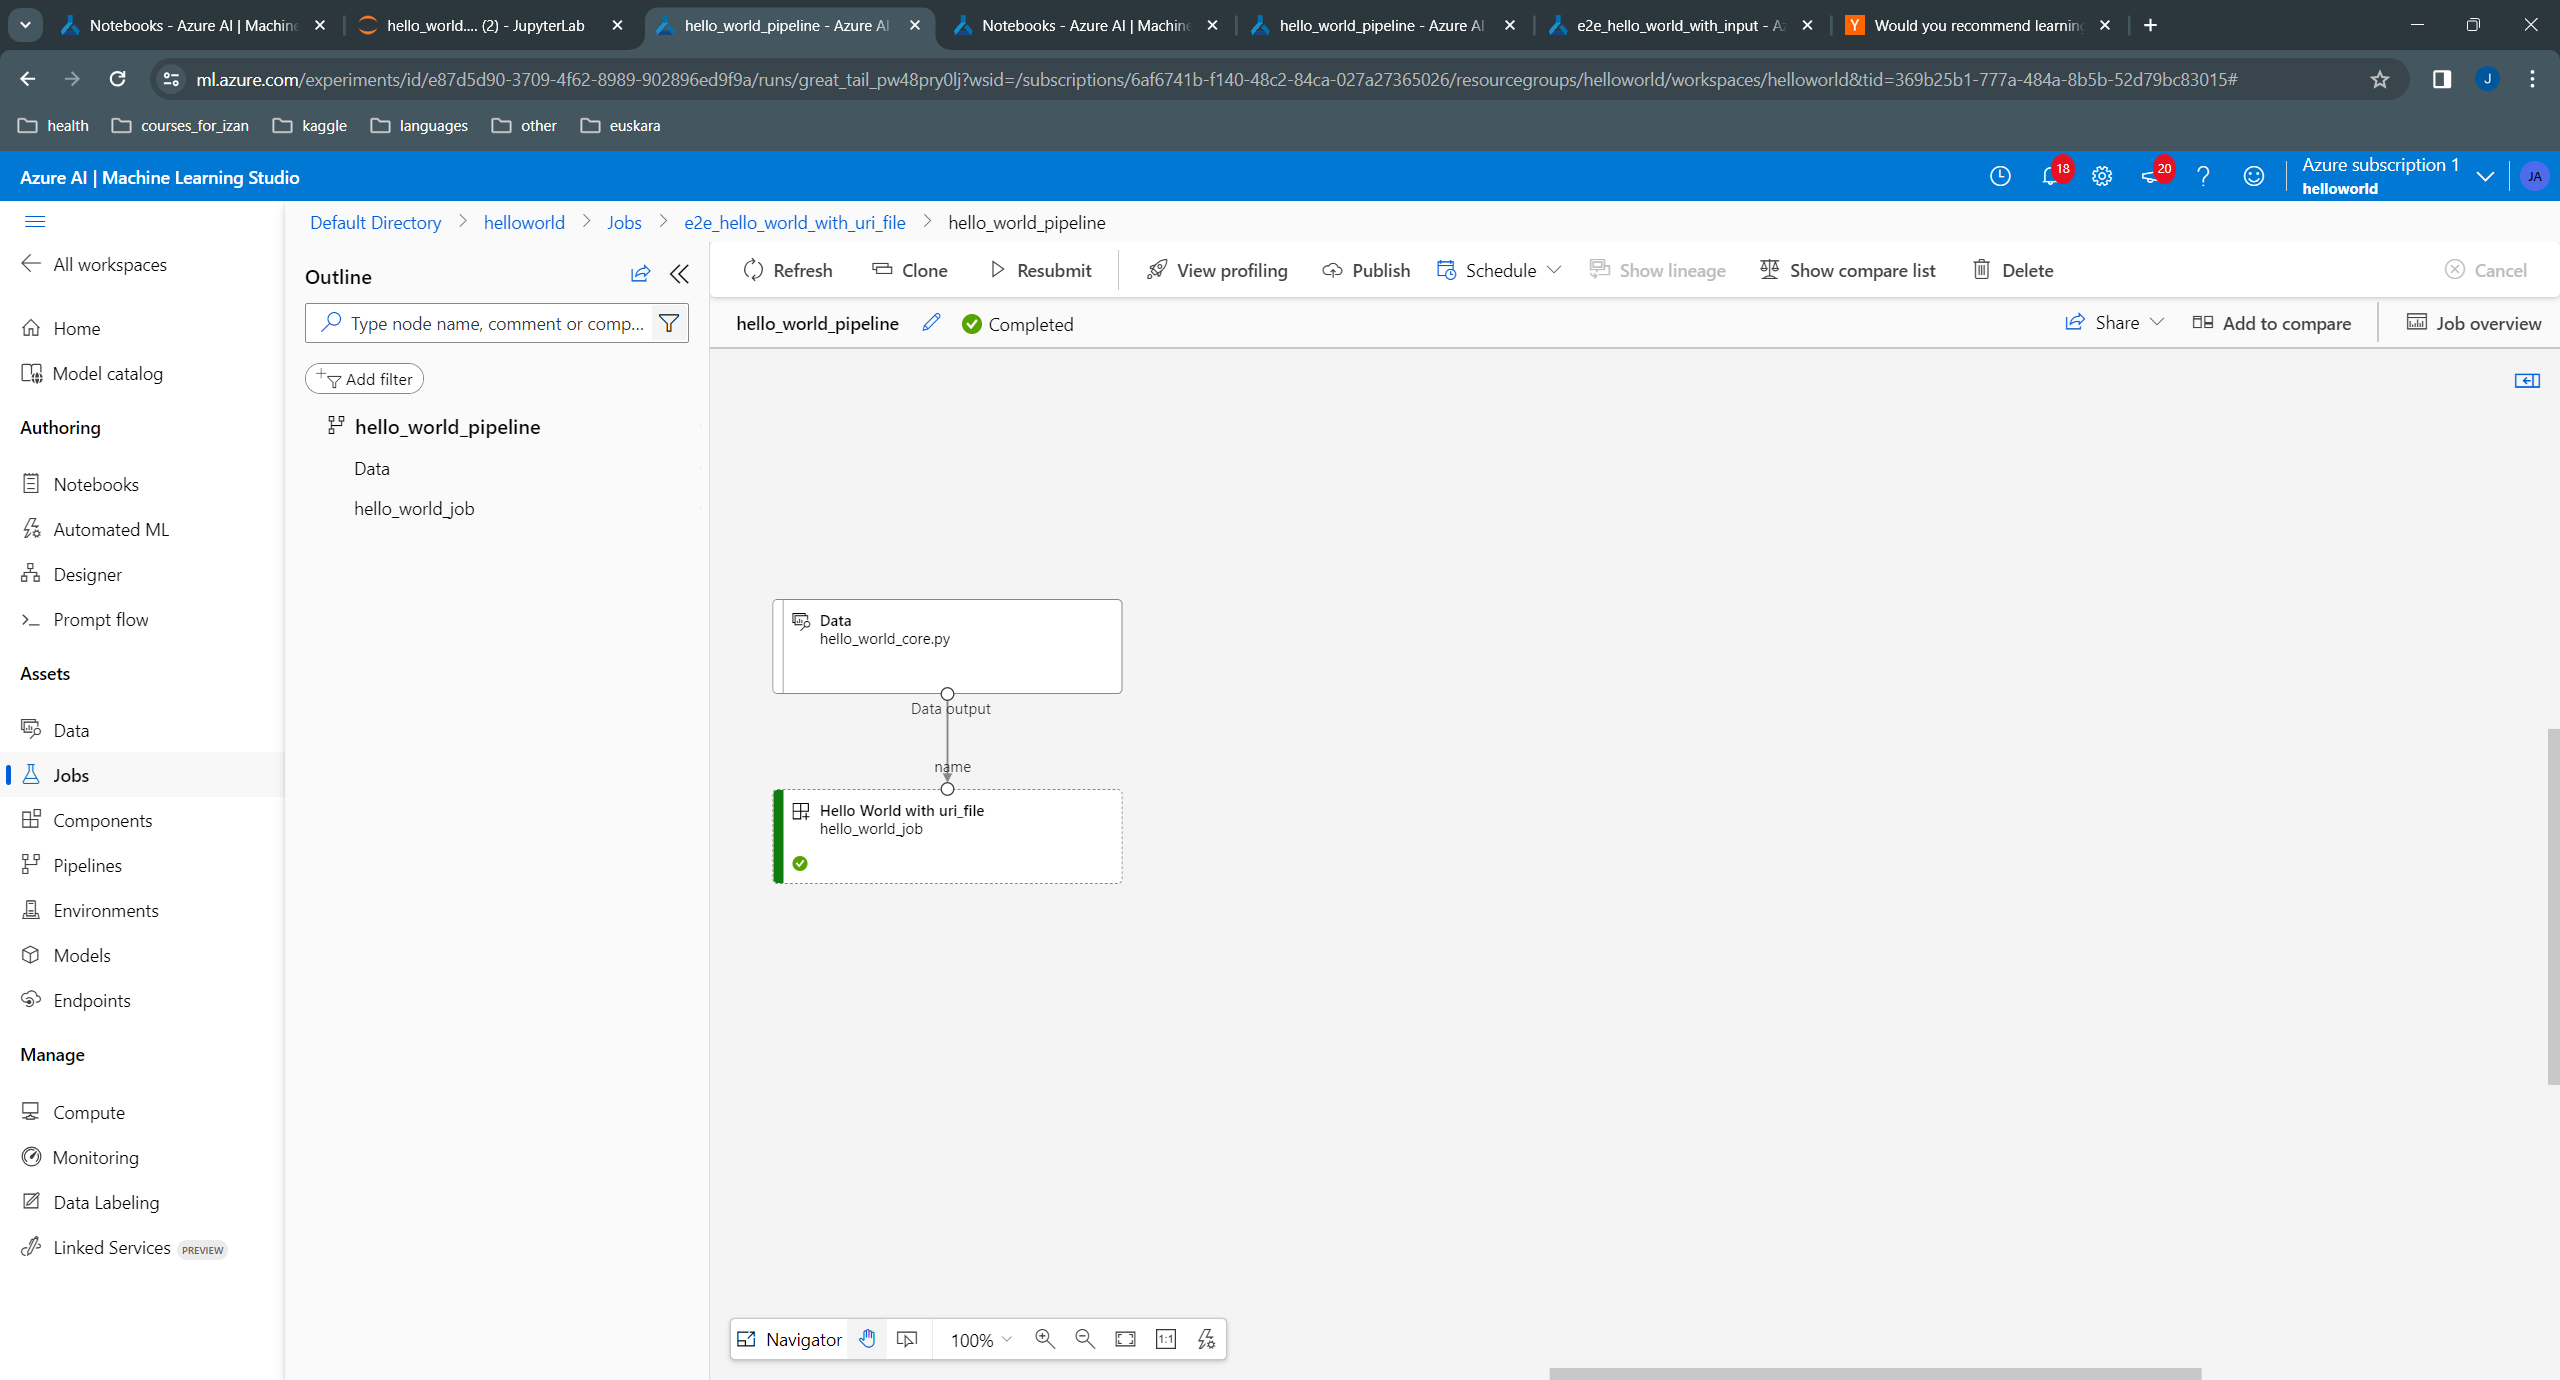

- If you click on the "Data" component and inside it click on "Explore", you can see the contents of the file, since it is a text python file.

### Adding an output

In [ ]:
# Component definition and registration
job = command(
    outputs=dict(
        name=Output (type="uri_file"),
    ),
    code=f"./",  # location of source code: in this case, the root folder
    command="python hello_world_core.py --name ${{outputs.name}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Hello World with uri_file as output",
)
hello_world_component = ml_client.create_or_update(job.component)

# Pipeline definition and registration
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def hello_world_pipeline(
):
    # using data_prep_function like a python call with its own inputs
    hello_world_job = hello_world_component()

pipeline = hello_world_pipeline()

pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name="e2e_hello_world_with_uri_file_as_output",
)

# Pipeline running
ml_client.jobs.stream(pipeline_job.name)

Uploading hello_world (9.48 MBs): 100%|██████████| 9483085/9483085 [00:00<00:00, 22969826.09it/s]




RunId: teal_soccer_m9bkcgz2gq
Web View: https://ml.azure.com/runs/teal_soccer_m9bkcgz2gq?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-26 15:36:23Z] Submitting 1 runs, first five are: 528b20ac:27e32a0a-71a0-4bc3-abec-eaeae70ff08e
[2024-03-26 15:41:30Z] Completing processing run id 27e32a0a-71a0-4bc3-abec-eaeae70ff08e.

Execution Summary
RunId: teal_soccer_m9bkcgz2gq
Web View: https://ml.azure.com/runs/teal_soccer_m9bkcgz2gq?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld



## Pipeline with two components

In order to have something more meaningful, we create a pipeline with two components. The first one "pre-processes" the input data frame by adding one (or a specified number) to it, storing the output as a csv file. The second component builds a "model" by calculating the mean and standard deviation, and saves it as pickle file.

### Make subfolders and create dummy data

Whenever we have multiple components, a common practice in Azure ML is to have a dedicated subfolder for each one. The subfolder contains the source .py file implementing the component, and may contain a conda yaml file with dependencies that are specific for this component. In our case, we use a pre-built environment so that we don't need to include any conda yaml file.

In [12]:
os.makedirs ("preprocessing", exist_ok=True)
os.makedirs ("training", exist_ok=True)
os.makedirs ("data", exist_ok=True)

In [13]:
df = pd.DataFrame (
    {
        "a": [1,2,3],
        "b": [4,5,6],
    },
)

df.to_csv ("data/dummy_input.csv")

### Preprocessing component

In [14]:
%%writefile preprocessing/preprocessing.py
import argparse
import pandas as pd

def preprocessing (df, x):
    """Adds `x` to input data frame `df`."""
    
    print ("Input\n", df)
    print (f"Adding {x} to df")
    df = df + x
    print ("Output\n", df)
    return df

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str, help="path to input data frame")
    parser.add_argument("--preprocessed_data", type=str, help="path to output data frame")
    parser.add_argument("-x", type=int, help="number to add")
    args = parser.parse_args()
    
    return args

def read_and_preprocess (
    input_data,
    x,
    preprocessed_data,
):
    df = pd.read_csv (input_data, index_col=0)
    df = preprocessing (df, x)
    df.to_csv (preprocessed_data)
    
def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_preprocess (args.input_data, args.x, args.preprocessed_data)

if __name__ == "__main__":
    main()

Overwriting preprocessing/preprocessing.py


In [15]:
# Component definition and registration
preprocessing_command = command(
    inputs=dict(
        input_data=Input (type="uri_file"),
        x=Input (type="number"),
    ),
    outputs=dict(
        preprocessed_data=Output (type="uri_file"),
    ),
    code=f"./preprocessing/",  # location of source code: in this case, the root folder
    command="python preprocessing.py --input_data ${{inputs.input_data}} -x ${{inputs.x}} --preprocessed_data ${{outputs.preprocessed_data}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Pre-processing",
)
preprocessing_component = ml_client.create_or_update(preprocessing_command.component)

### Training component

In [16]:
%%writefile training/training.py
import argparse
import joblib
import pandas as pd

def train_model (df: pd.DataFrame):
    """Trains a dummy Gaussian model from training set df."""
    
    print ("Input\n", df)
    mu = df.mean().values
    std = df.std().values
    print ("mu:\n", mu)
    print ("std:\n", std)
    return mu, std

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--preprocessed_data", type=str, help="path to preprocessed data")
    parser.add_argument("--model", type=str, help="path to built model")
    args = parser.parse_args()
    
    return args

def read_and_train (
    preprocessed_data: str,
    model_path: str,
):
    """Reads training data, trains model, and saves it."""
    df = pd.read_csv (preprocessed_data, index_col=0)
    model = train_model (df)
    joblib.dump (model, model_path)

def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_train (args.preprocessed_data, args.model)

if __name__ == "__main__":
    main()

Overwriting training/training.py


In [17]:
# Component definition and registration
training_command = command(
    inputs=dict(
        preprocessed_data=Input (type="uri_file"),
    ),
    outputs=dict(
        model=Output (type="uri_file"),
    ),
    code=f"./training/",  # location of source code: in this case, the root folder
    command="python training.py --preprocessed_data ${{inputs.preprocessed_data}} --model ${{outputs.model}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Training",
)

training_component = ml_client.create_or_update(training_command.component)

Uploading training (0.0 MBs): 100%|██████████| 1043/1043 [00:00<00:00, 112778.01it/s]




### Testing the pipeline

Before submitting the pipeline job, it is very important to test it first, ideally with some dummy or small dataset. For this purpose, in the component implementation above, we have separated the code related with argument parsing and the rest of the code, which is in encapsulated in a function called `read_and_<...>`. This way, we can easily write a test pipeline before implementing the final one, as follows:

In [18]:
# We will need to change the code as we iteratively refine it 
# while testing the pipeline. For that purpose, we use the 
# reload module
from importlib import reload 
from preprocessing import preprocessing
from training import training

reload (preprocessing)
reload (training)

def test_pipeline (
    pipeline_job_data_input: str,
    pipeline_job_x: int,
    pipeline_job_preprocess_output: str,
    pipeline_job_model_output: str,
):
    """
    Tests two component pipeline with preprocessing and training.
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Path to input data *file*
    pipeline_job_x: int
        Integer to add to input data to convert it to "preprocessed" data.
    pipeline_job_test_input: str
        Path to (preprocessed) test input *file*
    pipeline_job_preprocess_output: str
        Path to preprocessed data *file*, to be used as training.
        Not present in the final pipeline.
    pipeline_job_model_output: str
        Path to model *file*. Not present in the final pipeline.
    """
    preprocessing.read_and_preprocess (
        pipeline_job_data_input,
        pipeline_job_x,
        pipeline_job_preprocess_output,
    )
    training.read_and_train (
        pipeline_job_preprocess_output,
        pipeline_job_model_output,
    )

os.makedirs ("test_pipeline", exist_ok=True)

test_pipeline (
    pipeline_job_data_input="./data/dummy_input.csv",
    pipeline_job_x=10,
    pipeline_job_preprocess_output="./test_pipeline/preprocessed_data.csv",
    pipeline_job_model_output="./test_pipeline/model.pk"
)

Input
    a  b
0  1  4
1  2  5
2  3  6
Adding 10 to df
Output
     a   b
0  11  14
1  12  15
2  13  16
Input
     a   b
0  11  14
1  12  15
2  13  16
mu:
 [12. 15.]
std:
 [1. 1.]


### Pipeline

Now we are ready to implement and submit our pipeline. The code will be very similar to the `test_pipeline` implemented above, except for the fact that we don't need to indicate the outputs that connect one component to the next, since these are automatically populated by AML.

In [22]:
# Pipeline definition and registration
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def two_components_pipeline(
    pipeline_job_data_input: str,
    pipeline_job_x: int,
):
    """
    Pipeline with two components: preprocessing, and training.
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Path to input data *file*
    pipeline_job_x: int
        Integer to add to input data to convert it to "preprocessed" data.
    """
    # using data_prep_function like a python call with its own inputs
    preprocessing_job = preprocessing_component(
        input_data=pipeline_job_data_input,
        x=pipeline_job_x,
    )

    # using train_func like a python call with its own inputs
    training_job = training_component(
        preprocessed_data=preprocessing_job.outputs.preprocessed_data,  # note: using outputs from previous step
    )

two_components_pipeline = two_components_pipeline(
    pipeline_job_data_input=Input(type="uri_file", path="./data/dummy_input.csv"),
    pipeline_job_x=10,
)

two_components_pipeline_job = ml_client.jobs.create_or_update(
    two_components_pipeline,
    # Project's name
    experiment_name="e2e_two_components_pipeline",
)

# Pipeline running
ml_client.jobs.stream(two_components_pipeline_job.name)

RunId: quiet_root_nb0c997gsp
Web View: https://ml.azure.com/runs/quiet_root_nb0c997gsp?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-27 10:45:01Z] Submitting 1 runs, first five are: caf1c51e:87b5910c-0e8d-4ca0-a808-f52a94d52b56
[2024-03-27 10:51:05Z] Completing processing run id 87b5910c-0e8d-4ca0-a808-f52a94d52b56.
[2024-03-27 10:51:05Z] Submitting 1 runs, first five are: 3d73a420:6c033636-f3d8-4fe2-ba8d-26072210ba05
[2024-03-27 10:56:25Z] Completing processing run id 6c033636-f3d8-4fe2-ba8d-26072210ba05.

Execution Summary
RunId: quiet_root_nb0c997gsp
Web View: https://ml.azure.com/runs/quiet_root_nb0c997gsp?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld



We can see the created pipeline in the Pipelines section of our workspace:

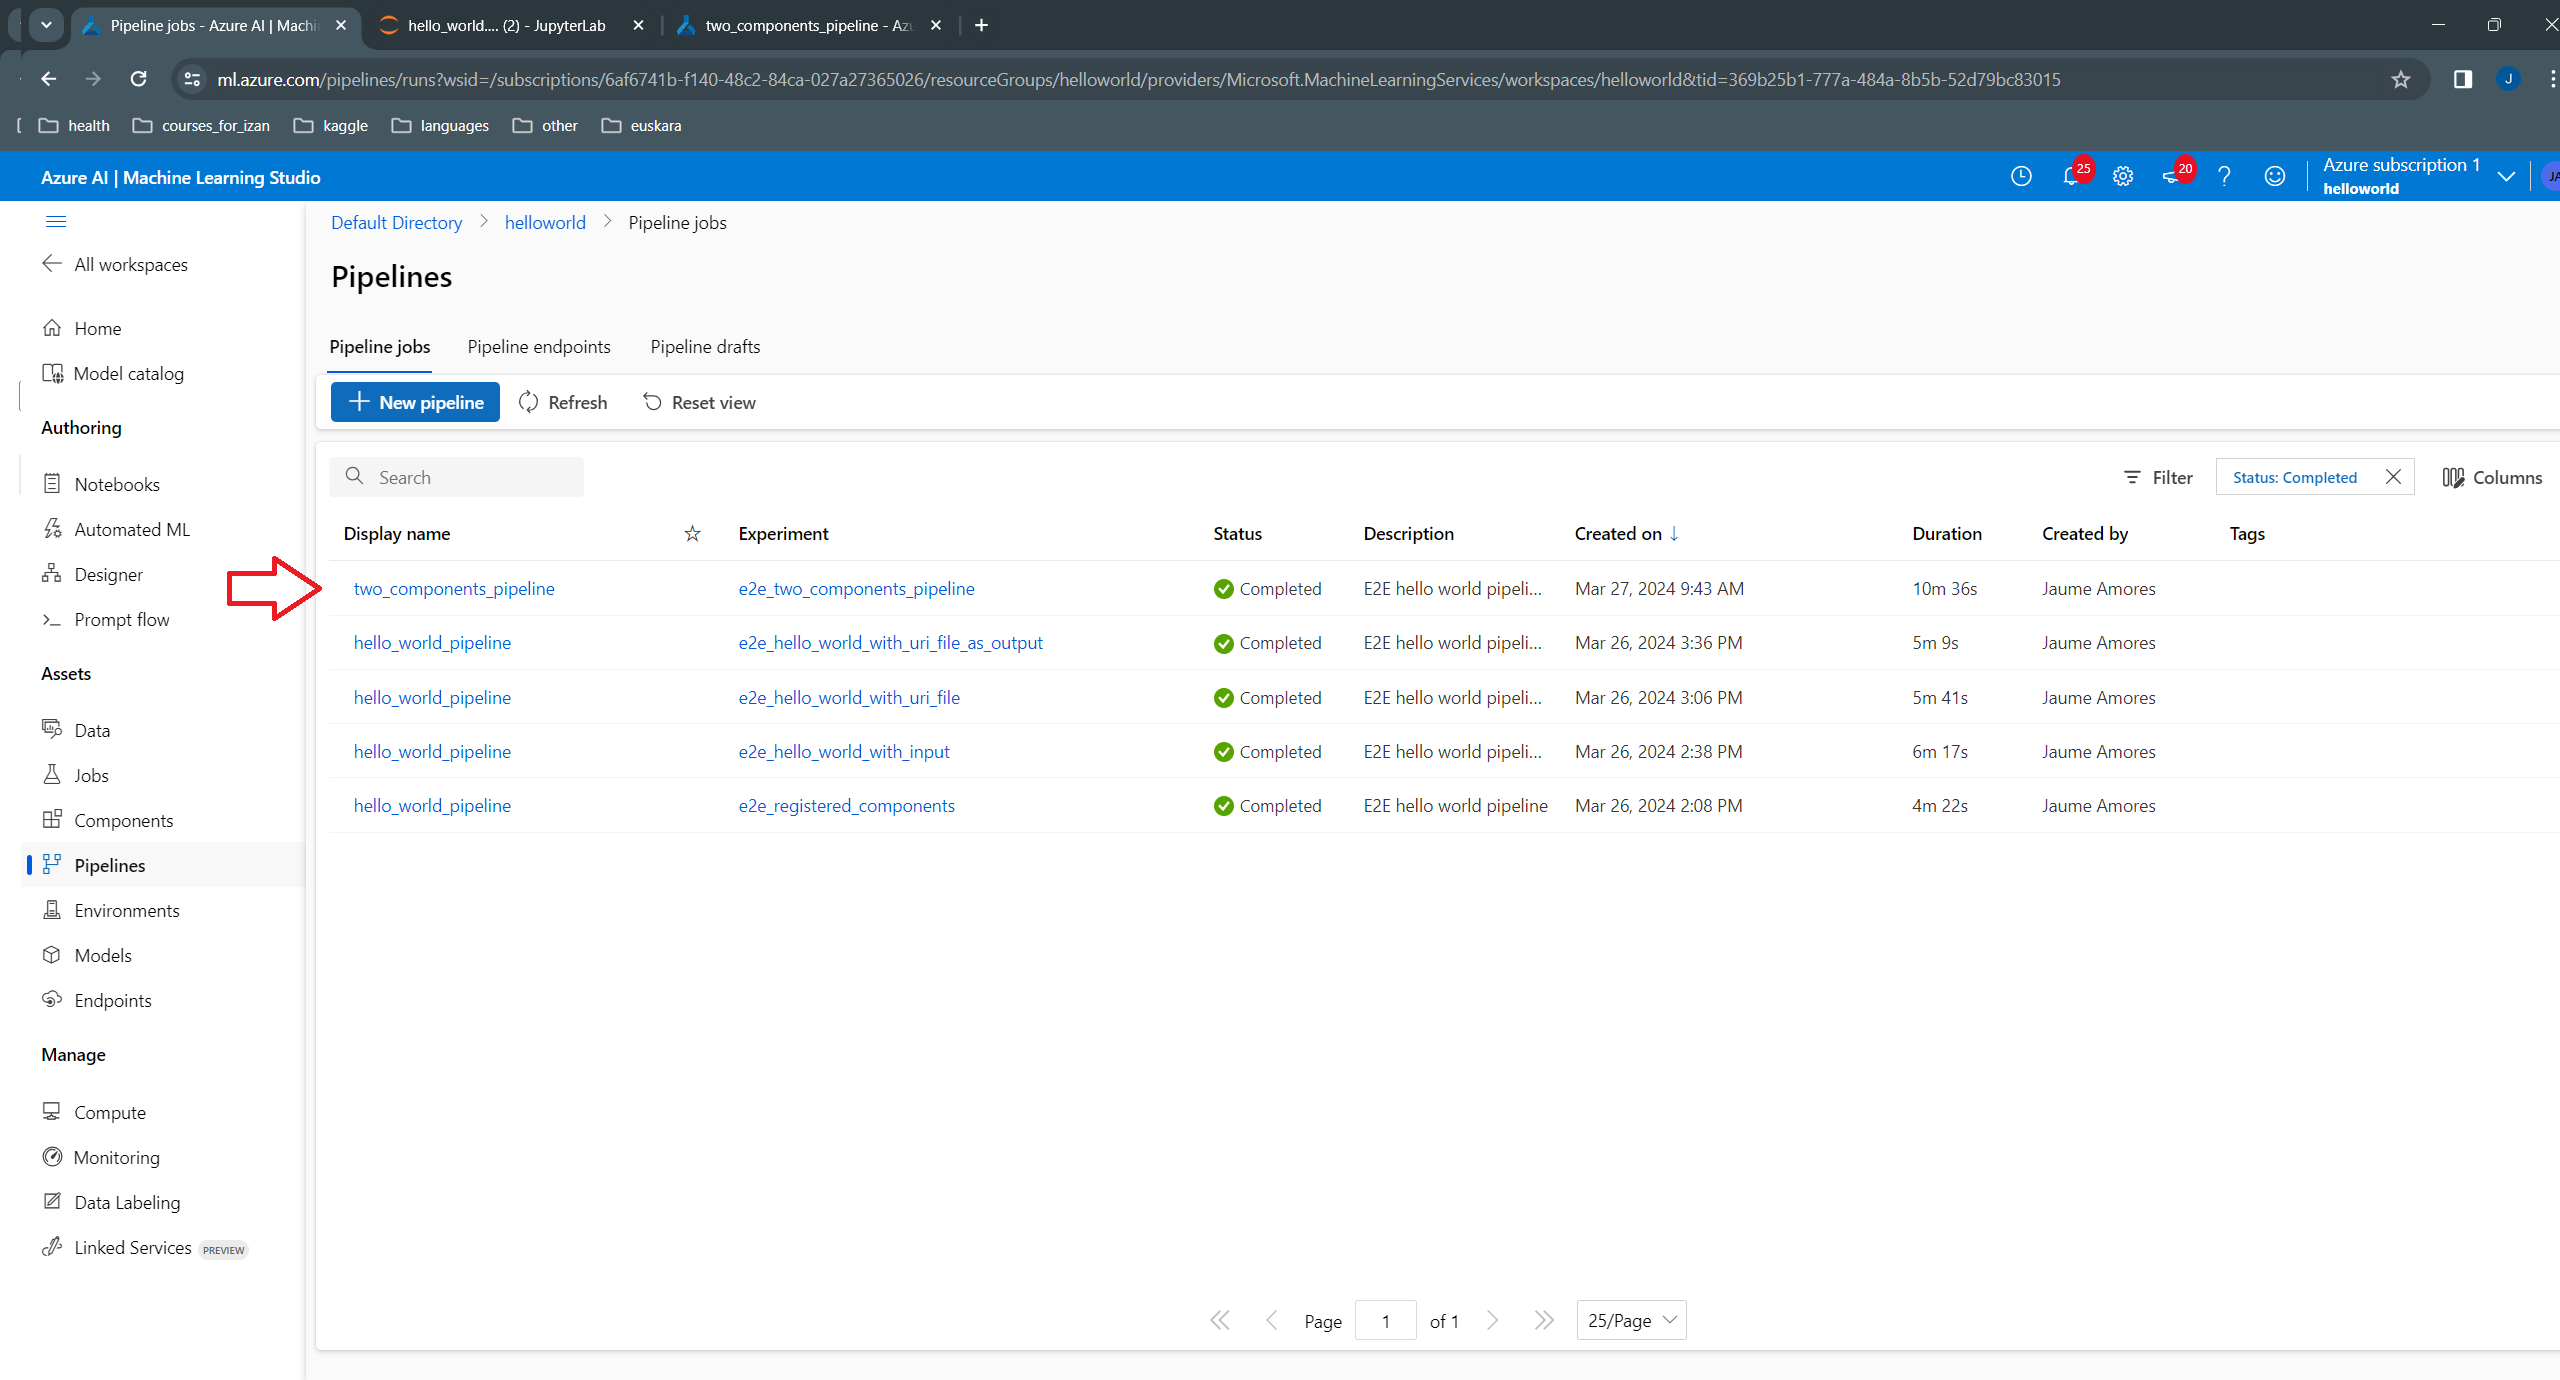

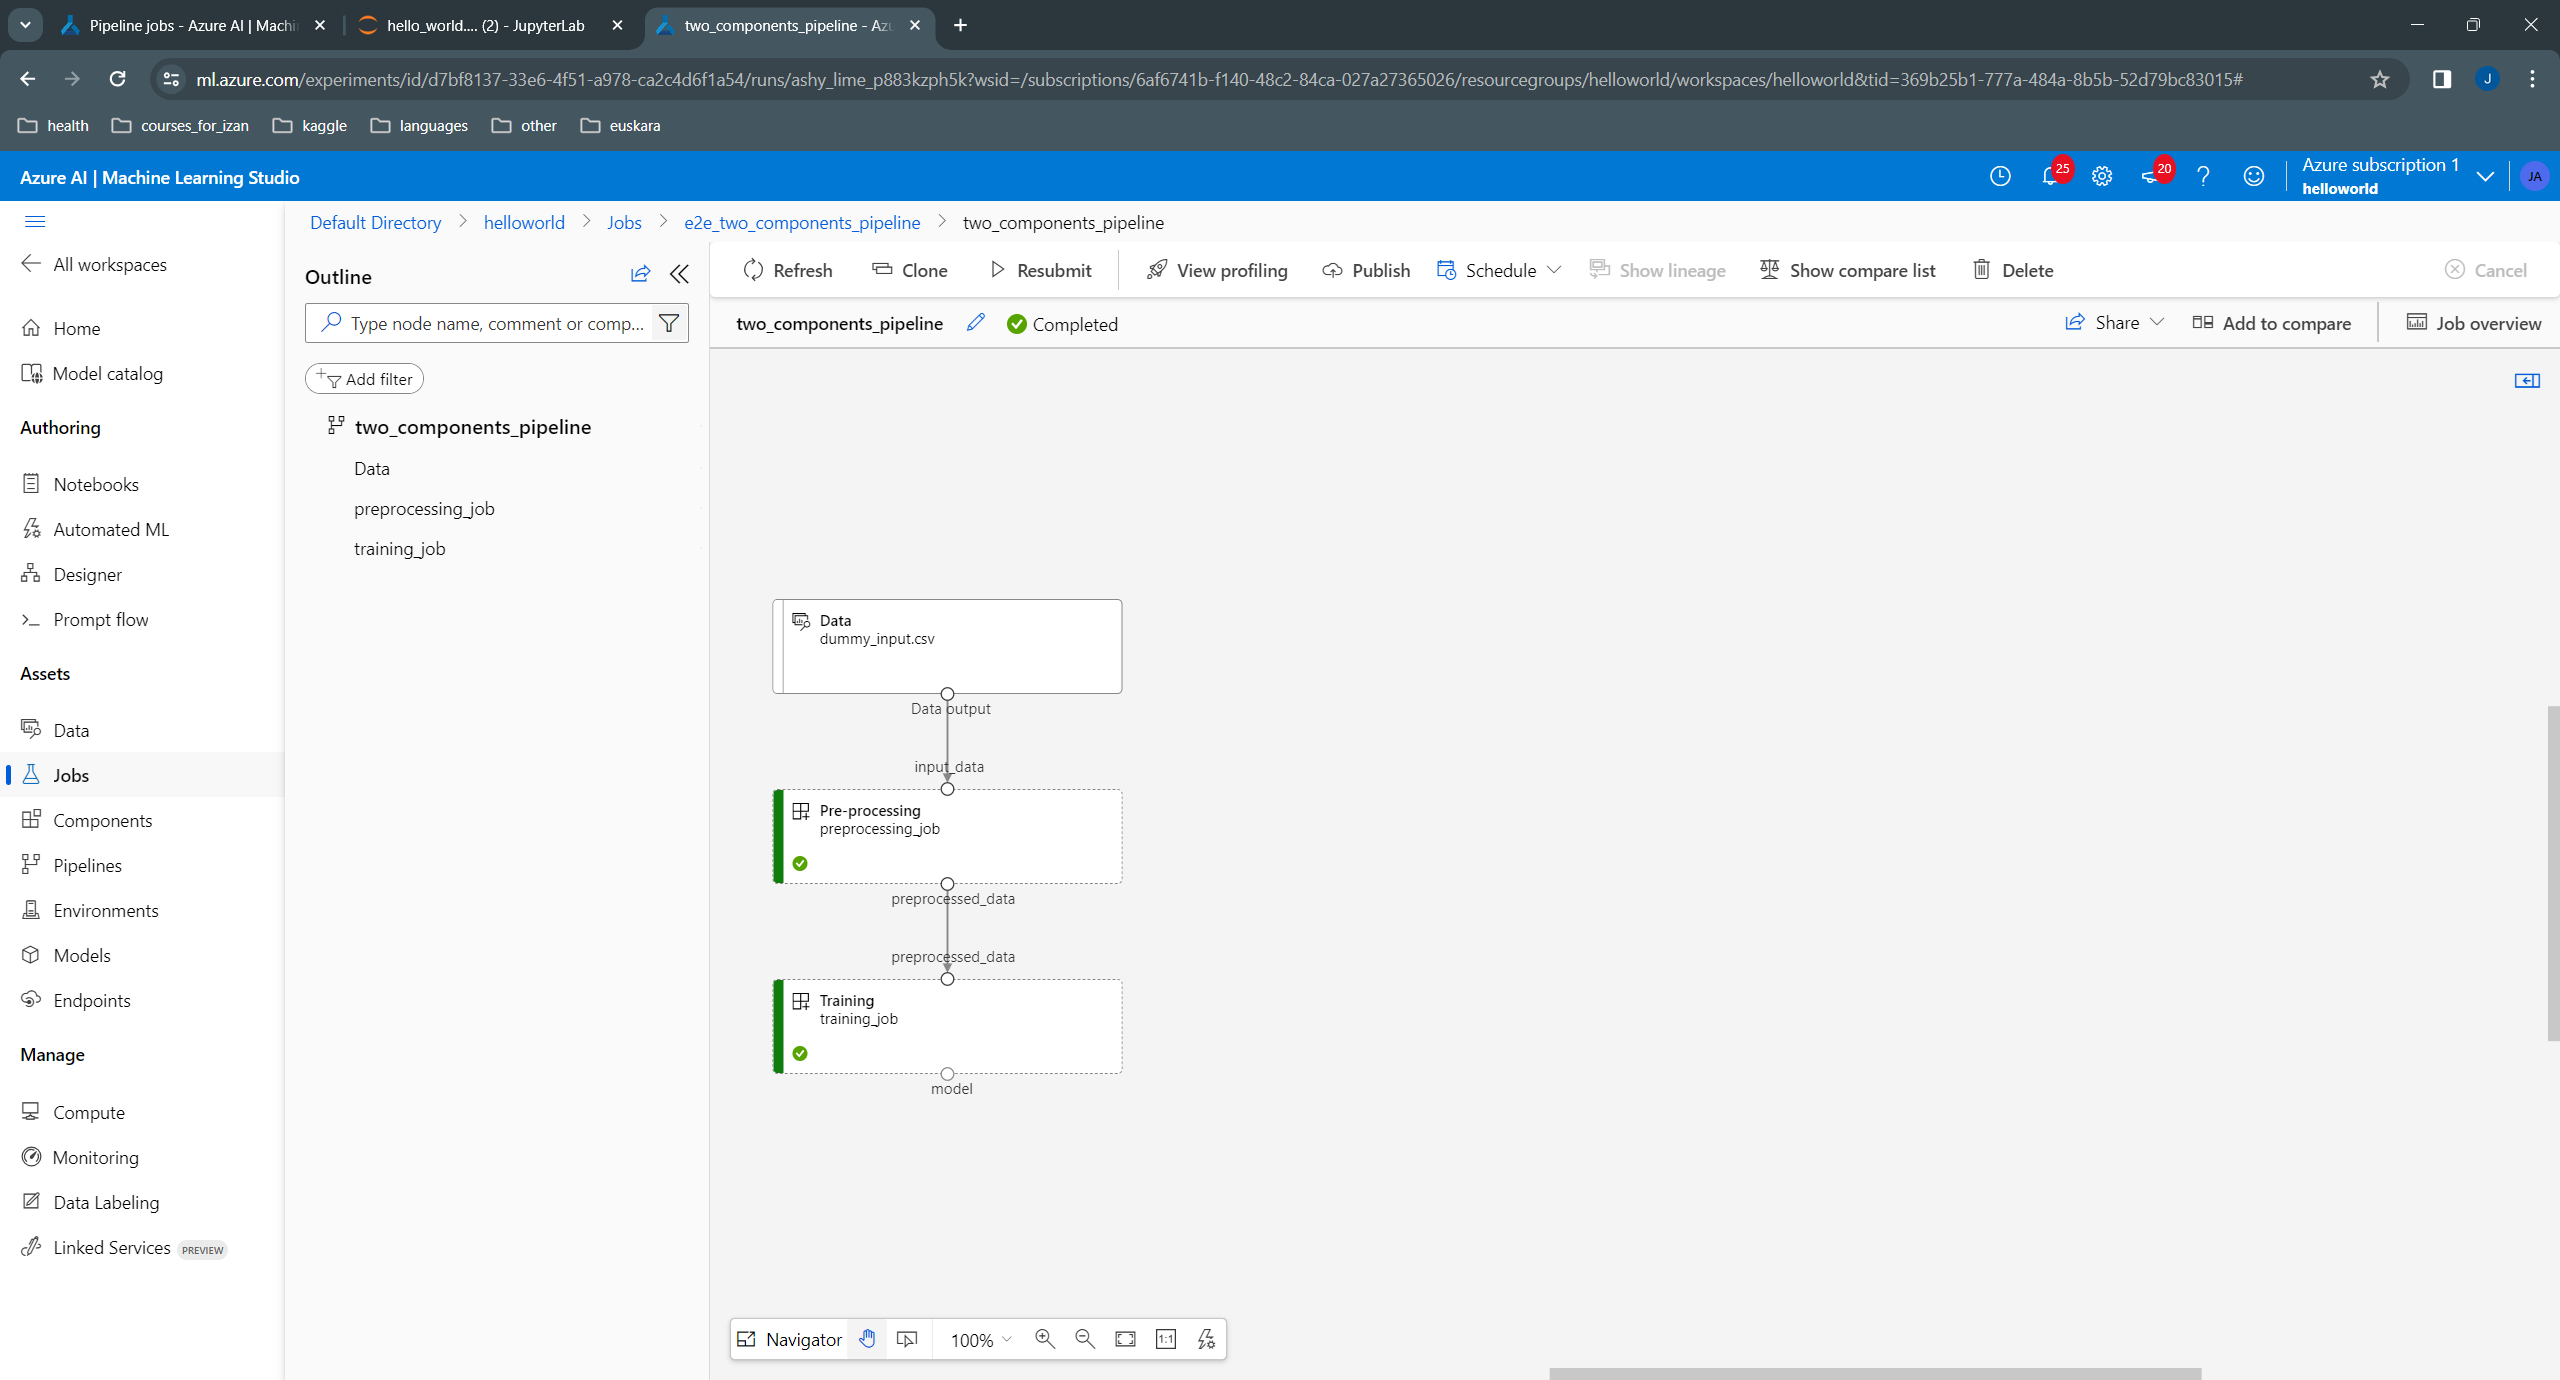

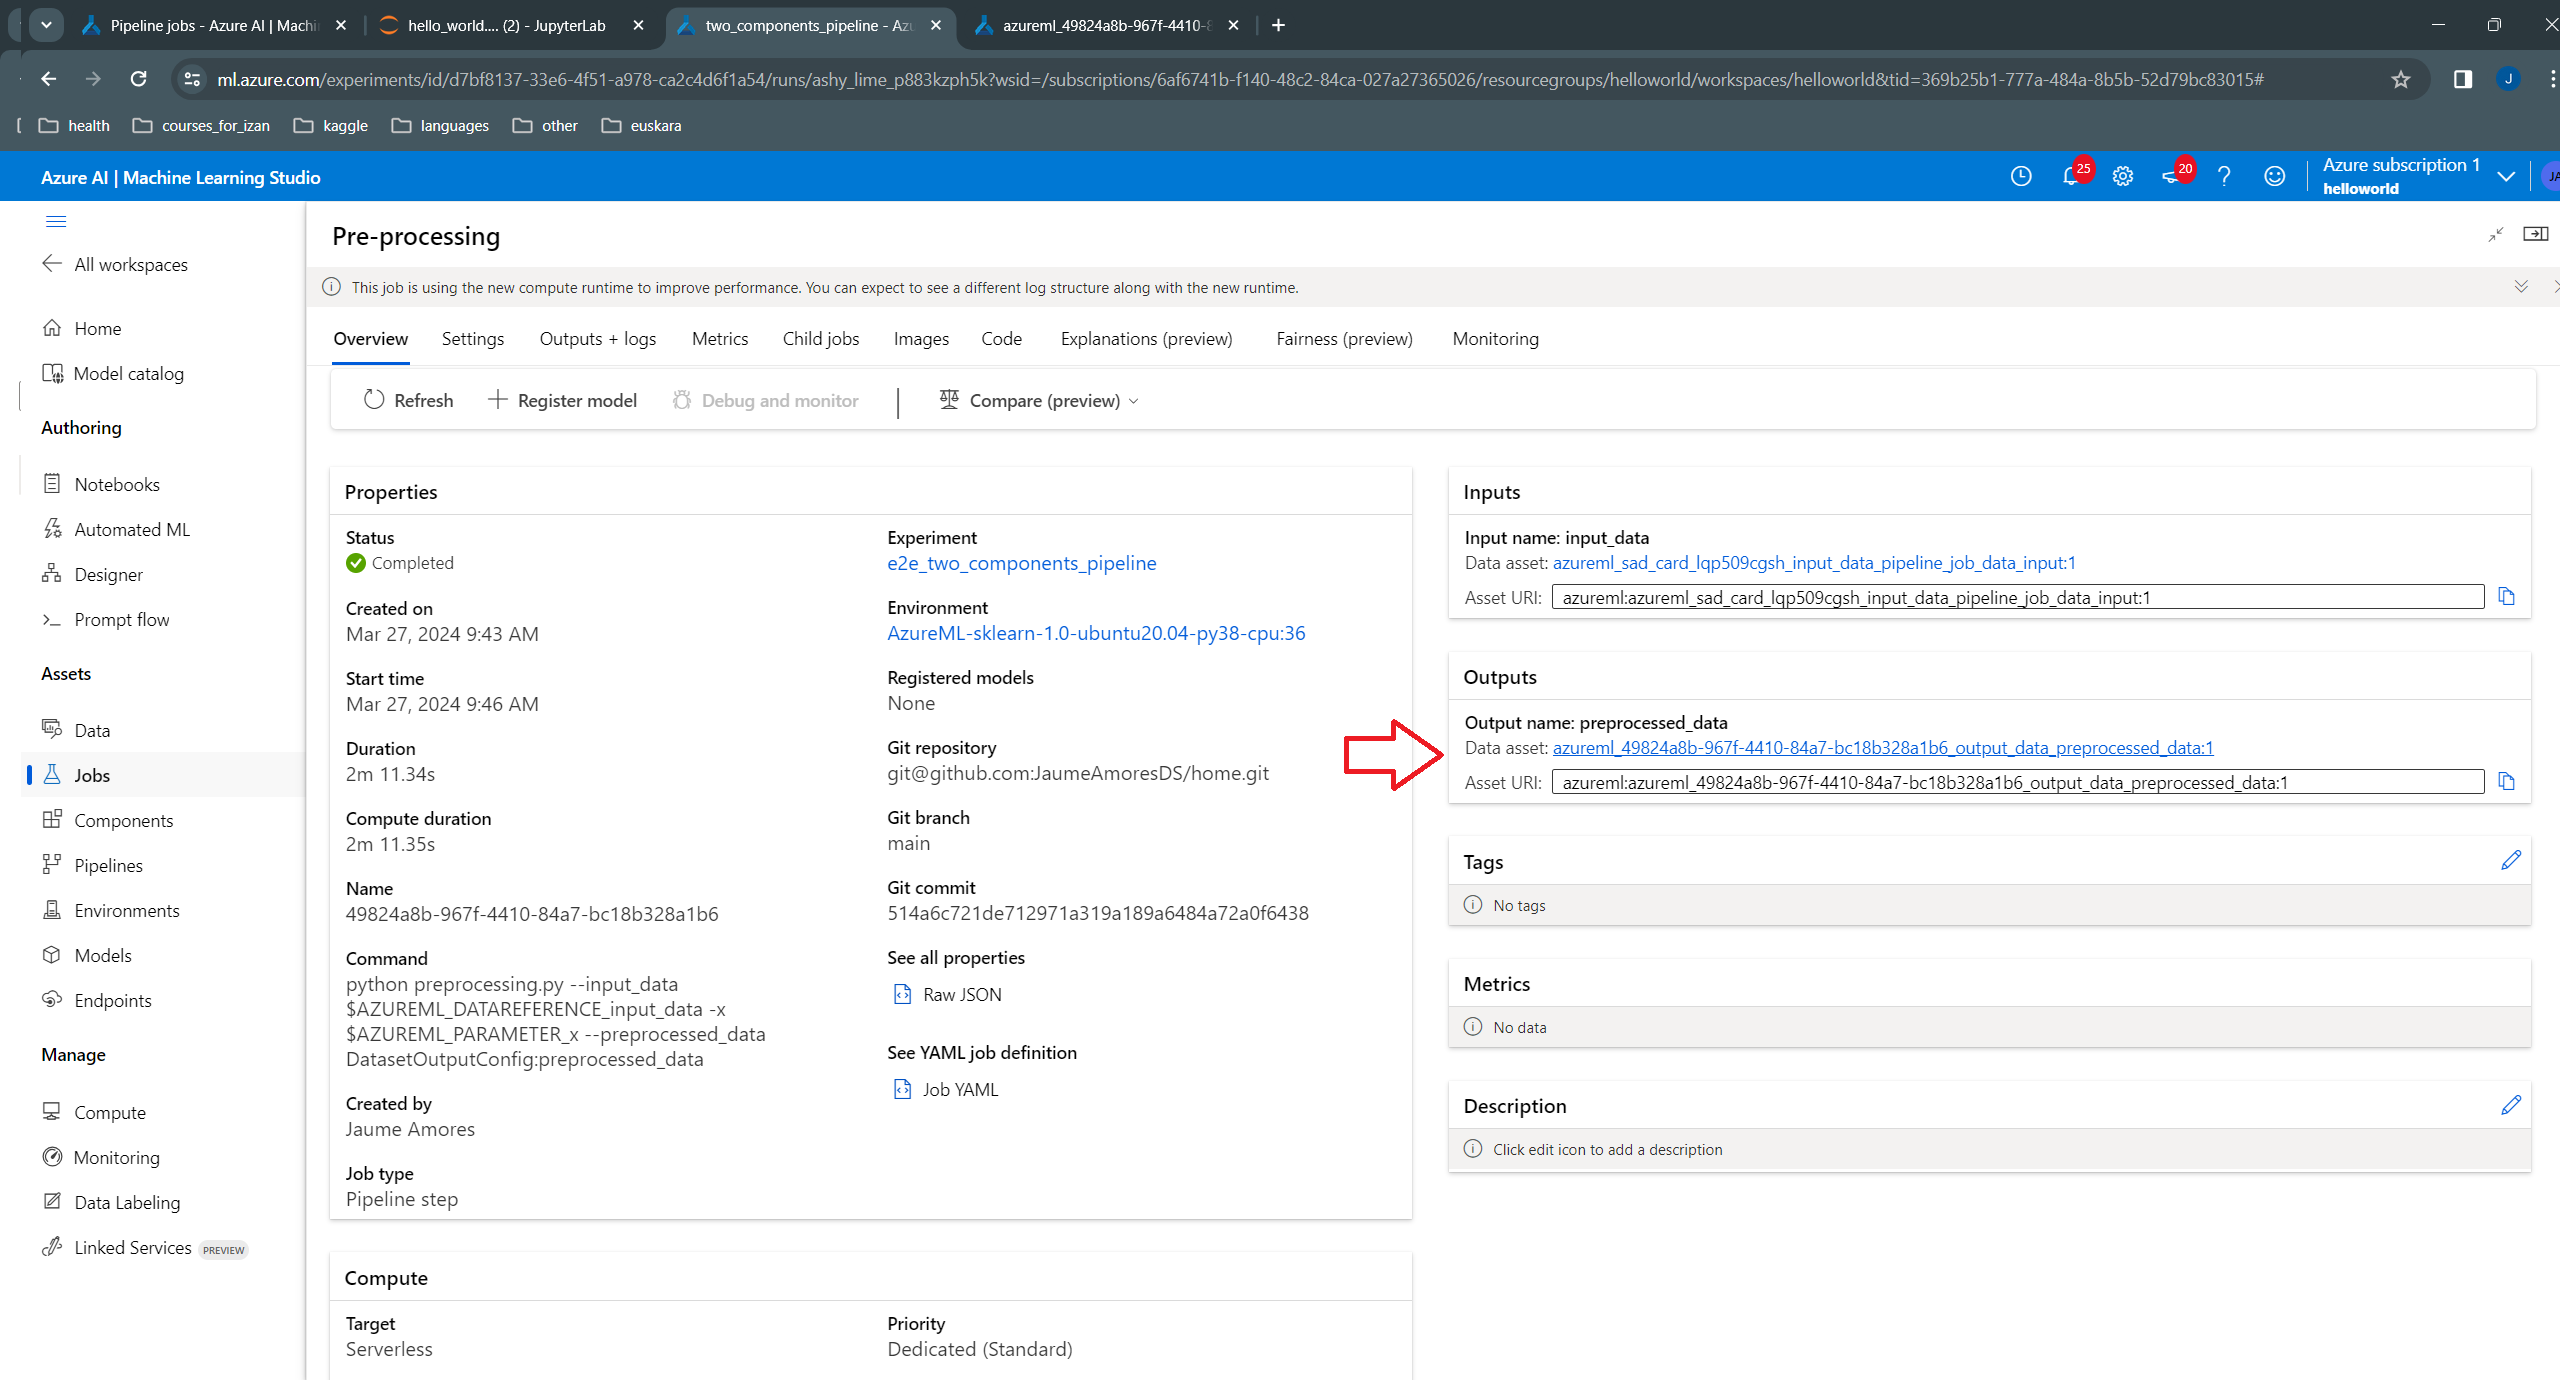

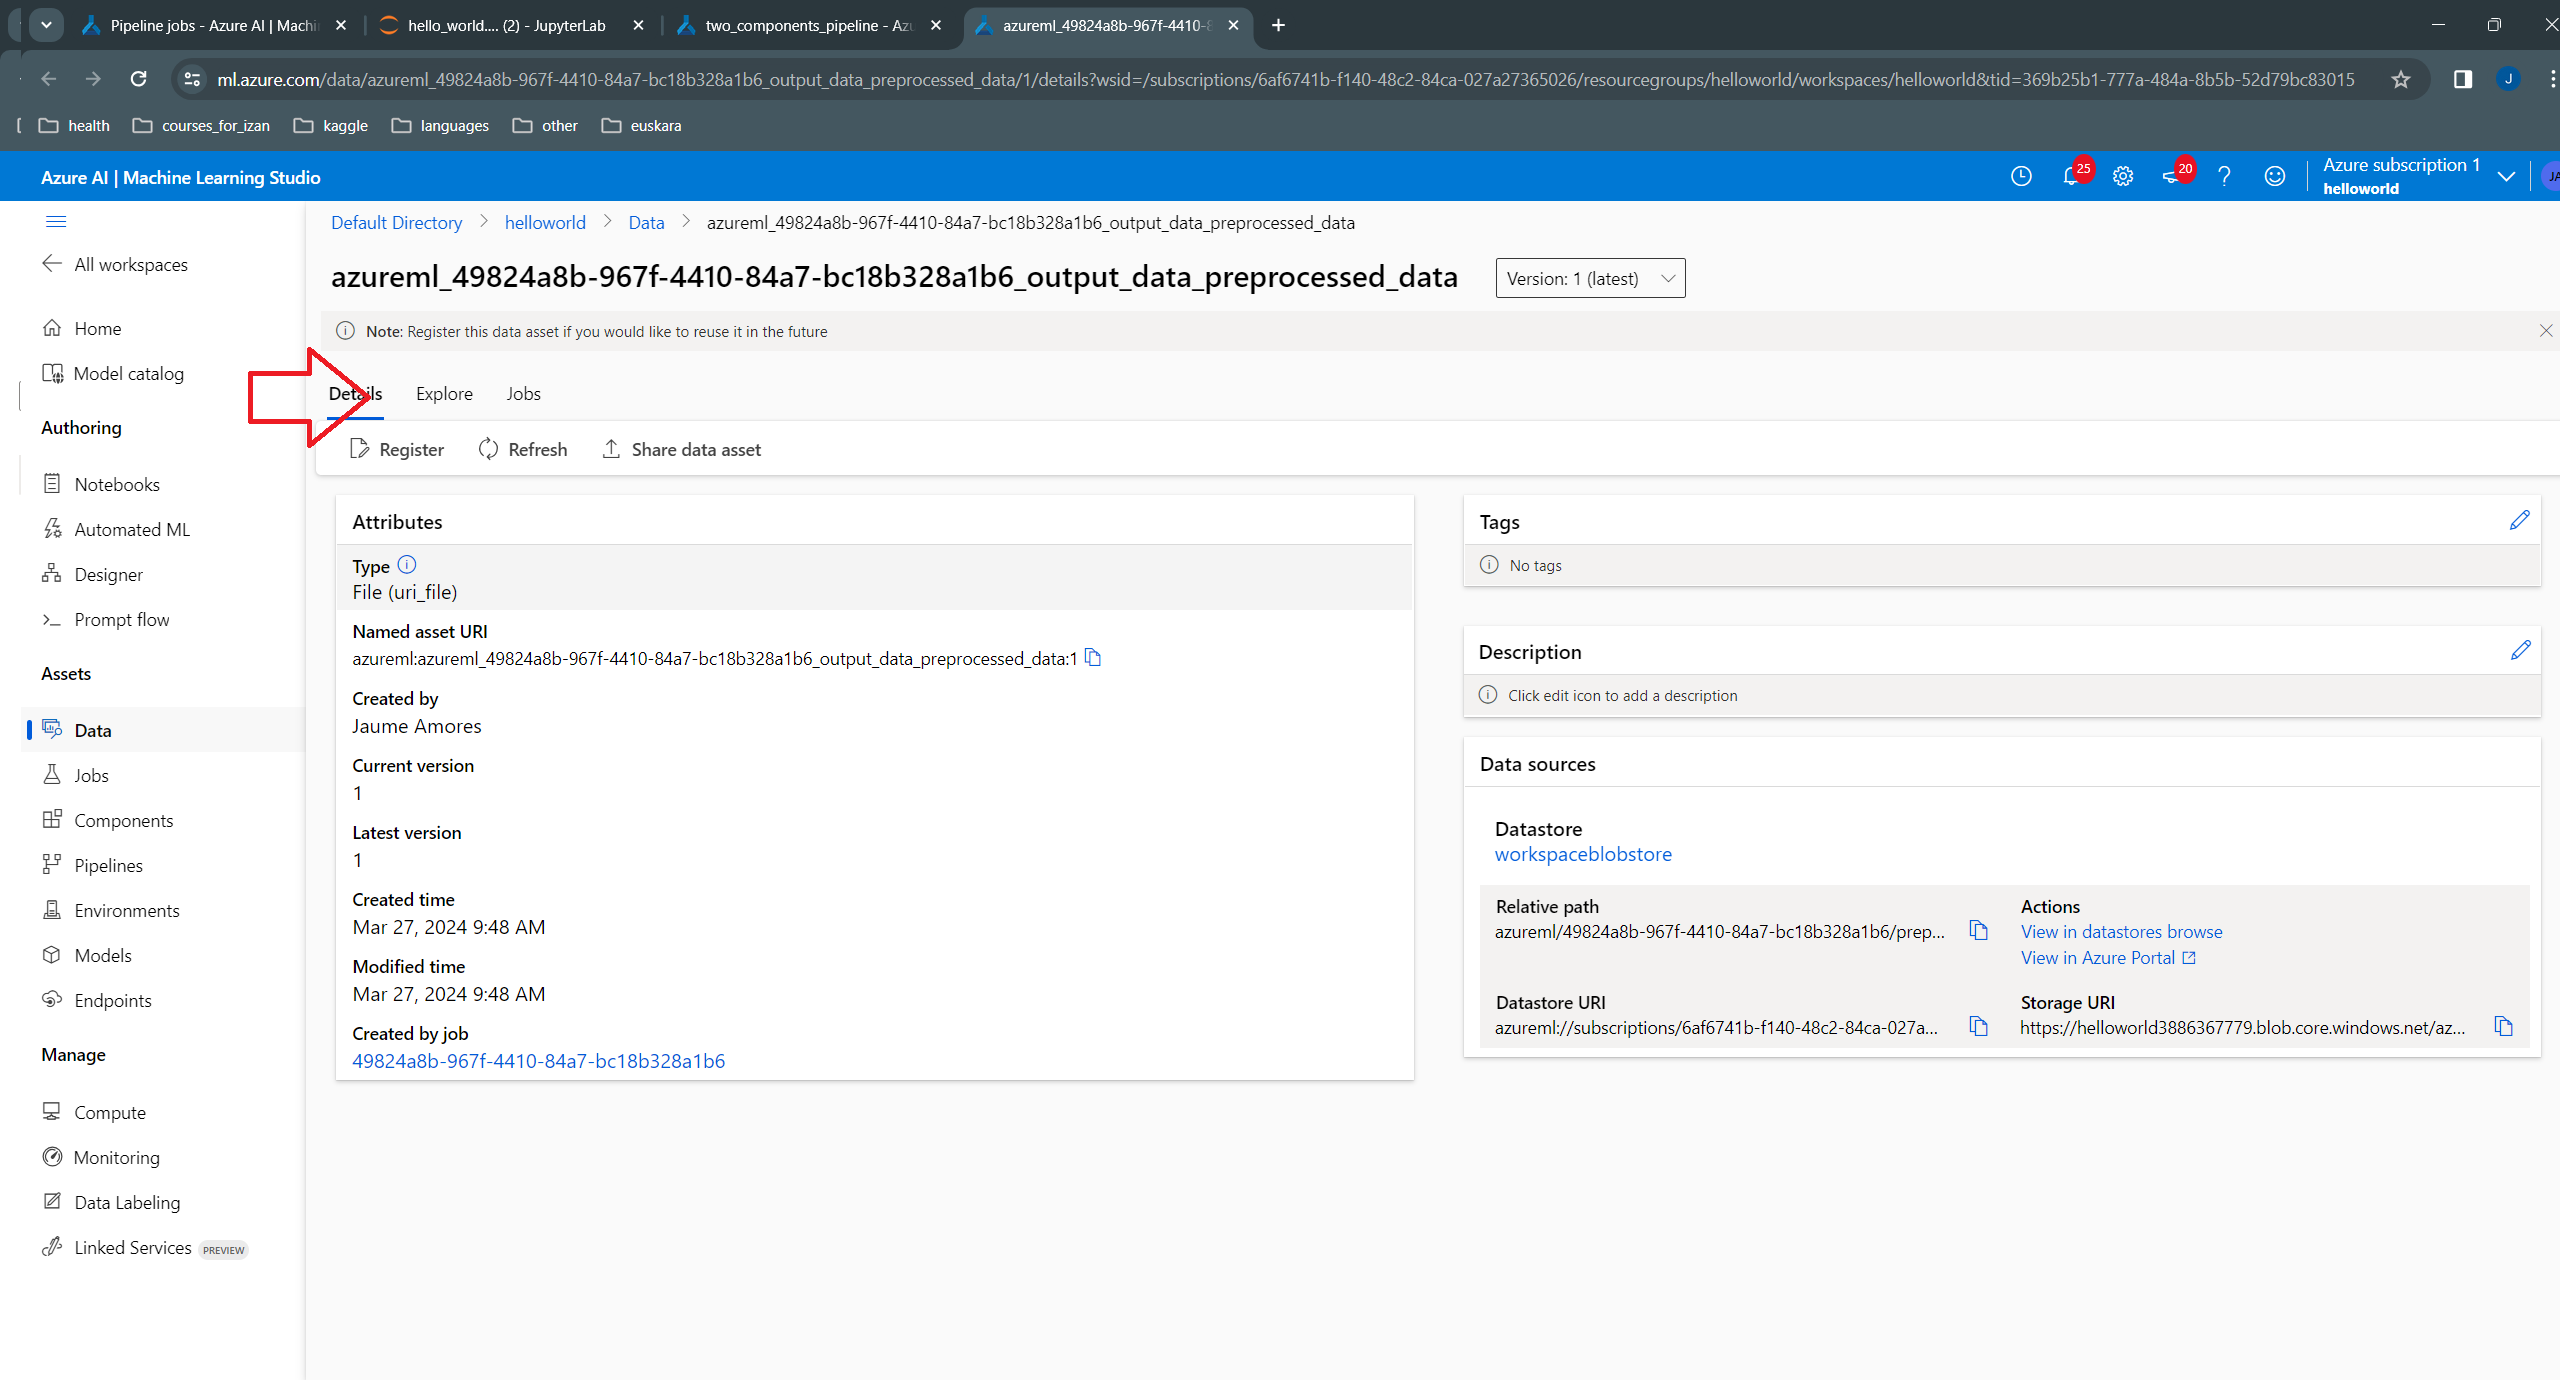

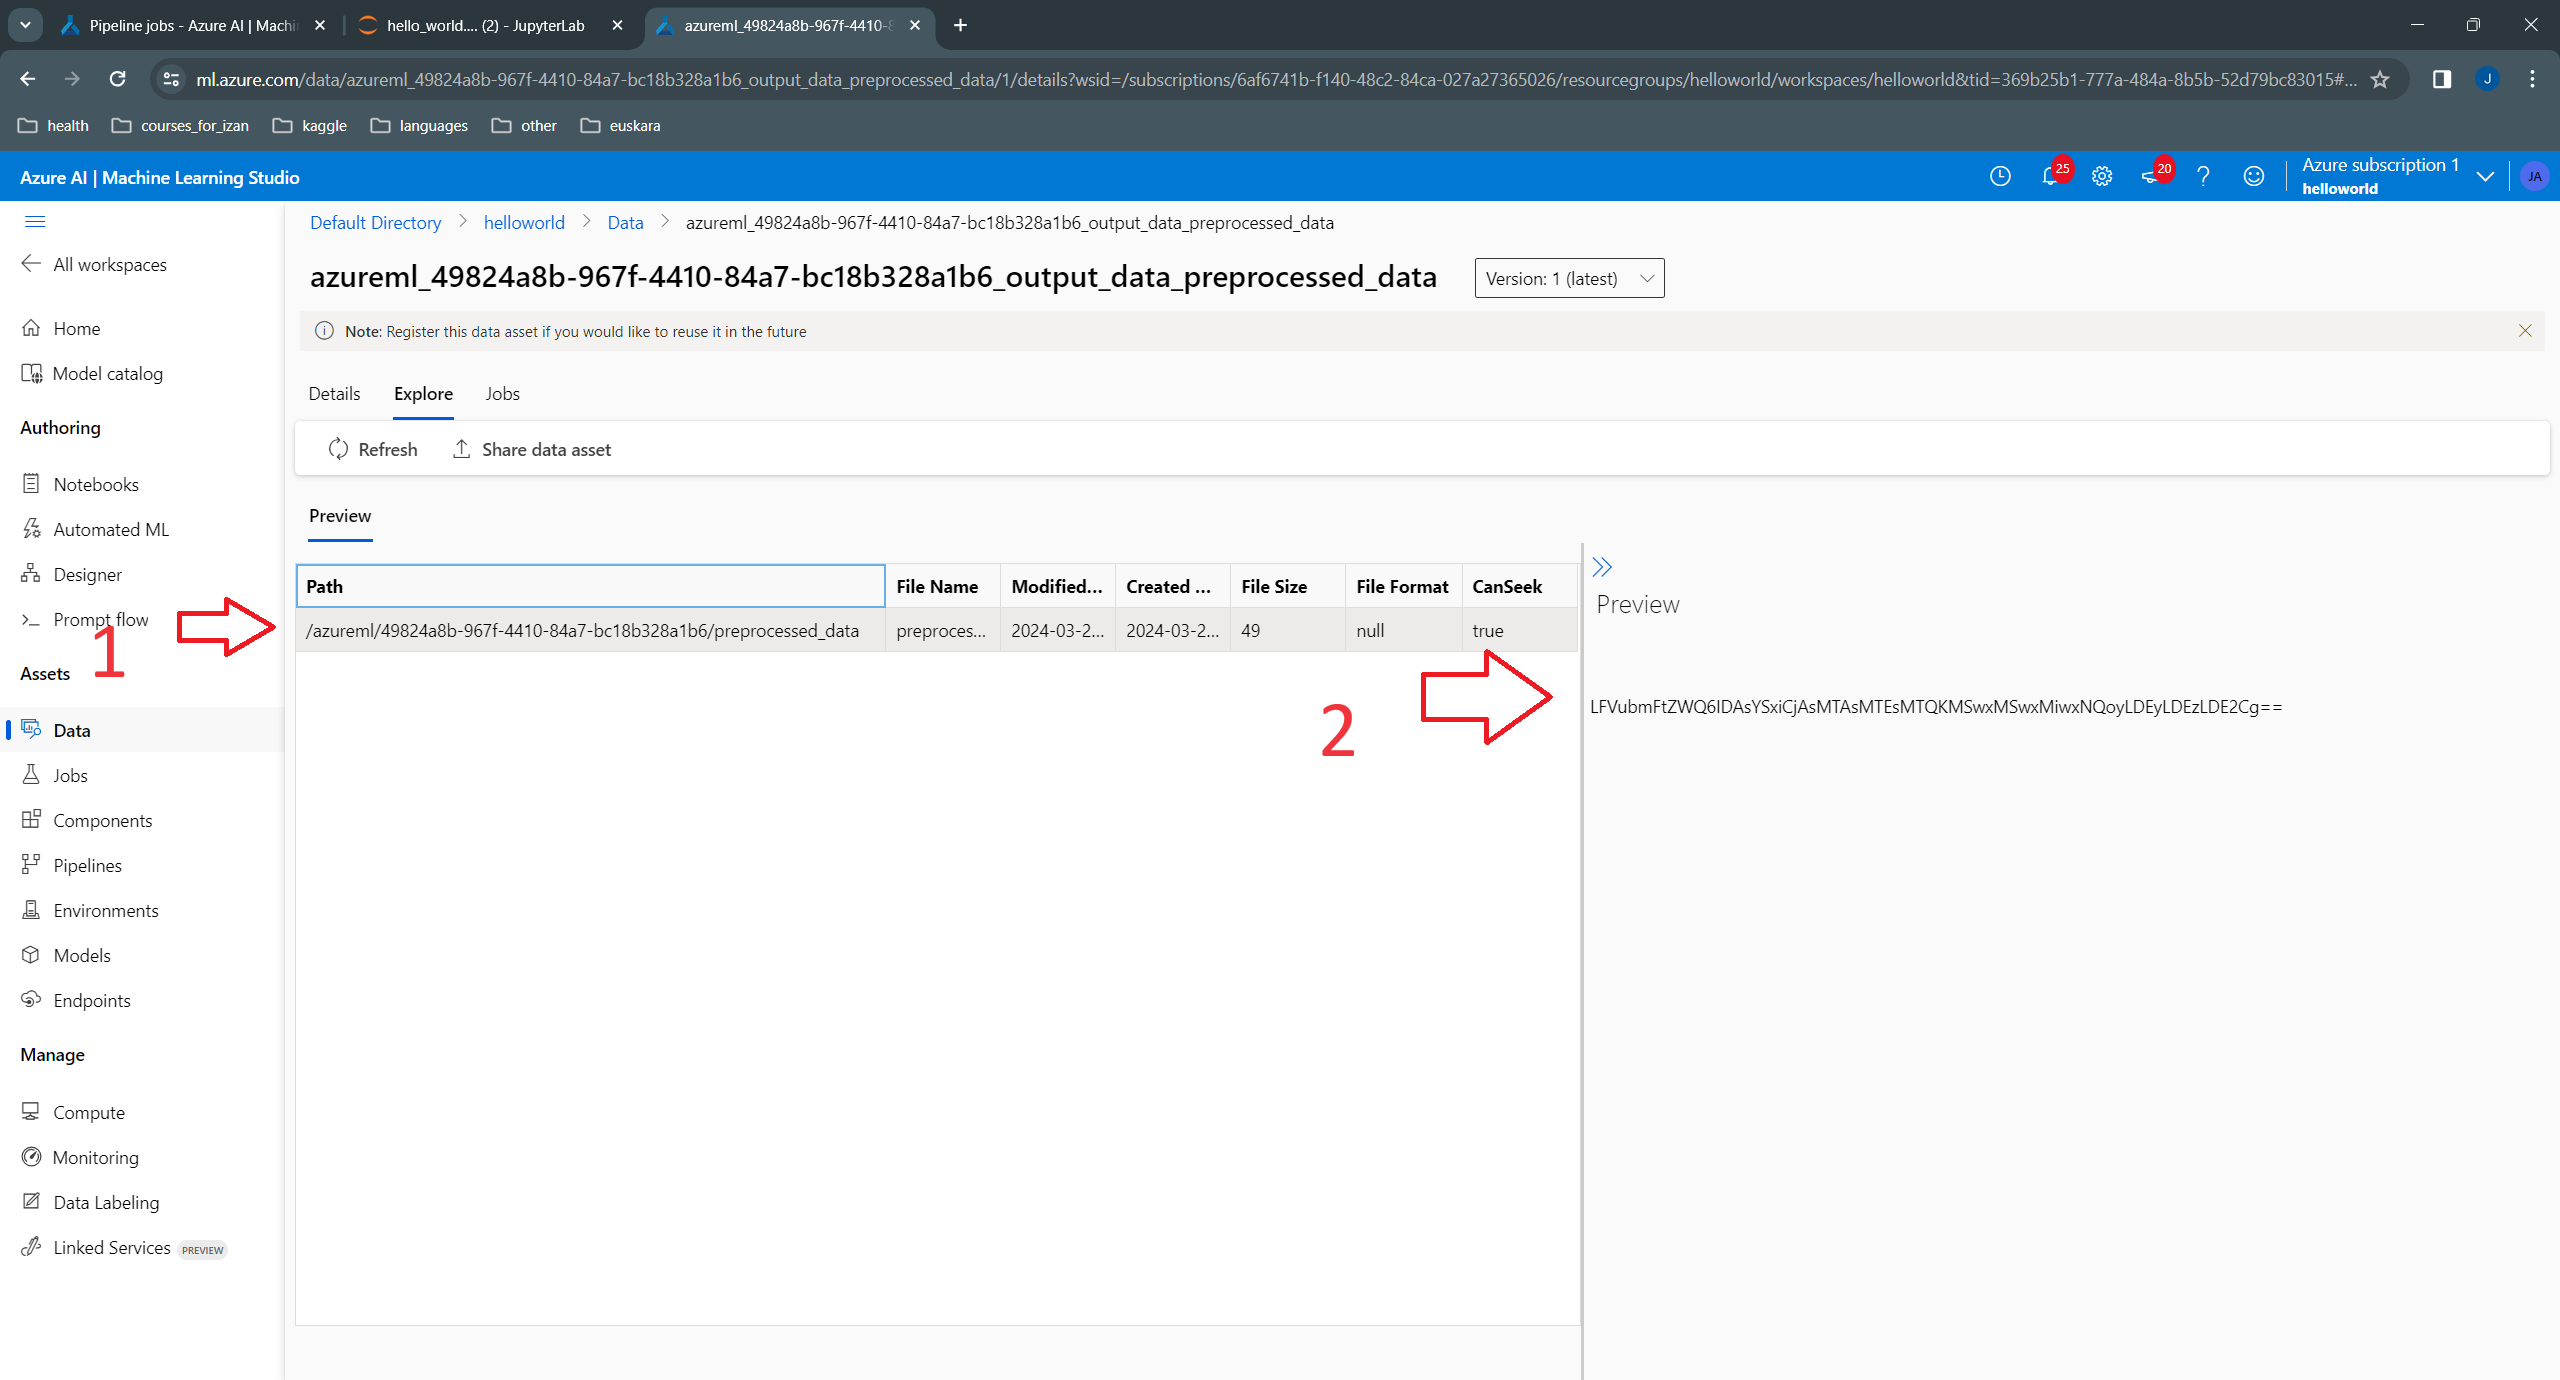

We can see that:
    
1. The path to the preprocessed data has been automatically set to `azureml/49824a8b-967f-4410-84a7-bc18b328a1b6/preprocessed_data`, where the file name `preprocessed_data` is the name of the output given in the component definition:
```python
    outputs=dict(
        preprocessed_data=Output (type="uri_file"),
    )
```

2. Since this file name doesn't have an extension, we cannot preview (see arrow 2). However, we can see its contents if we view the file in the datastore, as indicated below:

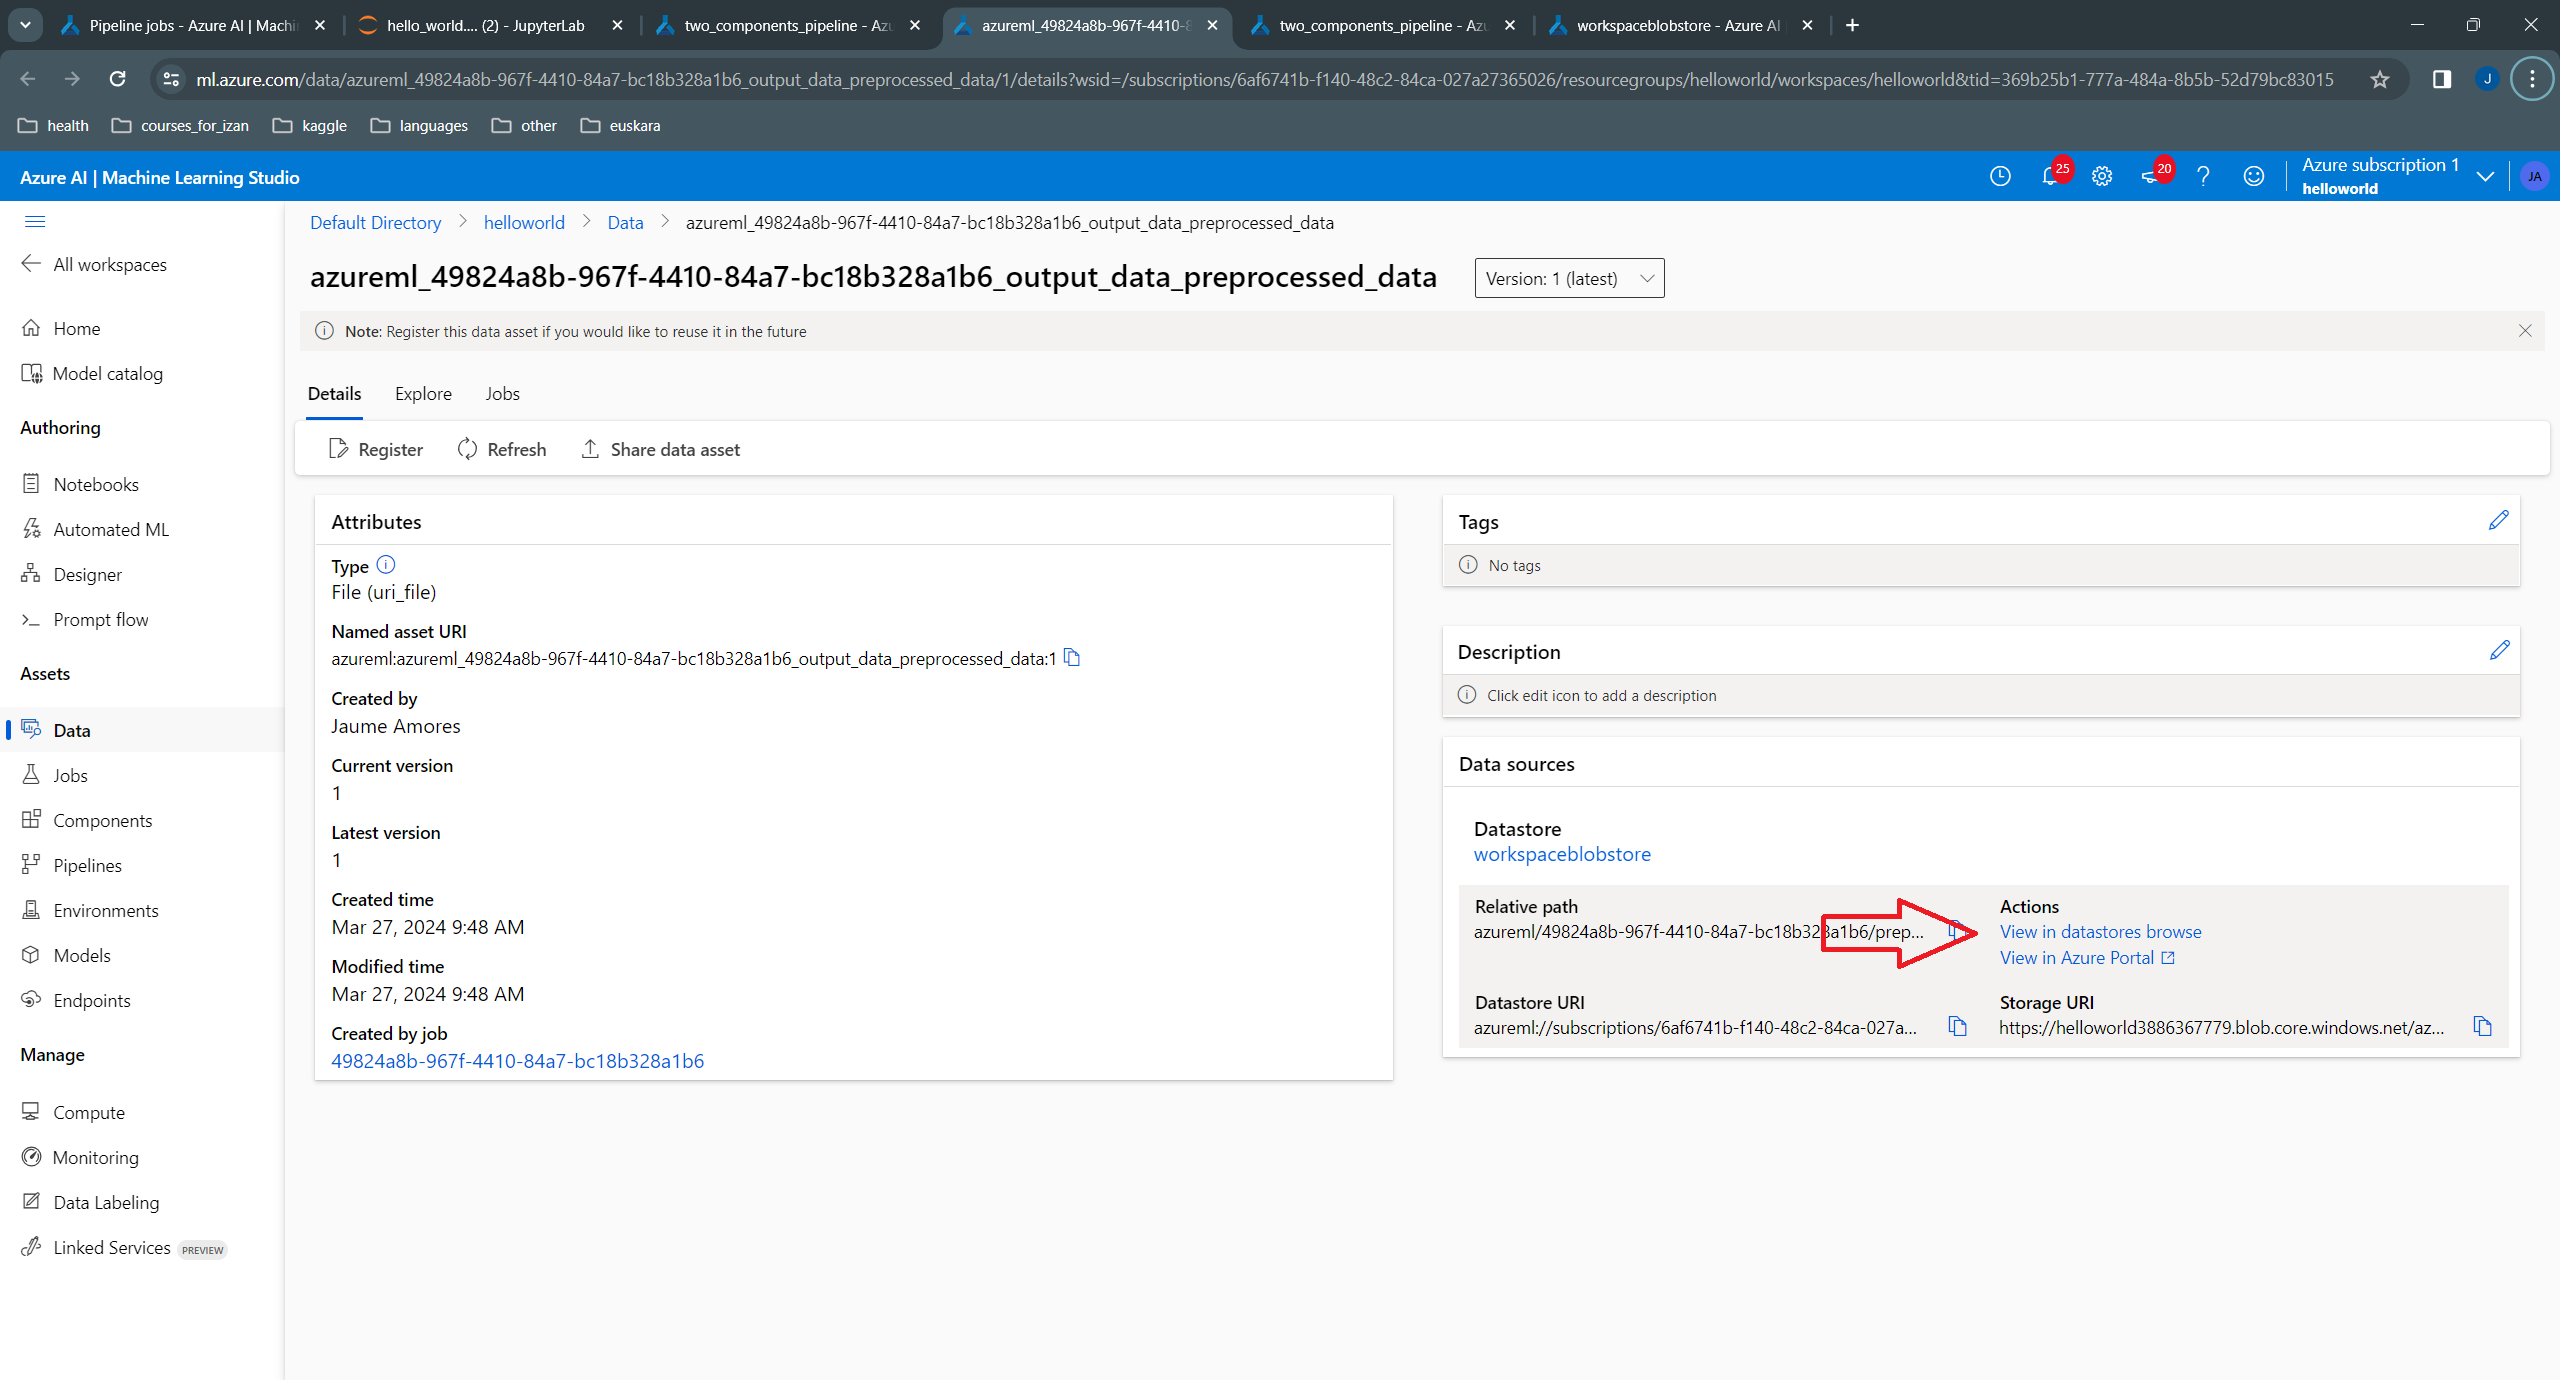

Unfortunately, the content of the file appears in text format, rather than as a table.

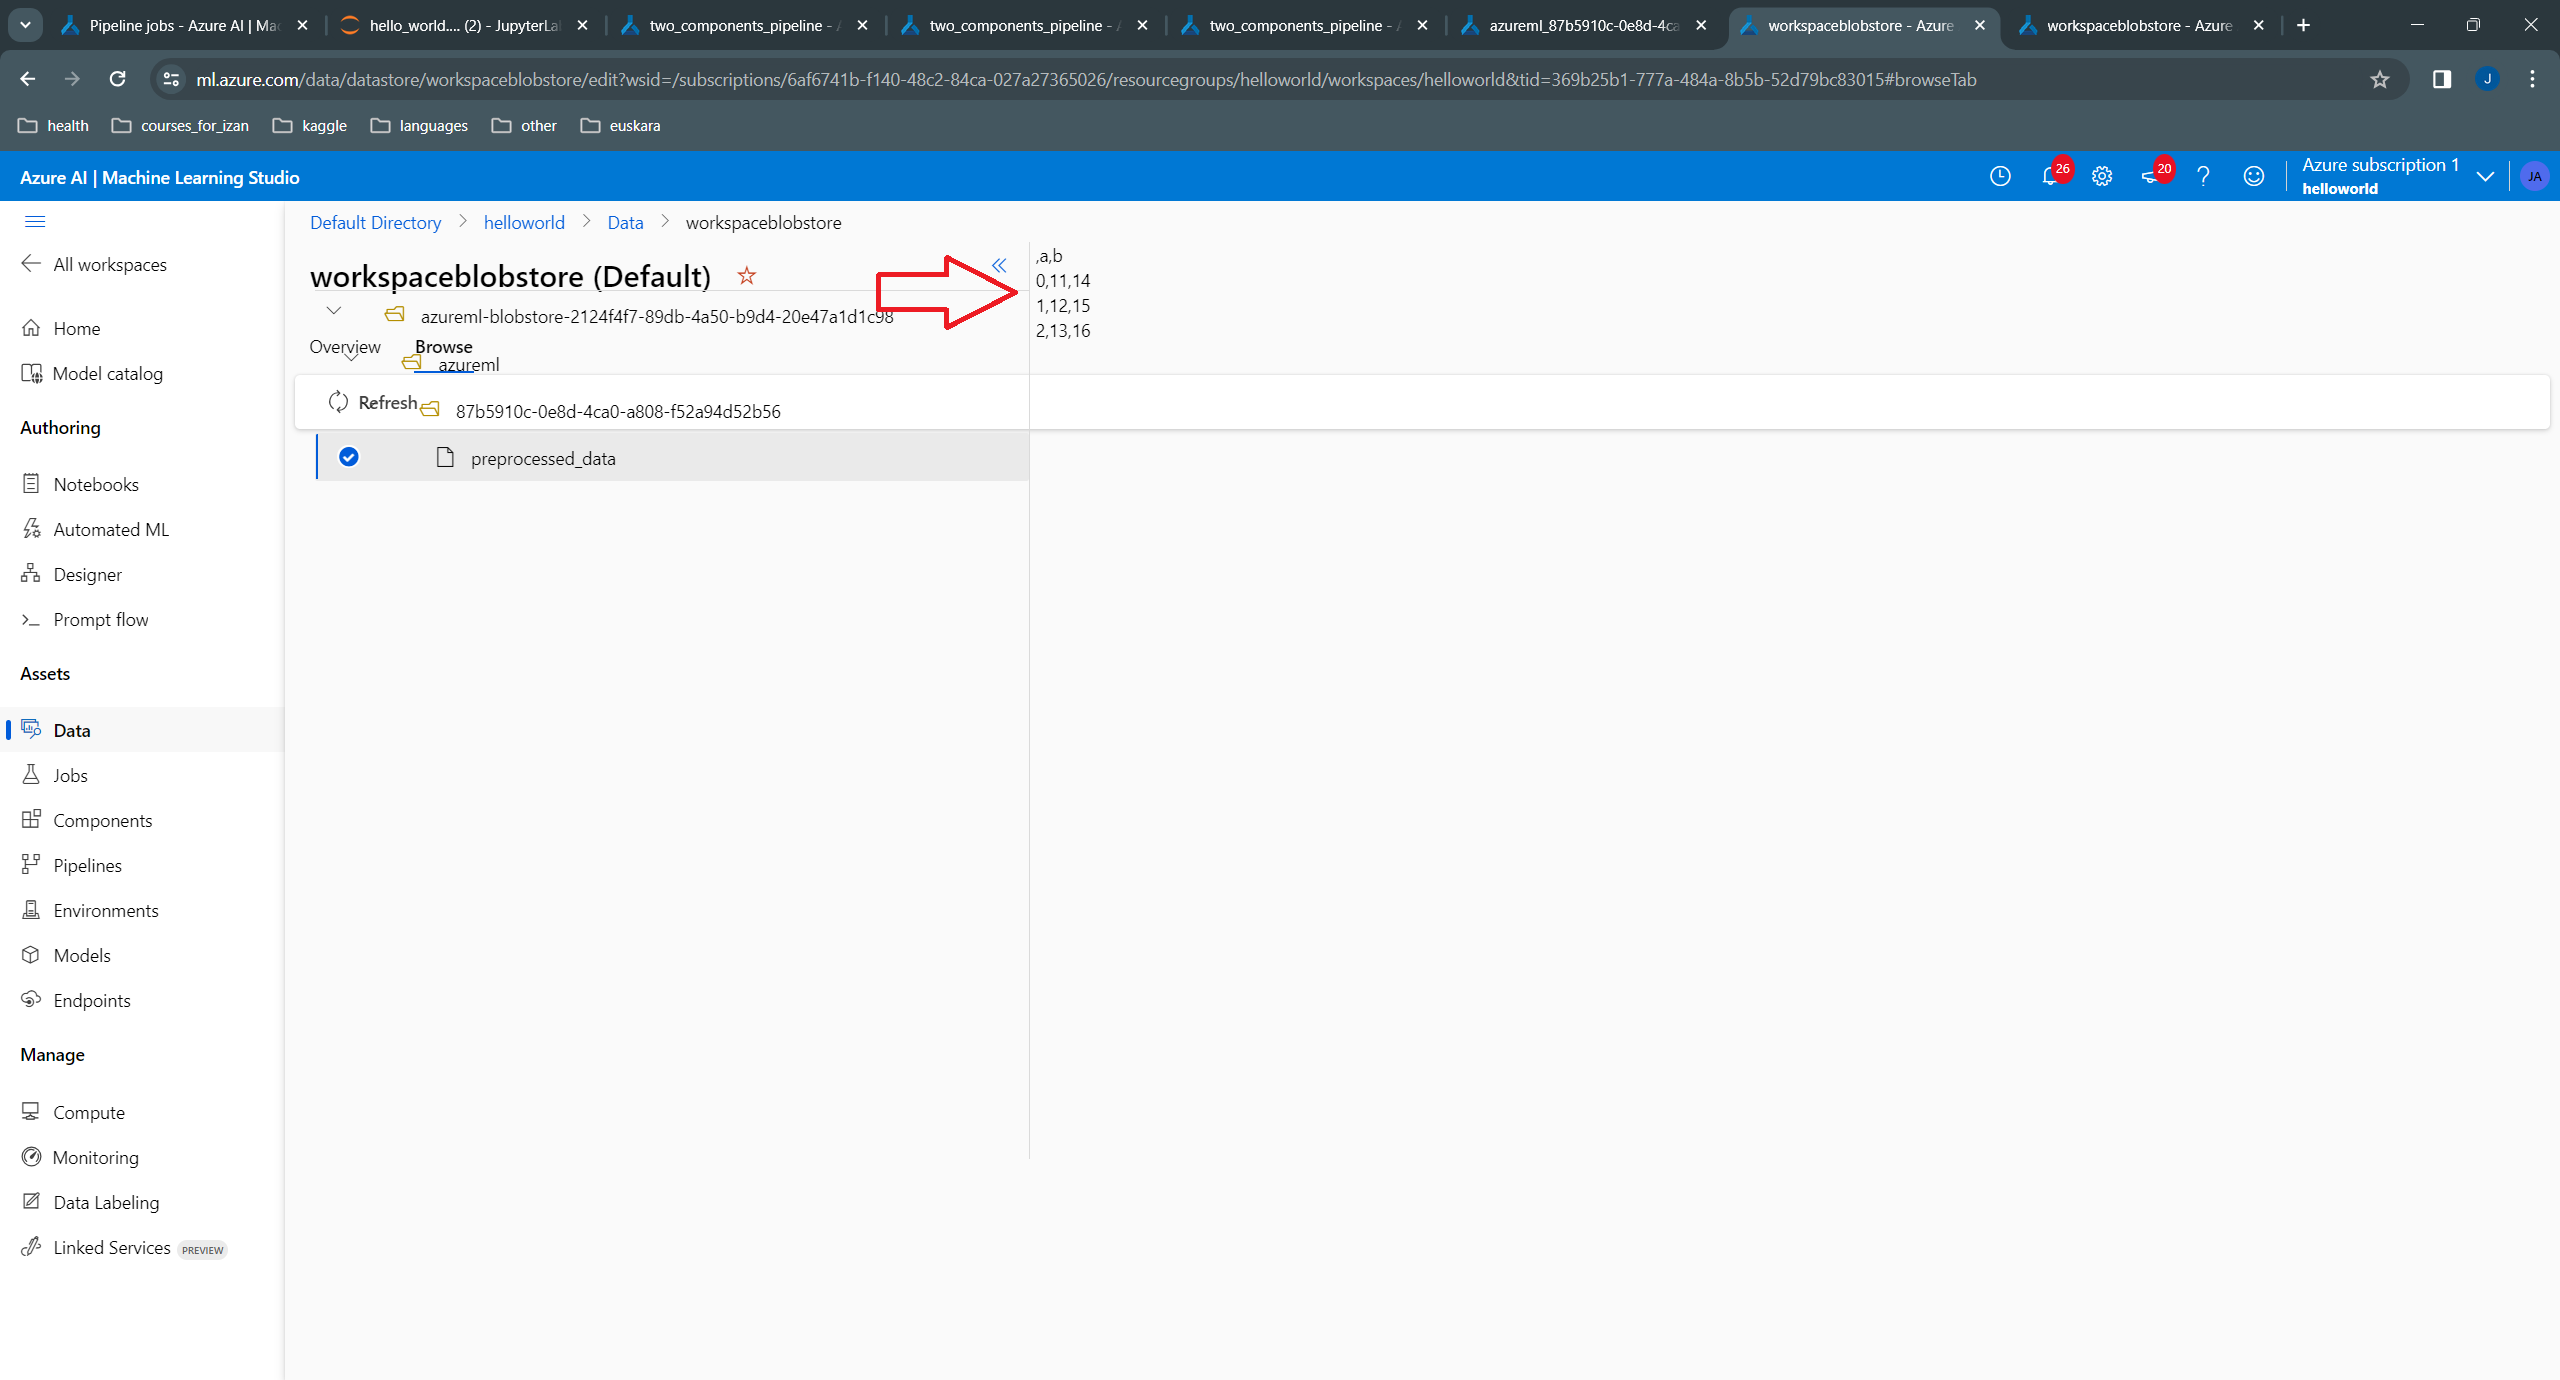

We can also see the content of the outputs by inspecting the logs of the training component:

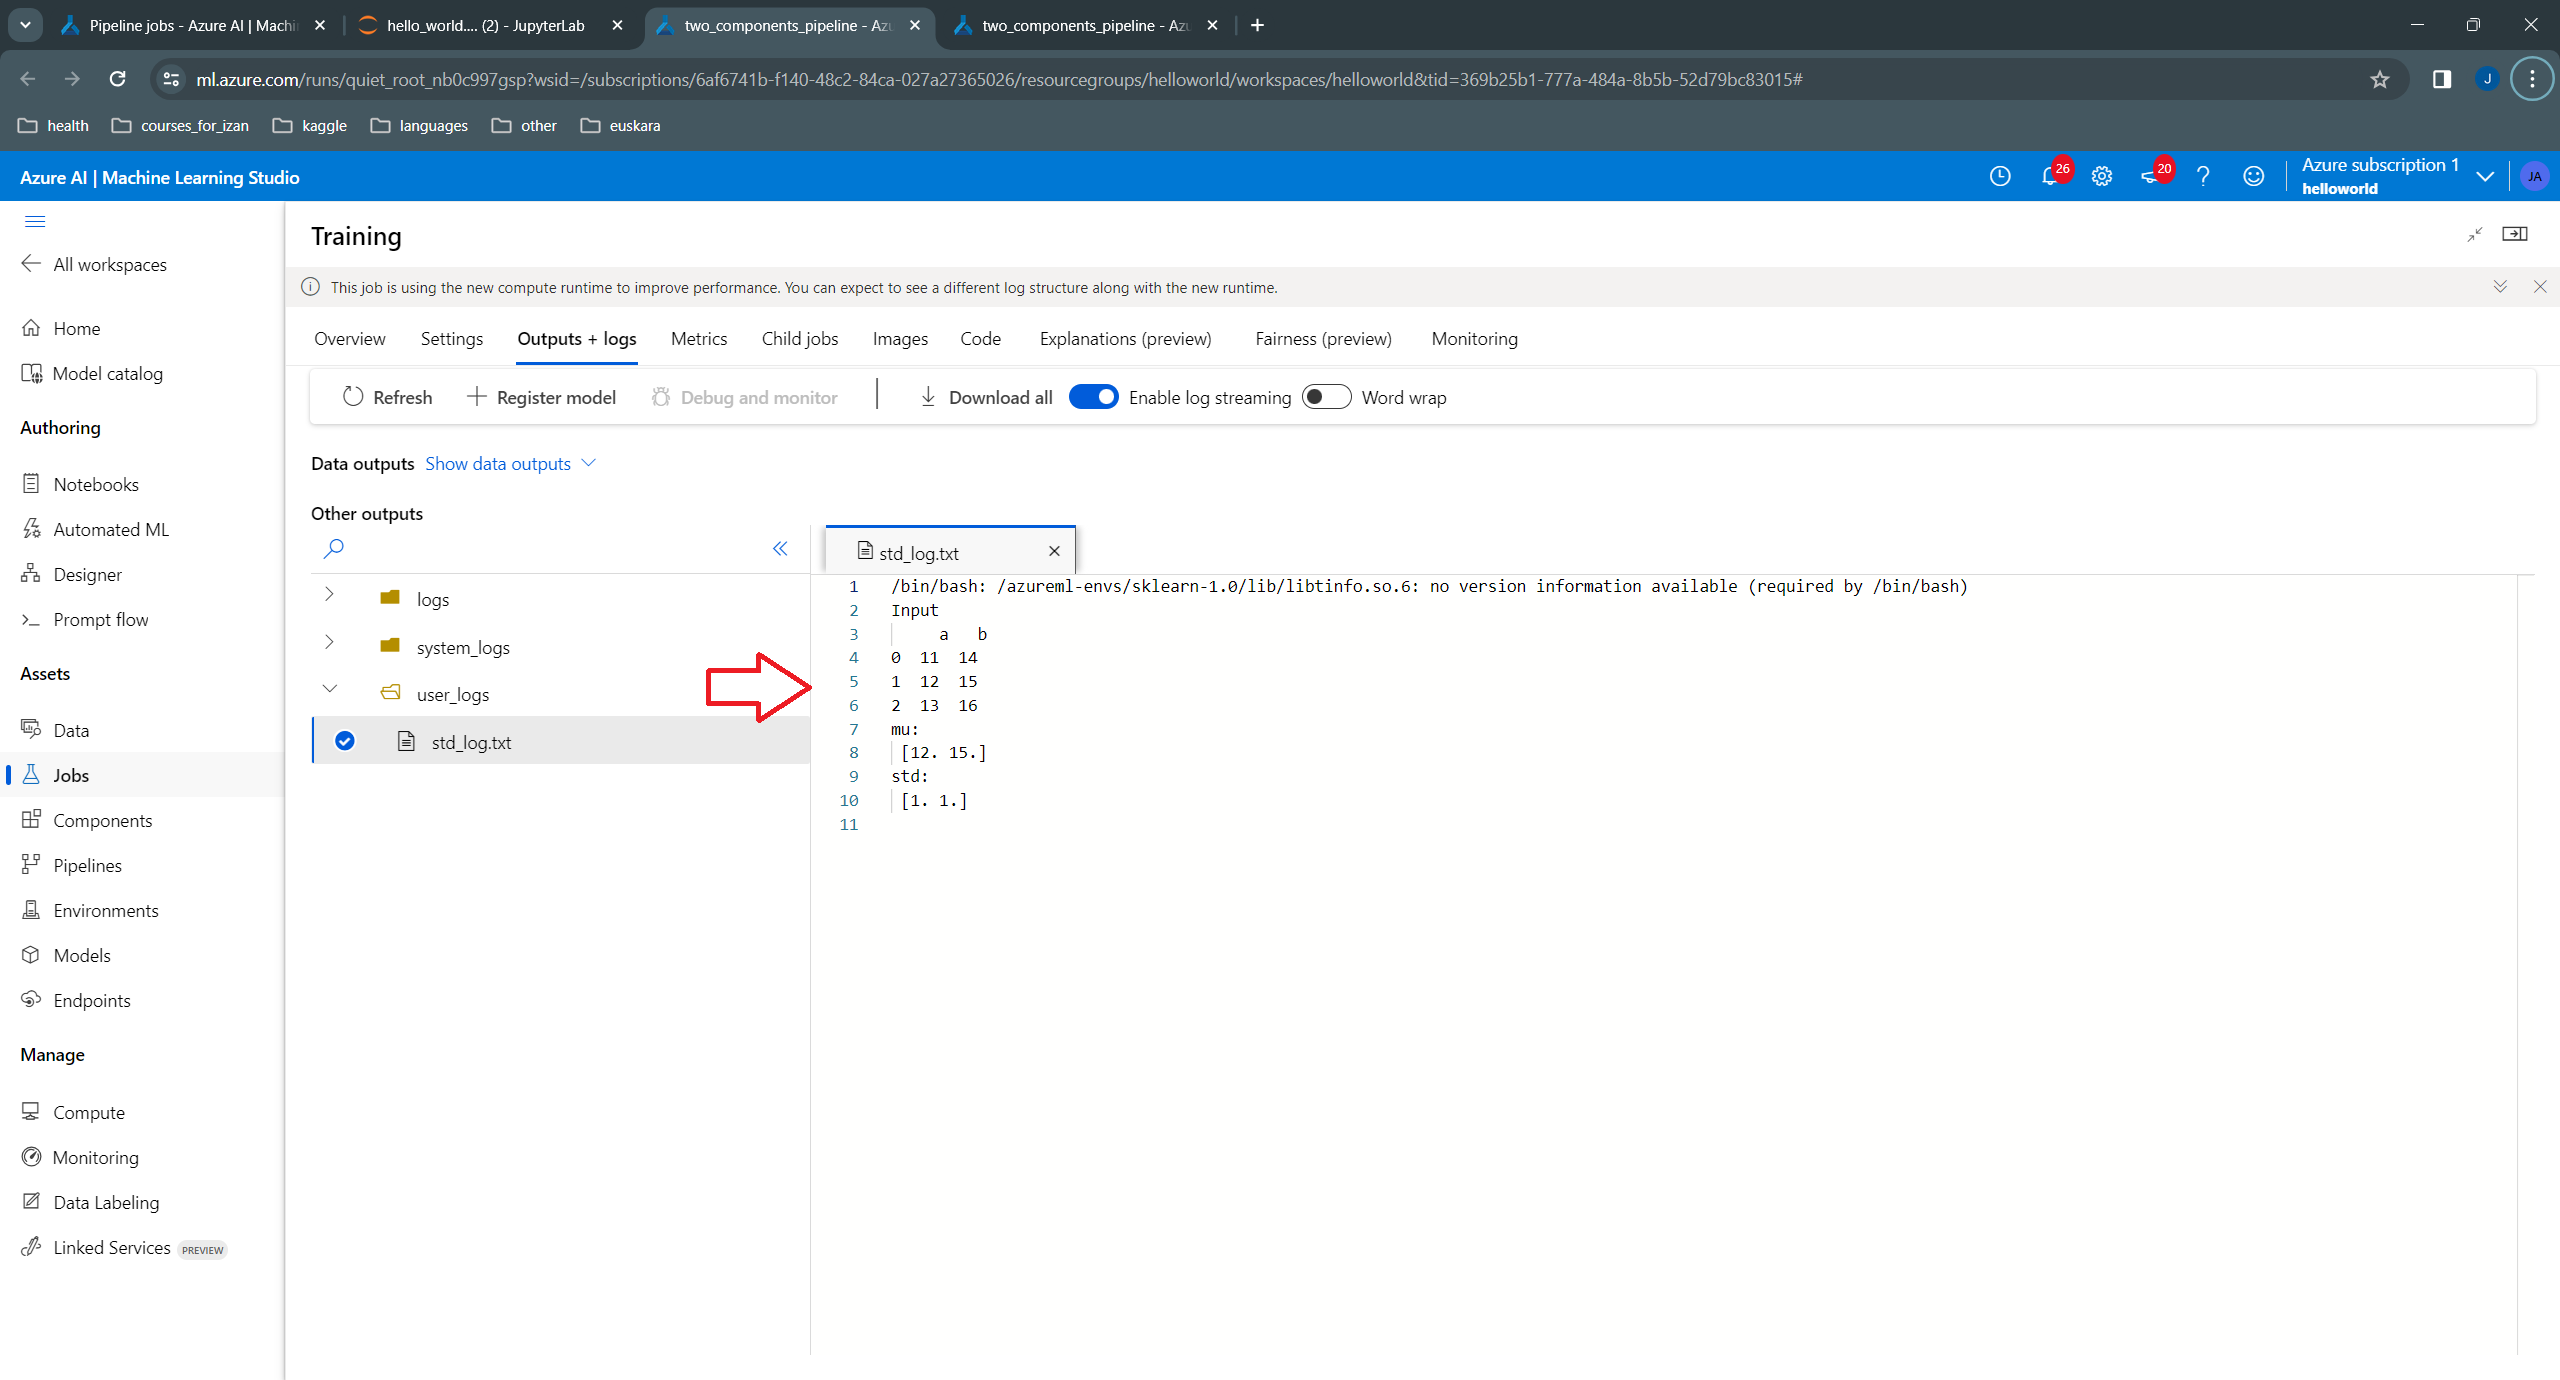

## Using uri_folder

### Main differences

Let's try now using outputs of type "uri_folder". We need to do two changes for this purpose:

1. In the component modules, preprocessing/preprocessing.py and training/training.py, the output arguments `args.preprocessed_data` and `args.model` will contain a path to a folder where the file is stored. Therefore, when saving the file, we need to append its name to the input path:

```python
#In preprocessing module:
df.to_csv (preprocessed_data + "/preprocessed_data.csv")
```

and 

```python
# In training module:
df = pd.read_csv (preprocessed_data + "/preprocessed_data.csv", index_col=0)

# later in same module:
joblib.dump (model, model_path + "/model.pk")
```

2. In the definition of the pipeline, we replace the type of the outputs to be "uri_folder", and the input to the training component to be "uri_folder" as well.

```python
    # In preprocessing component
    ...    
    outputs=dict(
        preprocessed_data=Output (type="uri_folder"),
    ),
    ...
        
    # In training component
    ...
    inputs=dict(
        preprocessed_data=Input (type="uri_folder"),
    ),
    outputs=dict(
        model=Output (type="uri_folder"),
    ),
    ...
```

Here we have the final implementation of our components:

### Preprocessing component

In [17]:
%%writefile preprocessing/preprocessing.py
import argparse
import pandas as pd

def preprocessing (df, x):
    """Adds `x` to input data frame `df`."""
    
    print ("Input\n", df)
    print (f"Adding {x} to df")
    df = df + x
    print ("Output\n", df)
    return df

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str, help="path to input data *file*")
    parser.add_argument("--preprocessed_data", type=str, help="path to output data *folder* containing the preprocessed data.")
    parser.add_argument("-x", type=int, help="number to add")
    args = parser.parse_args()
    
    return args

def read_and_preprocess (
    input_data,
    x,
    preprocessed_data,
):
    df = pd.read_csv (input_data, index_col=0)
    df = preprocessing (df, x)
    df.to_csv (preprocessed_data + "/preprocessed_data.csv")
    
def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_preprocess (args.input_data, args.x, args.preprocessed_data)

if __name__ == "__main__":
    main()

Overwriting preprocessing/preprocessing.py


In [18]:
preprocessing_command = command(
    inputs=dict(
        input_data=Input (type="uri_file"),
        x=Input (type="number"),
    ),
    outputs=dict(
        preprocessed_data=Output (type="uri_folder"),
    ),
    code=f"./preprocessing/",  # location of source code: in this case, the root folder
    command="python preprocessing.py --input_data ${{inputs.input_data}} -x ${{inputs.x}} --preprocessed_data ${{outputs.preprocessed_data}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Pre-processing",
)
preprocessing_component = ml_client.create_or_update(preprocessing_command.component)

### Training component

In [19]:
%%writefile training/training.py
import argparse
import joblib
import pandas as pd

def train_model (df: pd.DataFrame):
    """Trains a dummy Gaussian model from training set df."""
    
    print ("Input\n", df)
    mu = df.mean().values
    std = df.std().values
    print ("mu:\n", mu)
    print ("std:\n", std)
    return mu, std

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--preprocessed_data", type=str, help="path to preprocessed data")
    parser.add_argument("--model", type=str, help="path to built model")
    args = parser.parse_args()
    
    return args

def read_and_train (
    preprocessed_data: str,
    model_path: str,
):
    """Reads training data, trains model, and saves it."""
    df = pd.read_csv (preprocessed_data + "/preprocessed_data.csv", index_col=0)
    model = train_model (df)
    joblib.dump (model, model_path + "/model.pk")

def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_train (args.preprocessed_data, args.model)

if __name__ == "__main__":
    main()

Overwriting training/training.py


In [20]:
# Component definition and registration
training_command = command(
    inputs=dict(
        preprocessed_data=Input (type="uri_folder"),
    ),
    outputs=dict(
        model=Output (type="uri_folder"),
    ),
    code=f"./training/",  # location of source code: in this case, the root folder
    command="python training.py --preprocessed_data ${{inputs.preprocessed_data}} --model ${{outputs.model}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Training",
)

training_component = ml_client.create_or_update(training_command.component)

Uploading training (0.0 MBs): 100%|██████████| 1084/1084 [00:00<00:00, 39997.06it/s]




### Testing the pipeline

Again, before submitting the pipeline job, we first test a manually built pipeline. Note that the new pipeline uses paths to folders, and not paths to files, for the outputs:

In [21]:
from importlib import reload 
from preprocessing import preprocessing
from training import training

reload (preprocessing)
reload (training)

def test_pipeline (
    pipeline_job_data_input: str,
    pipeline_job_x: int,
    pipeline_job_preprocess_output: str,
    pipeline_job_model_output: str,
):
    """
    Tests two component pipeline with preprocessing and training.
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Path to input data *file*
    pipeline_job_x: int
        Integer to add to input data to convert it to "preprocessed" data.
    pipeline_job_test_input: str
        Path to (preprocessed) test input *file*
    pipeline_job_preprocess_output: str
        Path to preprocessed data *folder*, to be used as training.
        Not present in the final pipeline.
    pipeline_job_model_output: str
        Path to model *folder*. Not present in the final pipeline.
    """
    preprocessing.read_and_preprocess (
        pipeline_job_data_input,
        pipeline_job_x,
        pipeline_job_preprocess_output,
    )
    training.read_and_train (
        pipeline_job_preprocess_output,
        pipeline_job_model_output,
    )

os.makedirs ("test_pipeline", exist_ok=True)

test_pipeline (
    pipeline_job_data_input="./data/dummy_input.csv",
    pipeline_job_x=10,
    pipeline_job_preprocess_output="./test_pipeline",
    pipeline_job_model_output="./test_pipeline"
)

Input
    a  b
0  1  4
1  2  5
2  3  6
Adding 10 to df
Output
     a   b
0  11  14
1  12  15
2  13  16
Input
     a   b
0  11  14
1  12  15
2  13  16
mu:
 [12. 15.]
std:
 [1. 1.]


... and the implementation of our pipeline:

### Pipeline

In [22]:
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def two_components_pipeline(
    pipeline_job_data_input,
    pipeline_job_x,
):
    """
    Pipeline with two components: preprocessing, and training.
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Path to input data *file*
    pipeline_job_x: int
        Integer to add to input data to convert it to "preprocessed" data.
    """
    # using data_prep_function like a python call with its own inputs
    preprocessing_job = preprocessing_component(
        input_data=pipeline_job_data_input,
        x=pipeline_job_x,
    )

    # using train_func like a python call with its own inputs
    training_job = training_component(
        preprocessed_data=preprocessing_job.outputs.preprocessed_data,  # note: using outputs from previous step
    )
two_components_pipeline = two_components_pipeline(
    pipeline_job_data_input=Input(type="uri_file", path="./data/dummy_input.csv"),
    pipeline_job_x=10,
)

two_components_pipeline_job = ml_client.jobs.create_or_update(
    two_components_pipeline,
    # Project's name
    experiment_name="e2e_two_components_pipeline_with_uri_folder",
)

# ----------------------------------------------------
# Pipeline running
# ----------------------------------------------------
ml_client.jobs.stream(two_components_pipeline_job.name)

RunId: calm_zebra_t3gb5cjnrk
Web View: https://ml.azure.com/runs/calm_zebra_t3gb5cjnrk?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-28 08:45:53Z] Completing processing run id 1ff53a74-943f-4f94-8efd-4b55b345449f.
[2024-03-28 08:45:54Z] Submitting 1 runs, first five are: e26d0be6:8e0f40eb-e2c3-4feb-a0d0-9882de1daebc

Execution Summary
RunId: calm_zebra_t3gb5cjnrk
Web View: https://ml.azure.com/runs/calm_zebra_t3gb5cjnrk?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld



Now, when we go to the "Explore" tab, in the output data of the preprocessed component, we can see the contents of the output preprocessed data in tabular format. We can also see that the extension of the output, which is csv file:

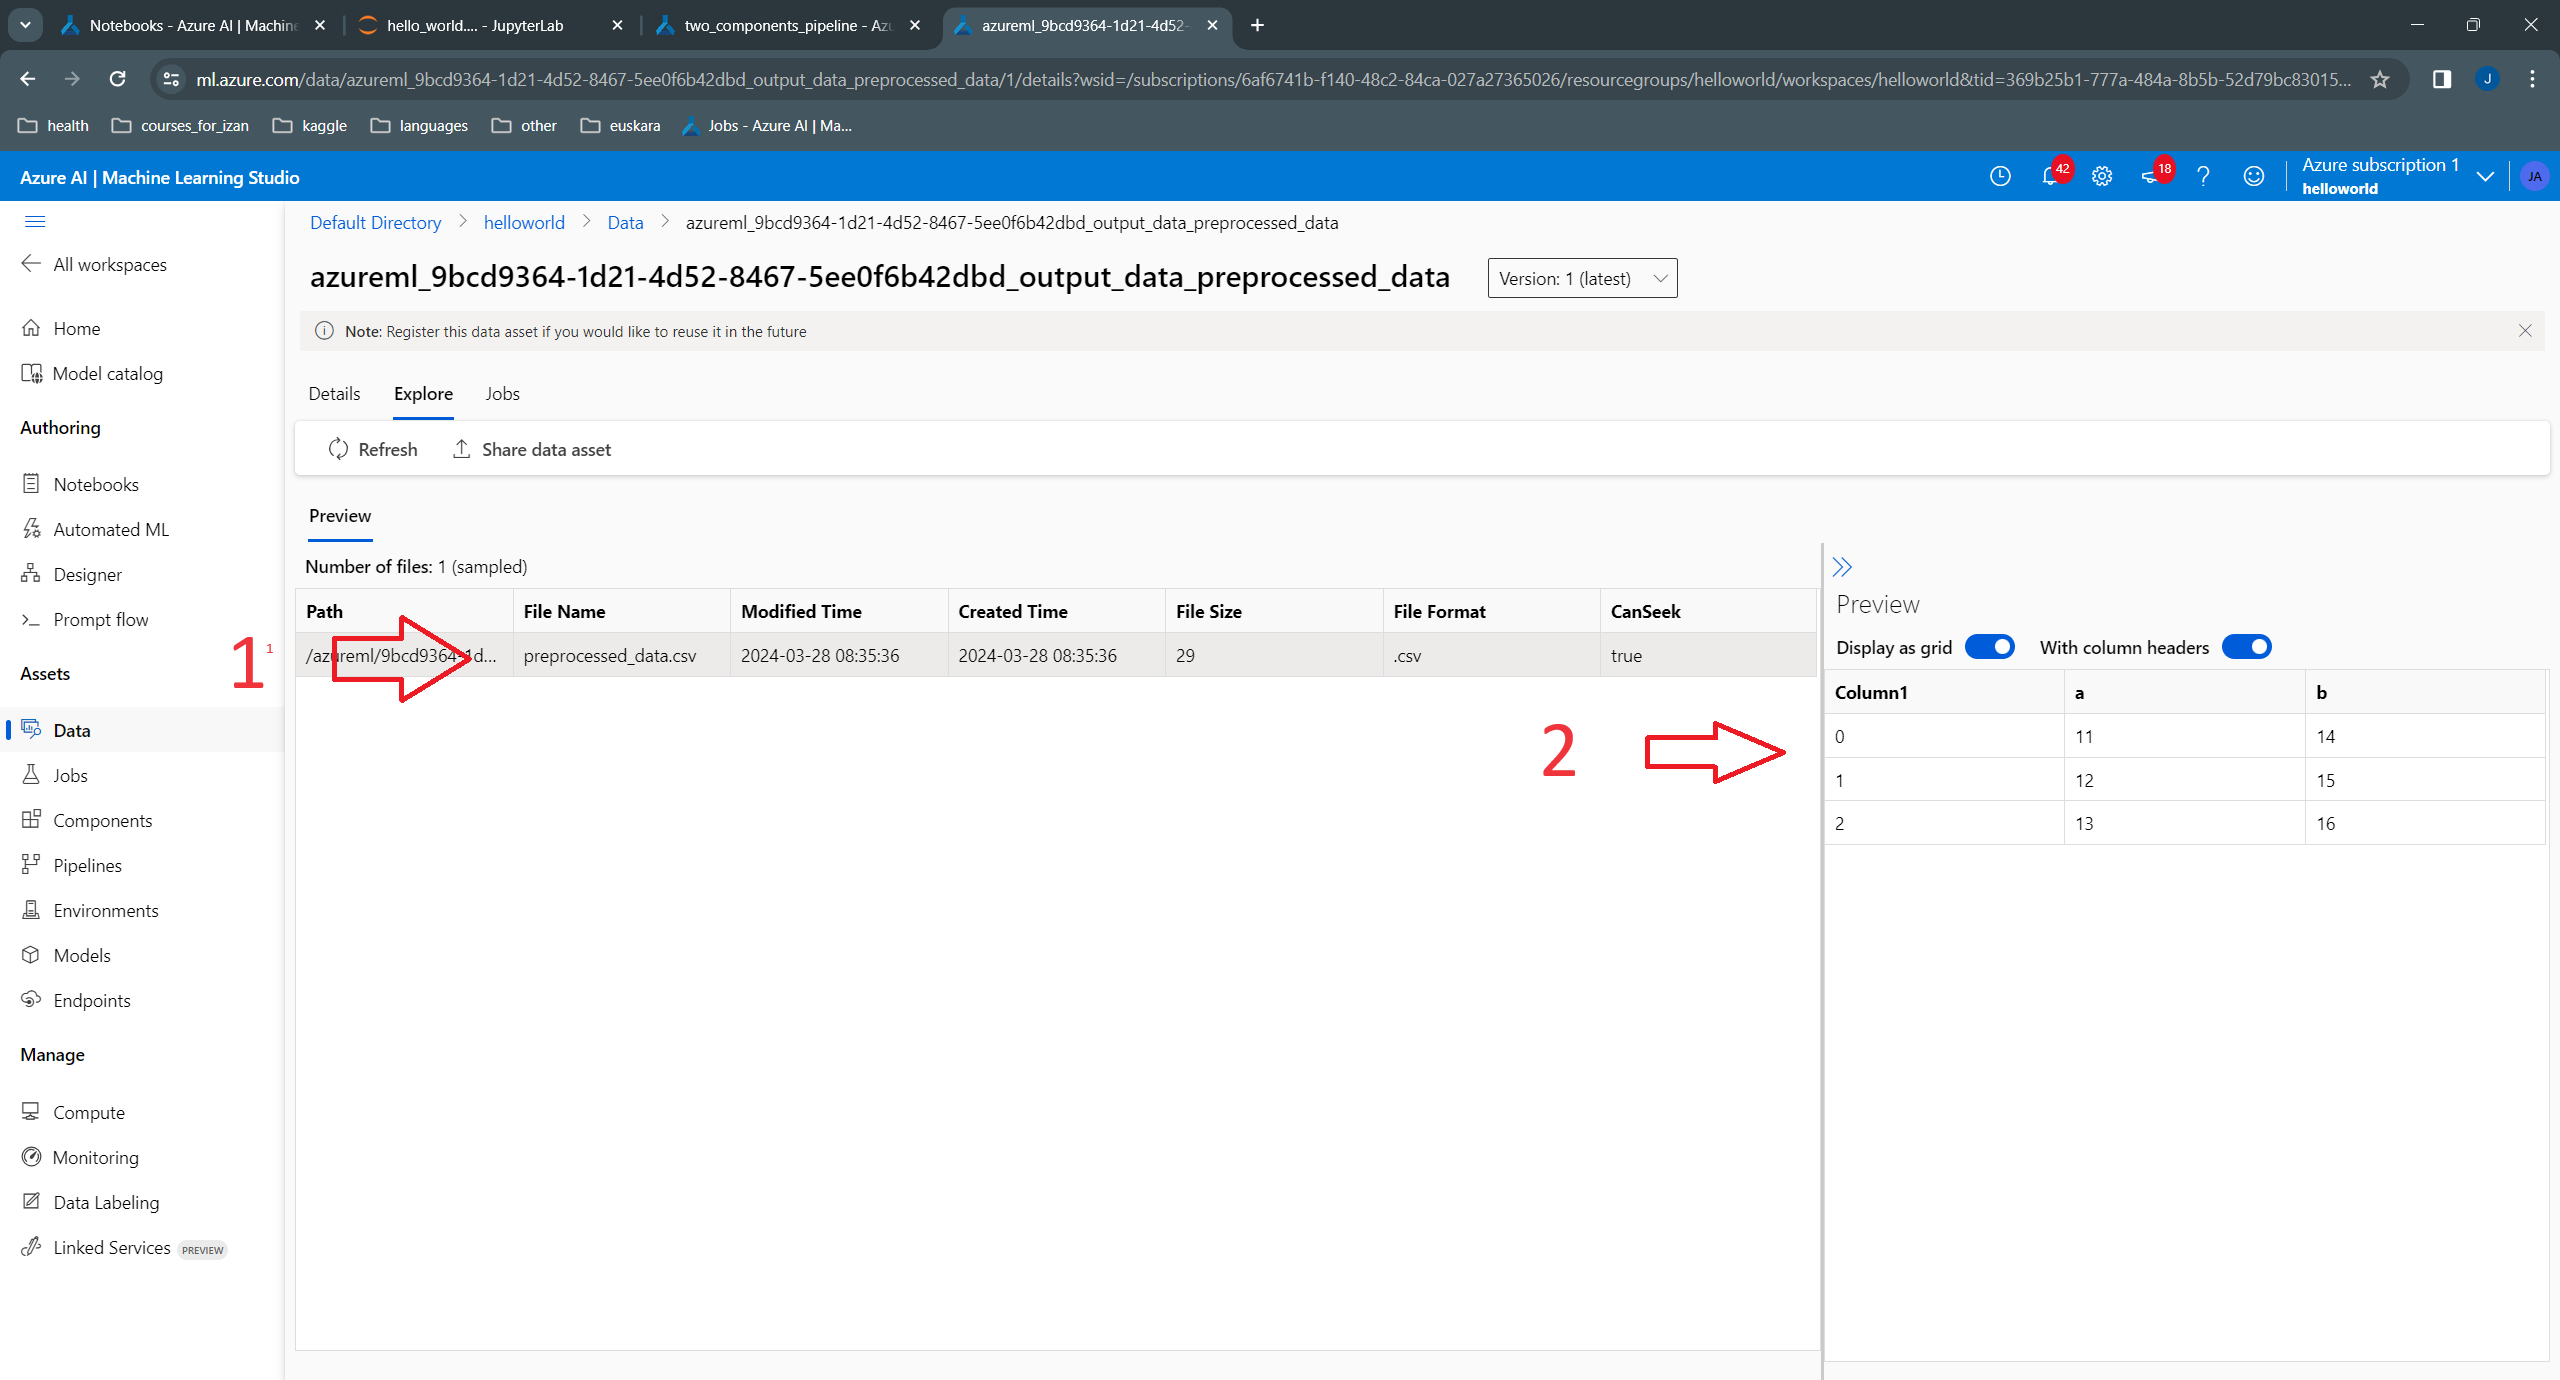

## Pipeline with three components

We add now a third component, which takes as input test data, preprocesses it, and uses the model to perform "inference". For this pipeline, we can reuse the training component from the last section, but we need to slighty modify the preprocessing component to use an additional argument: the name of the output file. This is needed because there will be two outputs: one when preprocessing the training data, and the other when preprocessing the test data. 

### Preparing data

In [9]:
os.makedirs ("inference", exist_ok=True)
test_data = pd.DataFrame (
    {
        "a": [11., 12.1, 13.1],
        "b": [14.1, 15.1, 16.1],
    }
)
test_data.to_csv ("data/dummy_test.csv")

### Preprocessing component

In [48]:
%%writefile preprocessing/preprocessing.py
import argparse
import pandas as pd

def preprocessing (df, x):
    """Adds `x` to input data frame `df`."""
    
    print ("Input\n", df)
    print (f"Adding {x} to df")
    df = df + x
    print ("Output\n", df)
    return df

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str, help="path to input data *file*")
    parser.add_argument("--preprocessed_data", type=str, help="path to output data *folder* containing the preprocessed data.")
    parser.add_argument("--preprocessed_file_name", type=str, help="name of preprocessed file name.")
    parser.add_argument("-x", type=int, help="number to add")
    args = parser.parse_args()
    
    return args

def read_and_preprocess (
    input_data: str,
    preprocessed_data: str,
    preprocessed_file_name: str,
    x: int,
):
    df = pd.read_csv (input_data, index_col=0)
    df = preprocessing (df, x)
    df.to_csv (f"{preprocessed_data}/{preprocessed_file_name}")
    
def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_preprocess (
        input_data=args.input_data, 
        preprocessed_data=args.preprocessed_data,
        preprocessed_file_name=args.preprocessed_file_name,
        x=args.x, 
    )

if __name__ == "__main__":
    main()

Overwriting preprocessing/preprocessing.py


In [49]:
preprocessing_command = command(
    inputs=dict(
        input_data=Input (type="uri_file"),
        x=Input (type="number"),
        preprocessed_file_name=Input (type="string"),
    ),
    outputs=dict(
        preprocessed_data=Output (type="uri_folder"),
    ),
    code=f"./preprocessing/",  # location of source code: in this case, the root folder
    command="python preprocessing.py --input_data ${{inputs.input_data}} -x ${{inputs.x}} --preprocessed_data ${{outputs.preprocessed_data}} --preprocessed_file_name ${{inputs.preprocessed_file_name}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Pre-processing",
)
preprocessing_component = ml_client.create_or_update(preprocessing_command.component)

Uploading preprocessing (0.0 MBs): 100%|██████████| 1343/1343 [00:00<00:00, 46879.53it/s]




The preprocessing component doesn't change from the last pipeline, see "Using uri_folder" section.

### Inference component

In [50]:
%%writefile inference/inference.py
import argparse
import joblib
import pandas as pd
from typing import Tuple
import numpy as np

def inference (
    model: Tuple[np.ndarray, np.ndarray], 
    df: pd.DataFrame,
):
    """
    Runs dummy inference on new data `df`
    """
    (mu, std) = model
    z_df = (df - mu) / std
    print ("Inference result:")
    print (z_df)
    return z_df

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--test_data", type=str, help="path to test data *folder*")
    parser.add_argument("--test_data_file_name", type=str, help="name of test data file name.")
    parser.add_argument("--model", type=str, help="path to built model *folder*")
    parser.add_argument("--inference_output", type=str, help="path to inference result *folder*")
    args = parser.parse_args()
    
    return args

def read_and_inference (
    test_data: str,
    test_data_file_name: str,
    model_path: str,
    inference_data: str,
):
    """
    Reads test data and model, performs inference, and writes to output inference file.
    
    Parameters
    ----------
    test_data: str
        Path to test (preprocessed) data *folder*
    test_data_file_name: str
        Name of test data file.
    model_path: str
        Path to built model *folder*
    inference_data: str
        Path to inference result *folder*
    """
    df = pd.read_csv (f"{test_data}/{test_data_file_name}", index_col=0)
    model = joblib.load (model_path + "/model.pk")
    z_df = inference (model, df)
    z_df.to_csv (inference_data + "/inference_result.csv")

def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_inference (
        test_data=args.test_data, 
        test_data_file_name=args.test_data_file_name,
        model_path=args.model, 
        inference_data=args.inference_output,
    )

if __name__ == "__main__":
    main()

Overwriting inference/inference.py


In [51]:
inference_command = command(
    inputs=dict(
        test_data=Input (type="uri_folder"),
        test_data_file_name=Input (type="string"),
        model=Input (type="uri_folder"),
    ),
    outputs=dict(
        inference_output=Output (type="uri_folder"),
    ),
    code=f"./inference/",  # location of source code: in this case, the root folder
    command="python inference.py " 
            "--test_data ${{inputs.test_data}} "
            "--test_data_file_name ${{inputs.test_data_file_name}} "
            "--model ${{inputs.model}} "
            "--inference_output ${{outputs.inference_output}}",

    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="inference",
)
inference_component = ml_client.create_or_update(inference_command.component)

Uploading inference (0.0 MBs): 100%|██████████| 1912/1912 [00:00<00:00, 63810.98it/s]




### Testing the pipeline

Before submitting the pipeline job, it is very important to test it first, ideally with some dummy or small dataset. For this purpose, in the component implementation above, we have separated the code related with argument parsing and the rest of the code, which is in encapsulated in a function called `read_and_<...>`. This way, we can easily write a test pipeline before implementing the final one, as follows:

In [52]:
# We will need to change the code as we iteratively refine it 
# while testing the pipeline. For that purpose, we use the 
# reload module
from importlib import reload 
from preprocessing import preprocessing
from training import training
from inference import inference

reload (preprocessing)
reload (training)
reload (inference)

def test_pipeline (
    pipeline_job_data_input: str,
    pipeline_job_x: int,
    pipeline_job_test_input: str,
    pipeline_preprocessed_file_name: str,
    pipeline_test_file_name: str,
    
    # The following parameters are not present in the final pipeline:
    pipeline_job_preprocess_output: str,
    pipeline_job_test_output: str,
    pipeline_job_model_output: str,
    pipeline_job_inference_output: str,
):
    """
    Tests third pipeline: preprocessing, training and inference.
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Path to input data *file*
    pipeline_job_x: int
        Integer to add to input data to convert it to "preprocessed" data.
    pipeline_job_test_input: str
        Path to (preprocessed) test input *file*
    pipeline_job_test_input: str
        Path to (preprocessed) test input *file*
    pipeline_preprocessed_file_name: str
        Name of (preprocessed) input data file.
    pipeline_test_file_name: str
        Name of (preprocessed) test data file.
    pipeline_job_preprocess_output: str
        Path to preprocessed data *folder*, to be used as training.
        Not present in the final pipeline.
    pipeline_job_test_output: str
        Path to preprocessed test data *folder*, to be used for inferencing.
        Not present in the final pipeline.
    pipeline_job_model_output: str
        Path to model *folder*. Not present in the final pipeline.
    pipeline_job_inference_output: str
        Path to inference result *folder*. Not present in the final pipeline.
    """
    
    preprocessing.read_and_preprocess (
        pipeline_job_data_input,
        pipeline_job_preprocess_output,
        pipeline_preprocessed_file_name,
        pipeline_job_x,
    )
    preprocessing.read_and_preprocess (
        pipeline_job_test_input,
        pipeline_job_test_output,
        pipeline_test_file_name,
        pipeline_job_x,
    )
    training.read_and_train (
        pipeline_job_preprocess_output,
        pipeline_job_model_output,
    )
    inference.read_and_inference (
        test_data=pipeline_job_test_output,
        test_data_file_name=pipeline_test_file_name,
        model_path=pipeline_job_model_output,
        inference_data=pipeline_job_inference_output,
    )

os.makedirs ("test_pipeline", exist_ok=True)

test_pipeline (
    pipeline_job_data_input="./data/dummy_input.csv",
    pipeline_job_x=10,
    pipeline_job_test_input="./data/dummy_test.csv",
    pipeline_preprocessed_file_name="preprocessed_data.csv",
    pipeline_test_file_name="preprocessed_test.csv",
    
    # The following parameters are not present in the final pipeline:
    pipeline_job_preprocess_output="./test_pipeline",
    pipeline_job_test_output="./test_pipeline",
    pipeline_job_model_output="./test_pipeline",
    pipeline_job_inference_output="./test_pipeline",
)

Input
    a  b
0  1  4
1  2  5
2  3  6
Adding 10 to df
Output
     a   b
0  11  14
1  12  15
2  13  16
Input
       a     b
0  11.0  14.1
1  12.1  15.1
2  13.1  16.1
Adding 10 to df
Output
       a     b
0  21.0  24.1
1  22.1  25.1
2  23.1  26.1
Input
     a   b
0  11  14
1  12  15
2  13  16
mu:
 [12. 15.]
std:
 [1. 1.]
Inference result:
      a     b
0   9.0   9.1
1  10.1  10.1
2  11.1  11.1


### Pipeline

In [53]:
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def three_components_pipeline(
    pipeline_job_data_input: str,
    pipeline_job_x: int,
    pipeline_job_test_input: str,
    pipeline_preprocessed_file_name: str,
    pipeline_test_file_name: str,
):
    """
    Third pipeline: preprocessing, training and inference.
    
    Parameters
    ----------
    pipeline_job_data_input: str
        Path to input data *file*
    pipeline_job_x: int
        Integer to add to input data to convert it to "preprocessed" data.
    pipeline_job_test_input: str
        Path to (preprocessed) test input *file*
    pipeline_preprocessed_file_name: str
        Name of (preprocessed) input data file.
    pipeline_test_file_name: str
        Name of (preprocessed) test data file.
    """
    # using data_prep_function like a python call with its own inputs
    preprocessing_job = preprocessing_component(
        input_data=pipeline_job_data_input,
        x=pipeline_job_x,
        preprocessed_file_name=pipeline_preprocessed_file_name,
    )
    
    preprocessing_test_job = preprocessing_component(
        input_data=pipeline_job_test_input,
        x=pipeline_job_x,
        preprocessed_file_name=pipeline_test_file_name,
    )

    # using train_func like a python call with its own inputs
    training_job = training_component(
        preprocessed_data=preprocessing_job.outputs.preprocessed_data,  # note: using outputs from previous step
    )
    
    # using train_func like a python call with its own inputs
    inference_job = inference_component(
        test_data=preprocessing_test_job.outputs.preprocessed_data,
        test_data_file_name=pipeline_test_file_name,
        model=training_job.outputs.model,  # note: using outputs from previous step
    )
    
three_components_pipeline = three_components_pipeline(
    pipeline_job_data_input=Input(type="uri_file", path="./data/dummy_input.csv"),
    pipeline_job_x=10,
    pipeline_job_test_input=Input(type="uri_file", path="./data/dummy_test.csv"),
    pipeline_preprocessed_file_name="preprocessed_data.csv",
    pipeline_test_file_name="preprocessed_test_data.csv",
)

three_components_pipeline_job = ml_client.jobs.create_or_update(
    three_components_pipeline,
    # Project's name
    experiment_name="e2e_three_components_pipeline_with_uri_folder",
)

# ----------------------------------------------------
# Pipeline running
# ----------------------------------------------------
ml_client.jobs.stream(three_components_pipeline_job.name)

RunId: calm_rice_3cmmmtc5mf
Web View: https://ml.azure.com/runs/calm_rice_3cmmmtc5mf?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-28 10:15:12Z] Submitting 2 runs, first five are: 47ca85c2:a5595dea-3117-47e9-a99d-186b0c346884,4b1f0180:09aecbcc-aa2c-4cad-b134-eb4837724f58
[2024-03-28 10:20:13Z] Completing processing run id 09aecbcc-aa2c-4cad-b134-eb4837724f58.
[2024-03-28 10:20:13Z] Submitting 1 runs, first five are: fece868d:164d1e2a-a5d7-4081-9a68-a07033a3feee
[2024-03-28 10:20:45Z] Completing processing run id 164d1e2a-a5d7-4081-9a68-a07033a3feee.
[2024-03-28 10:22:15Z] Completing processing run id a5595dea-3117-47e9-a99d-186b0c346884.
[2024-03-28 10:22:16Z] Submitting 1 runs, first five are: a9d60b27:6a18ae74-2a3c-4e16-a6cb-a58649235bfe
[2024-03-28 10:22:52Z] Completing processing run id 6a18ae74-2a3c-4e16-a6cb-a58649235bfe.

Execution Summary
RunId: calm_rice_3cmmmtc5mf
We

Here we can see the resulting pipeline:

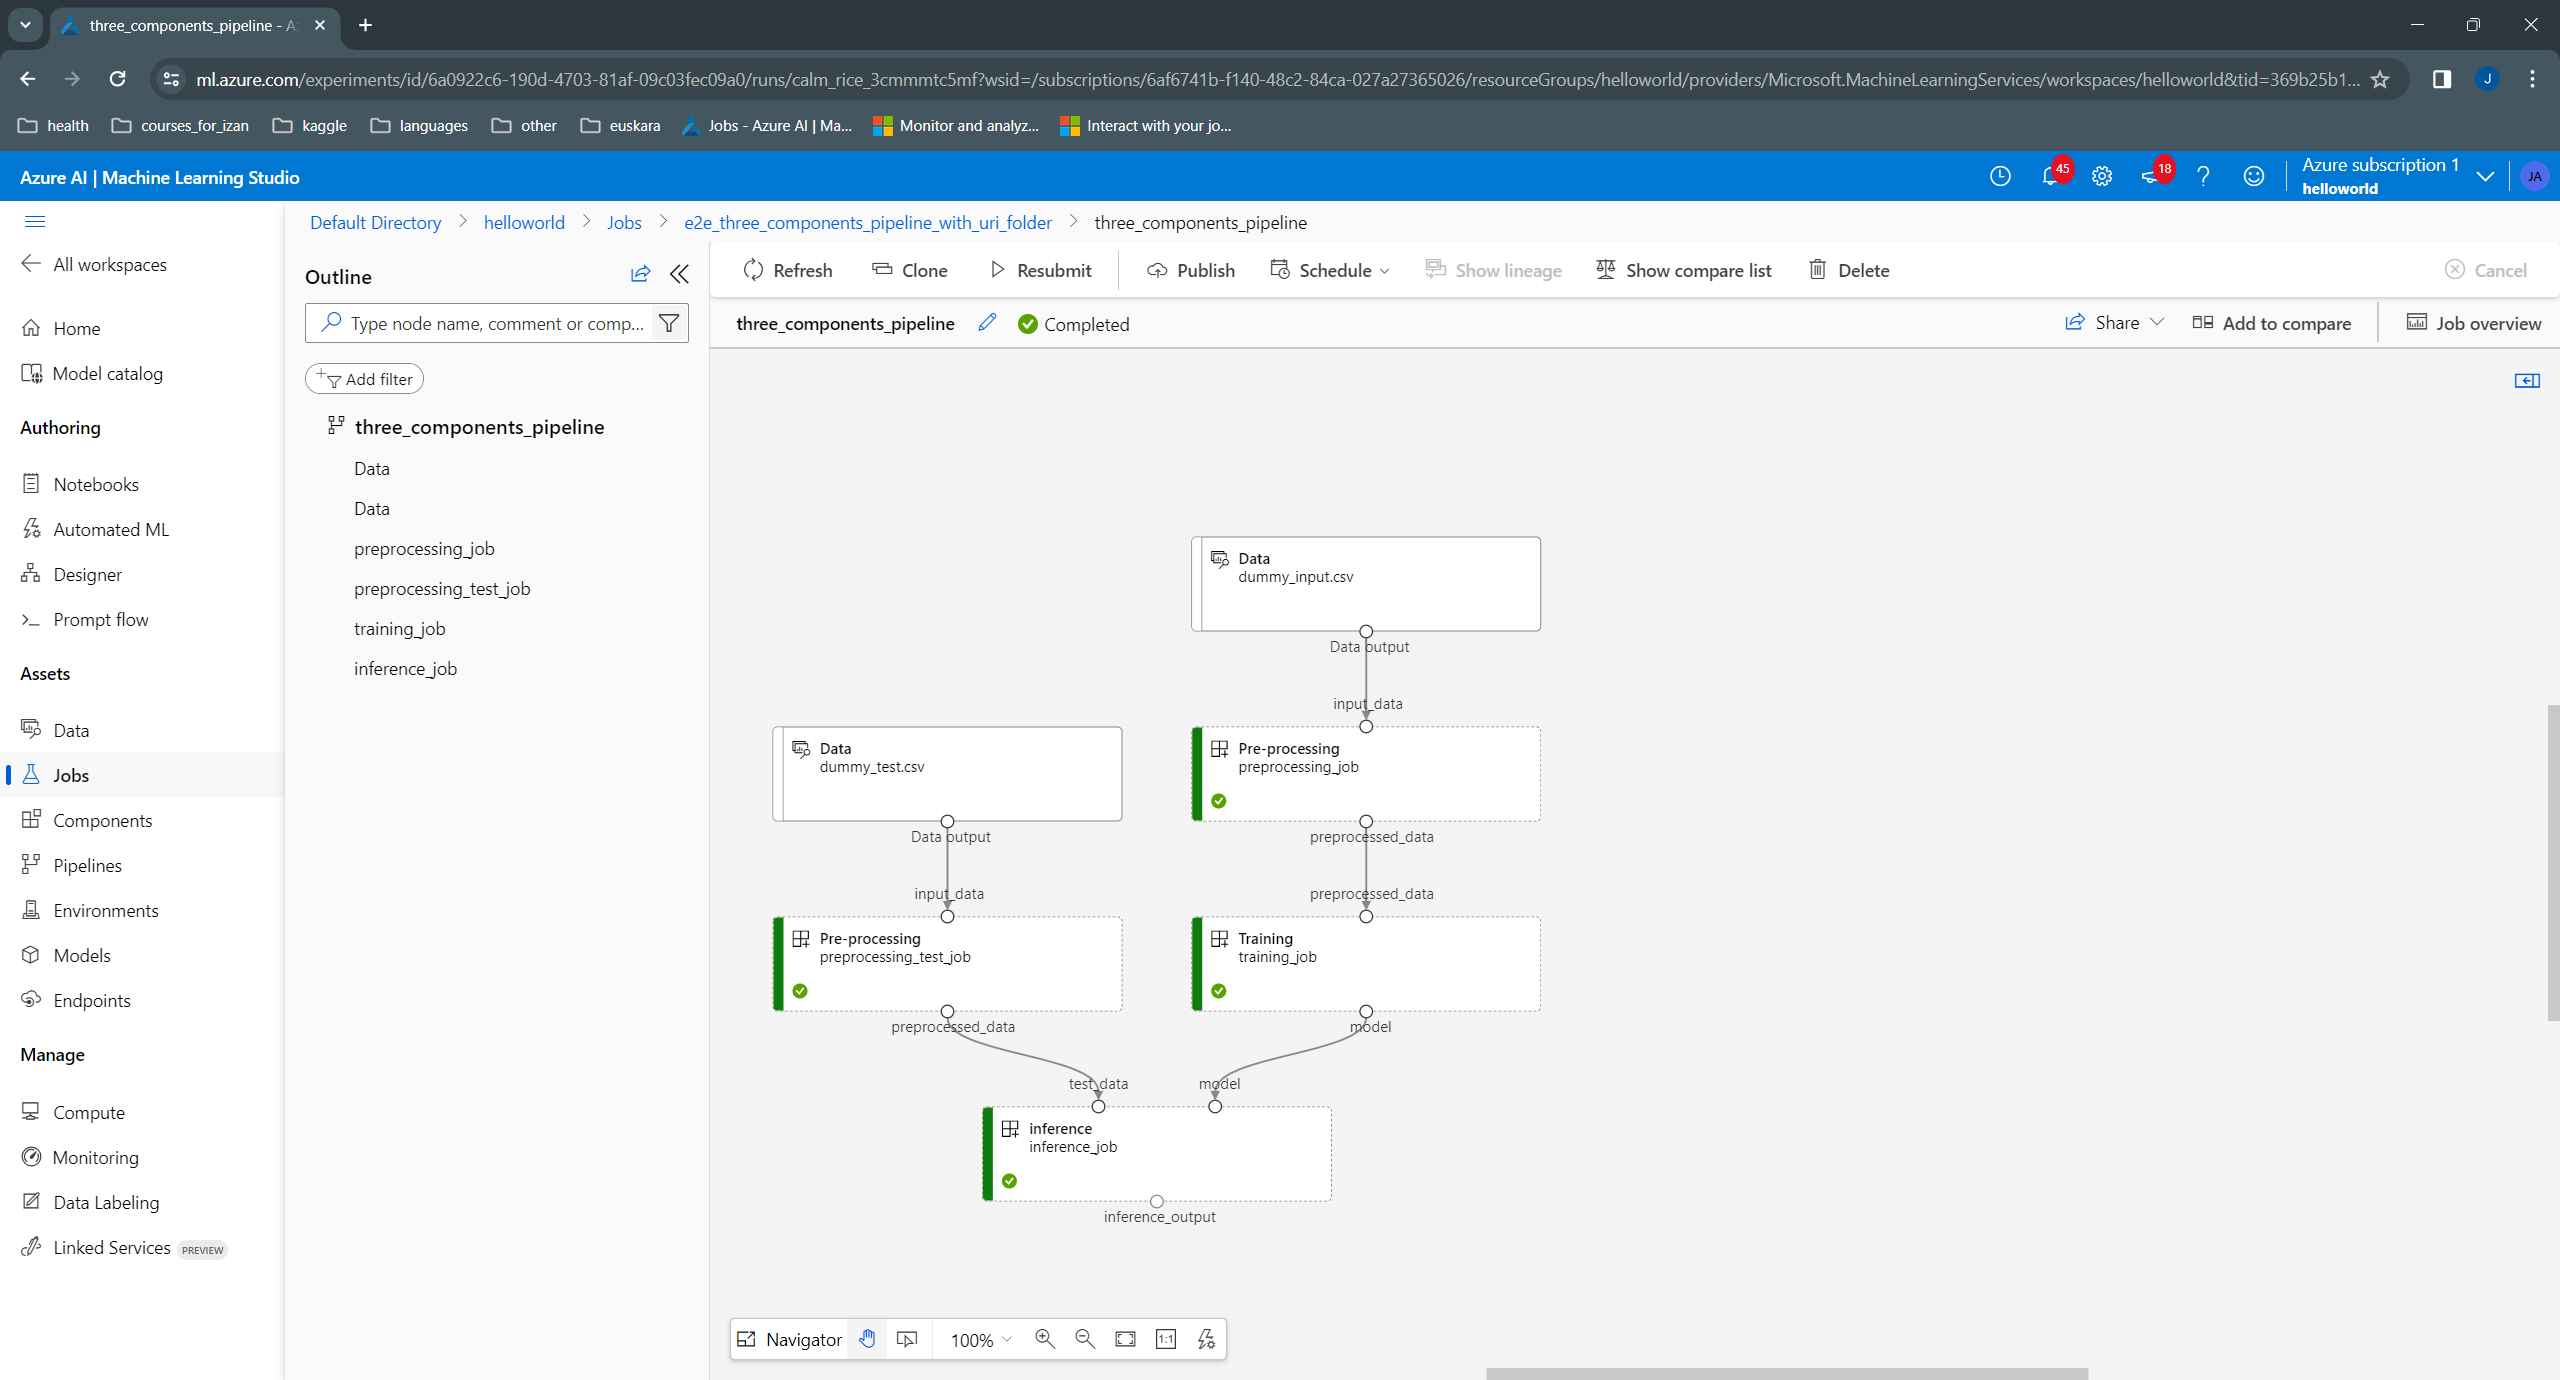

## Refactoring

### Style guide

From the development of the different pipelines we can extract a few observations that help us create a better refactored pipeline and, at the same time, compile a small set of "design" rules that may help us in future pipelines. In my case, I find it clearer and with less boilerplate to use the following rules:

- Use "uri_folder" type for intermediate outputs, and add another parameter next to it containing the output file, something like:

```python
def pipeline(
    ...
    input_folder: str,
    input_filename: str,
    ...
)
```

- Use "_folder" as a prefix for parameters of type `uri_folder`, "_file" for those of type `uri_file`, and "_filename" for those indicating names of file names.

- Use the suffix `input` for those things that are inputs and `ouput`for those that are outputs.

- I'm not clear about this one. Many people usually pass a dataframe called `df` or a numpy array called `X`, which is passed from one step of the pipeline to the next, without appending words to the name that talk about the content of the dataframe or the array (e.g., use "X" instead of "preprocessed_X" or "inference_result_X"). I tend to find it easier to do a similar thing here for the *inputs* of intermediate components, when defining the `command` for those components. Therefore, *for the inputs*, I would use `input_folder` rather than `preprocessed_training_data_input_folder` for indicating the input to the model component. This means that if we replace later the model component with one that works directly on raw (non-preprocessed) data (e.g., because the preprocessing is implicitly done as part of the model), we don't need to replace the part of the script that parses the arguments to indicate that now the input folder is just `training_data_input_folder`. 

- For the outputs, it might be useful to add a short prefix to talk about the type of output, so that the pipeline's diagram shows what is the ouput of each component is. Again, I'm not clear about this one.

- The exception to the previous rules is when we have more than one input or output folder. In this case, we clearly need to add more words to their names.

- It is easier to avoid adding `pipeline_job_...` for each parameter of the pipeline.



## Final pipeline

### Preprocessing component

In [59]:
%%writefile preprocessing/preprocessing.py
import argparse
import pandas as pd

def preprocessing (
    df: pd.DataFrame, 
    x: int
):
    """Adds `x` to input data frame `df`.

    Parameters
    ----------
    df: DataFrame
        Input data frame 
    x: int
        Integer to add to df.

    Returns
    -------
    DataFrame.
        Preprocessed data.
    """
    
    print ("Input\n", df)
    print (f"Adding {x} to df")
    df = df + x
    print ("Output\n", df)
    return df

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_file", type=str, help="path to input data file")
    parser.add_argument("--output_folder", type=str, help="path to output data folder containing the preprocessed data.")
    parser.add_argument("--output_filename", type=str, help="name of file containing the output, preprocessed, data.")
    parser.add_argument("-x", type=int, help="number to add to input data for preprocessing it.")
    args = parser.parse_args()
    
    return args

def read_and_preprocess (
    input_file: str,
    output_folder: str,
    output_filename: str,
    x: int,
):
    """Reads input data, preprocesses it, and writes result as csv file in disk.

    Parameters
    ----------
    input_file: str
        Path to input data file.
    output_folder: str
        Path to output data folder containing the preprocessed data.
    output_filename: str
        Name of file containing the output, preprocessed, data.
    x: int
        Number to add to input data for preprocessing it.
    """
    df = pd.read_csv (input_file, index_col=0)
    df = preprocessing (df, x)
    df.to_csv (f"{output_folder}/{output_filename}")
    
def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_preprocess (
        input_file=args.input_file, 
        output_folder=args.output_folder,
        output_filename=args.output_filename,
        x=args.x, 
    )

if __name__ == "__main__":
    main()

Overwriting preprocessing/preprocessing.py


In [60]:
preprocessing_command = command(
    inputs=dict(
        input_file=Input (type="uri_file"),
        x=Input (type="number"),
        output_filename=Input (type="string"),
    ),
    outputs=dict(
        output_folder=Output (type="uri_folder"),
    ),
    code=f"./preprocessing/",  # location of source code: in this case, the root folder
    command="python preprocessing.py "
        "--input_file ${{inputs.input_file}} "
        "-x ${{inputs.x}} "
        "--output_folder ${{outputs.output_folder}} "
        "--output_filename ${{inputs.output_filename}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Pre-processing",
)
preprocessing_component = ml_client.create_or_update(preprocessing_command.component)

Uploading preprocessing (0.0 MBs): 100%|██████████| 1985/1985 [00:00<00:00, 64070.90it/s]




### Training component

In [61]:
%%writefile training/training.py
import argparse
import joblib
import pandas as pd

def train_model (df: pd.DataFrame):
    """Trains a dummy Gaussian model from training set df.
    
    Parameters
    ----------
    df: DataFrame
        Input data frame
    
    Returns
    -------
    np.ndarray
        Average across rows, one per column.
    np.ndarray
        Standard deviation across rows, one per column.
    """
    
    print ("Input\n", df)
    mu = df.mean().values
    std = df.std().values
    print ("mu:\n", mu)
    print ("std:\n", std)
    return mu, std

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument(
        "--input_folder", 
        type=str, 
        help="path to preprocessed training data folder, "
             "containing training set file."
    )
    parser.add_argument(
        "--input_filename", 
        type=str, 
        help="name of file containing preprocessed, training data."
    )
    parser.add_argument(
        "--output_folder", 
        type=str, 
        help="path to output *folder* containing the trained model."
    )
    parser.add_argument(
        "--output_filename", 
        type=str, 
        help="name of file containing the trained model."
    )
    args = parser.parse_args()
    
    return args

def read_and_train (
    input_folder: str,
    input_filename: str,
    output_folder: str,
    output_filename: str,
):
    """Reads training data, trains model, and saves it.
    
    Parameters
    ----------
    input_folder: str
        Path to preprocessed training data folder containing training set file.
    input_filename: str
        Name of file containing preprocessed, training data.
    output_folder: str
        Path to output folder containing the trained model.
    output_filename: str
        Name of file containing the trained model.
    """
    
    df = pd.read_csv (f"{input_folder}/{input_filename}", index_col=0)
    model = train_model (df)
    joblib.dump (model, f"{output_folder}/{output_filename}")

def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_train (
        args.input_folder, 
        args.input_filename,
        args.output_folder,
        args.output_filename,
    )

if __name__ == "__main__":
    main()

Overwriting training/training.py


In [62]:
# Component definition and registration
training_command = command(
    inputs=dict(
        input_folder=Input (type="uri_folder"),
        input_filename=Input (type="string"),
        output_filename=Input (type="string"),
    ),
    outputs=dict(
        output_folder=Output (type="uri_folder"),
    ),
    code=f"./training/",  # location of source code: in this case, the root folder
    command="python training.py "
        "--input_folder ${{inputs.input_folder}} "
        "--input_filename ${{inputs.input_filename}} "
        "--output_folder ${{outputs.output_folder}} "
        "--output_filename ${{inputs.output_filename}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="Training",
)

training_component = ml_client.create_or_update(training_command.component)

Uploading training (0.0 MBs): 100%|██████████| 2309/2309 [00:00<00:00, 50917.16it/s]




### Inference component

In [70]:
%%writefile inference/inference.py
import argparse
from typing import Tuple
import joblib
import pandas as pd
from sklearn.metrics import DistanceMetric
import numpy as np

def inference (
    model: Tuple[np.ndarray, np.ndarray], 
    df: pd.DataFrame,
):
    """Runs dummy inference on new data `df`.

    Parameters
    ----------
    model: Tople (np.ndarray, np.ndarray)
        Average across rows (one per column), and 
        standard deviation across rows (one per column).
    df: DataFrame
        Test data frame on which to perform inference.
    
    Returns
    -------
    DataFrame
        One column dataframe giving an approximation of the Mahalanobis distance 
        between each row vector and the mean vector, assuming that the covariance 
        matrix is diagonal. The negative of the scores obtained can be considered 
        as a sort of prediction probability for each row of belonging to the Gaussian 
        class estimated from the training data. In this sense this function provides
        inference about how "normal" the test samples are. 
    """
    (mu, std) = model
    dist = DistanceMetric.get_metric('mahalanobis', V=np.diag(std**2))
    ndims = df.shape[1]
    mah_dist = dist.pairwise (mu.reshape(1, ndims), df)
    mah_dist = pd.DataFrame (mah_dist.ravel(), columns=["distance"])
    print ("Inference result:")
    print (mah_dist)
    return mah_dist

def parse_args ():
    """Parses input arguments"""
    
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--preprocessed_input_folder", 
        type=str, 
        help="path to input, preprocessed, test data folder, "
             "containing file on which to perform inference."
    )
    parser.add_argument(
        "--preprocessed_input_filename", 
        type=str, 
        help="name of file containing the input, preprocessed, test data."
    )
    parser.add_argument(
        "--model_input_folder", 
        type=str, 
        help="path to model folder."
    )
    parser.add_argument(
        "--model_input_filename", 
        type=str, 
        help="name of model file."
    )
    parser.add_argument(
        "--output_folder", 
        type=str, 
        help="path to output data *folder* with inference results."
    )
    parser.add_argument(
        "--output_filename", 
        type=str, 
        help="name of file containing the output data with inference results."
    )
    
    args = parser.parse_args()

    args = parser.parse_args()
    
    return args

def read_and_inference (
    preprocessed_input_folder: str,
    preprocessed_input_filename: str,
    model_input_folder: str,
    model_input_filename: str,
    output_folder: str,    
    output_filename: str,
):
    """
    Reads test data and model, performs inference, and writes to output inference file.
    
    Parameters
    ----------
    preprocessed_input_folder: str
        Path to test (preprocessed) data folder.
    preprocessed_input_filename: str
        Name of test data file.
    model_input_folder: str
        Path to built model folder.
    model_input_filename: str
        Path to inference result folder.
    output_folder: str
        Path to output data folder with inference results.
    output_filename: str
        Name of file containing the output data with inference results.
    """
    df = pd.read_csv (f"{preprocessed_input_folder}/{preprocessed_input_filename}", index_col=0)
    model = joblib.load (f"{model_input_folder}/{model_input_filename}")
    z_df = inference (model, df)
    z_df.to_csv (f"{output_folder}/{output_filename}")

def main():
    """Main function of the script."""
    
    args = parse_args ()
    read_and_inference (
        test_data=args.test_data, 
        test_data_file_name=args.test_data_file_name,
        model_path=args.model, 
        inference_data=args.inference_output,
    )

if __name__ == "__main__":
    main()

Overwriting inference/inference.py


In [71]:
inference_command = command(
    inputs=dict(
        preprocessed_input_folder=Input (type="uri_folder"),
        preprocessed_input_filename=Input (type="string"),
        model_input_folder=Input (type="uri_folder"),
        model_input_filename=Input (type="string"),
        output_filename=Input (type="string"),
    ),
    outputs=dict(
        output_folder=Output (type="uri_folder"),
    ),
    code=f"./inference/",  # location of source code: in this case, the root folder
    command="python inference.py " 
        "--preprocessed_input_folder ${{inputs.preprocessed_input_folder}} "
        "--preprocessed_input_filename ${{inputs.preprocessed_input_filename}} "
        "--model_input_folder ${{inputs.model_input_folder}} "
        "--model_input_filename ${{inputs.model_input_filename}} "
        "--output_folder ${{outputs.output_folder}} "
        "--output_filename ${{inputs.output_filename}} ",

    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="inference",
)
inference_component = ml_client.create_or_update(inference_command.component)

Uploading inference (0.0 MBs): 100%|██████████| 3881/3881 [00:00<00:00, 323452.96it/s]




### Testing the pipeline

Before submitting the pipeline job, it is very important to test it first, ideally with some dummy or small dataset. For this purpose, in the component implementation above, we have separated the code related with argument parsing and the rest of the code, which is in encapsulated in a function called `read_and_<...>`. This way, we can easily write a test pipeline before implementing the final one, as follows:

In [72]:
# We will need to change the code as we iteratively refine it 
# while testing the pipeline. For that purpose, we use the 
# reload module
from importlib import reload 
from preprocessing import preprocessing
from training import training
from inference import inference

reload (preprocessing)
reload (training)
reload (inference)

def test_pipeline (
    # Preprocessing component parameters, first component:
    preprocessing_training_input_file: str,
    preprocessing_training_output_folder: str, # Not present in final pipeline
    preprocessing_training_output_filename: str,
    x: int,
    
    # Preprocessing component parameters, second component:
    preprocessing_test_input_file: str,
    preprocessing_test_output_folder: str, # Not present in final pipeline
    preprocessing_test_output_filename: str,
    
    # Training component parameters:
    # input_folder: this is preprocessing_training_output_folder
    # input_filename: this is preprocessing_training_output_filename
    training_output_folder: str, # Not present in final pipeline
    training_output_filename: str, 
    
    # Inference component parameters:
    # preprocessed_input_folder: this is preprocessing_test_output_folder
    # preprocessed_input_filename: this is preprocessing_test_output_filename
    # model_input_folder: this is training_output_folder
    # model_input_filename: this is training_output_filename
    inference_output_folder: str, # Not present in final pipeline
    inference_output_filename: str,
):
    """
    Tests third pipeline: preprocessing, training and inference.
    
    Parameters
    ----------
    preprocessing_training_input_file: str
        Path to file containing training data to be preprocessed.
    preprocessing_training_output_folder: str
        Path to folder containing the preprocessed, training data file.
        Not present in final pipeline.
    preprocessing_training_output_filename: str
        Name of file containing the preprocessed, training data.
    x: int
        Number to add to input data for preprocessing it.
    preprocessing_test_input_file: str
        Path to file containing test data to be preprocessed.
    preprocessing_test_output_folder: str
        Path to folder containing the preprocessed, test data file.
        Not present in final pipeline.
    preprocessing_test_output_filename: str
        Name of file containing the preprocessed, test data.
    training_output_folder: str
        Path to output folder containing the trained model.
        Not present in final pipeline.
    training_output_filename: str
        Name of file containing the trained model.
    inference_output_folder: str
        Path to output data folder with inference results.
        Not present in final pipeline.
    inference_output_filename: str
        Name of file containing the output data with inference results.
    """
    
    preprocessing.read_and_preprocess (
        input_file=preprocessing_training_input_file,
        output_folder=preprocessing_training_output_folder, # Not present in final component
        output_filename=preprocessing_training_output_filename,
        x=x,
    )
    preprocessing.read_and_preprocess (
        input_file=preprocessing_test_input_file,
        output_folder=preprocessing_test_output_folder,
        output_filename=preprocessing_test_output_filename,
        x=x,
    )
    training.read_and_train (
        input_folder=preprocessing_training_output_folder,
        input_filename=preprocessing_training_output_filename,
        output_folder=training_output_folder,
        output_filename=training_output_filename,
    )
    inference.read_and_inference (
        preprocessed_input_folder=preprocessing_test_output_folder,
        preprocessed_input_filename=preprocessing_test_output_filename,
        model_input_folder=training_output_folder,
        model_input_filename=training_output_filename,
        output_folder=inference_output_folder,
        output_filename=inference_output_filename,
    )

os.makedirs ("test_pipeline", exist_ok=True)

test_pipeline (
    # first preprocessing component
    preprocessing_training_input_file="./data/dummy_input.csv",
    preprocessing_training_output_folder="./test_pipeline", # Not present in final pipeline
    preprocessing_training_output_filename="preprocessed_data.csv",
    x=10,
    
    # second preprocessing component
    preprocessing_test_input_file="./data/dummy_test.csv",
    preprocessing_test_output_folder="./test_pipeline", # Not present in final pipeline
    preprocessing_test_output_filename="preprocessed_test.csv",
    
    # Training component parameters:
    training_output_folder="./test_pipeline", # Not present in final pipeline
    training_output_filename="model.pk",
    
    # Inference component parameters:
    inference_output_folder="./test_pipeline", # Not present in final pipeline
    inference_output_filename="inference_result.csv",
)

Input
    a  b
0  1  4
1  2  5
2  3  6
Adding 10 to df
Output
     a   b
0  11  14
1  12  15
2  13  16
Input
       a     b
0  11.0  14.1
1  12.1  15.1
2  13.1  16.1
Adding 10 to df
Output
       a     b
0  21.0  24.1
1  22.1  25.1
2  23.1  26.1
Input
     a   b
0  11  14
1  12  15
2  13  16
mu:
 [12. 15.]
std:
 [1. 1.]
Inference result:
    distance
0  12.798828
1  14.283557
2  15.697771


### Pipeline

In [ ]:
@dsl.pipeline(
    compute="serverless",  # "serverless" value runs pipeline on serverless compute
    description="E2E hello world pipeline with input",
)
def three_components_pipeline(
    # Preprocessing component parameters, first component:
    preprocessing_training_input_file: str,
    preprocessing_training_output_filename: str,
    x: int,
    
    # Preprocessing component parameters, second component:
    preprocessing_test_input_file: str,
    preprocessing_test_output_filename: str,
    
    # Training component parameters:
    training_output_filename: str, 
    
    # Inference component parameters:
    inference_output_filename: str,
):
    """
    Third pipeline: preprocessing, training and inference.
    
    Parameters
    ----------
    preprocessing_training_input_file: str
        Path to file containing training data to be preprocessed.
    preprocessing_training_output_filename: str
        Name of file containing the preprocessed, training data.
    x: int
        Number to add to input data for preprocessing it.
    preprocessing_test_input_file: str
        Path to file containing test data to be preprocessed.
    preprocessing_test_output_filename: str
        Name of file containing the preprocessed, test data.
    training_output_filename: str
        Name of file containing the trained model.
    inference_output_filename: str
        Name of file containing the output data with inference results.
    """
    # using data_prep_function like a python call with its own inputs
    preprocessing_training_job = preprocessing_component(
        input_file=preprocessing_training_input_file,
        #output_folder: automatically determined
        output_filename=preprocessing_training_output_filename,
        x=x,
    )
    preprocessing_test_job = preprocessing_component(
        input_file=preprocessing_test_input_file,
        #output_folder: automatically determined
        output_filename=preprocessing_test_output_filename,
        x=x,
    )
    training_job = training_component(
        input_folder=preprocessing_training_job.outputs.output_folder,
        input_filename=preprocessing_training_output_filename,
        #output_folder: automatically determined
        output_filename=training_output_filename,
    )
    inference_job = inference_component(
        preprocessed_input_folder=preprocessing_test_job.outputs.output_folder,
        preprocessed_input_filename=preprocessing_test_output_filename,
        model_input_folder=training_job.outputs.output_folder,
        model_input_filename=training_output_filename,
        #output_folder: automatically determined
        output_filename=inference_output_filename,
    )
    
three_components_pipeline = three_components_pipeline(
    # first preprocessing component
    preprocessing_training_input_file=Input(type="uri_file", path="./data/dummy_input.csv"),
    preprocessing_training_output_filename="preprocessed_training_data.csv",
    x=10,
    
    # second preprocessing component
    preprocessing_test_input_file=Input(type="uri_file", path="./data/dummy_test.csv"),
    preprocessing_test_output_filename="preprocessed_test_data.csv",
    
    # Training component parameters:
    training_output_filename="model.pk",
    
    # Inference component parameters:
    inference_output_filename="inference_results.csv",
)

three_components_pipeline_job = ml_client.jobs.create_or_update(
    three_components_pipeline,
    # Project's name
    experiment_name="e2e_three_components_refactored",
)

# ----------------------------------------------------
# Pipeline running
# ----------------------------------------------------
ml_client.jobs.stream(three_components_pipeline_job.name)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


RunId: busy_toe_03bv5yshzh
Web View: https://ml.azure.com/runs/busy_toe_03bv5yshzh?wsid=/subscriptions/6af6741b-f140-48c2-84ca-027a27365026/resourcegroups/helloworld/workspaces/helloworld

Streaming logs/azureml/executionlogs.txt

[2024-03-29 08:45:11Z] Submitting 2 runs, first five are: f39c6442:de45cd94-3bf9-4405-9b9f-59782424a8fb,feeb5198:0b543053-d140-4699-9c29-1ec2e755898e
[2024-03-29 08:50:08Z] Completing processing run id de45cd94-3bf9-4405-9b9f-59782424a8fb.
[2024-03-29 08:50:33Z] Completing processing run id 0b543053-d140-4699-9c29-1ec2e755898e.
[2024-03-29 08:50:34Z] Submitting 1 runs, first five are: 5731fc43:46a9ab31-8a68-42ee-a377-a5e84cbad37d


Here we can see the resulting pipeline:

![](attachment:5e09eb0f-240d-4b9c-95d8-3b46c4047fbe.png)

## Final refactoring